In [1]:
import numpy as np
import pandas as pd
import re
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import wandb
import random
import math
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.cluster import KMeans

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb")

wandb.login(key=secret_value_0)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [4]:
train_data = pd.read_csv('/kaggle/input/netifier/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [5]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [6]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [7]:
train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


In [8]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
# Define compute metrics for evaluation
def compute_metrics(p):
    preds = torch.sigmoid(torch.tensor(p.predictions)).round()  # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)
    
    accuracy = accuracy_score(labels, preds)

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    a, b, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro
    }

In [10]:
# Define compute metrics for evaluation
def compute_metrics_eval(p):
    result = compute_metrics(p)
    
    preds = torch.sigmoid(torch.tensor(p.predictions)).round()  # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)
    
    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    )    
    return {
        'accuracy': result['accuracy'],
        'precision': result['precision'],
        'recall': result['recall'],
        'f1_micro': result['f1_micro'],
        'f1_macro': result['f1_macro'],
        'report': report
    }

# ACTIVE LEARNING LOOP

In [11]:
accuracies = []
f1_micros = []
f1_macros = []
sampling_dur = []
data_used = []

In [12]:
filename = 'netifier-kmeans'
epochs = 10
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [13]:
import numpy as np
import torch
import time
from sklearn.cluster import KMeans

def kmeans_clustering_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, trials, n_clusters=min_increment):
    start_time = time.time()
    current_train_size = len(train_indices)
    embeddings = []

    model.eval()  # Set the model to evaluation mode
    
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=80)
    dataloader = DataLoader(
        dataset,
        batch_size=16,
        num_workers=4,
        pin_memory=True,
    )
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)
    collected_indices = set()  # Initialize set to store selected indices

    num_of_candidates = len(embeddings[:math.ceil(0.1 * len(embeddings))])

    # Check nearest checkpoint
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    # Determine number of clusters
    if num_of_candidates <= n_clusters and n_clusters < nearest_cp - current_train_size:
        n_clusters = n_clusters
    elif num_of_candidates > n_clusters and num_of_candidates < nearest_cp - current_train_size:
        n_clusters = num_of_candidates
    else:
        arrived_at_cp = True
        n_clusters = nearest_cp - current_train_size
        
    kmeans=KMeans(n_clusters=n_clusters, n_init=1)
    kmeans.fit(embeddings)

    if current_train_size > checkpoints[len(checkpoints)-1] - min_increment:
        temp = train_indices.copy()
        temp.extend(collected_indices)
        
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'pornografi': [y_train[i][0] for i in temp],
            'sara': [y_train[i][1] for i in temp],
            'radikalisme': [y_train[i][2] for i in temp],
            'pencemaran_nama_baik': [y_train[i][3] for i in temp],
        })

        acquired_data.to_csv(f'{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

        end_time = time.time()  # Record the end time
        duration = end_time - start_time  # Calculate the duration in seconds
        
        print("Nearest checkpoint:", nearest_cp)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(remaining_indices))
        print(f"Sampling duration: {duration} seconds")
        sampling_dur.append(duration)
        return remaining_indices
    else:
        # Get center of each cluster
        for cluster_id in range(n_clusters):
            # Cluster center and indices of samples in the current cluster
            cluster_center = kmeans.cluster_centers_[cluster_id]
            cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]  # Indices of samples in the current cluster
            
            if cluster_indices.size == 0:
                # Skip clusters with no members
                print(f"Cluster {cluster_id} has no members, skipping.")
                continue
        
            # Calculate distances to the cluster center
            cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
            closest_sample_index = cluster_indices[np.argmin(cluster_distances)]  # Closest sample index
            collected_indices.add(closest_sample_index)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend(collected_indices)
        
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'pornografi': [y_train[i][0] for i in temp],
            'sara': [y_train[i][1] for i in temp],
            'radikalisme': [y_train[i][2] for i in temp],
            'pencemaran_nama_baik': [y_train[i][3] for i in temp],
        })

        acquired_data.to_csv(f'{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
    end_time = time.time()  # Record the end time
    duration = end_time - start_time  # Calculate the duration in seconds
    
    print("Nearest checkpoint:", nearest_cp)
    print("Samples above threshold:", num_of_candidates)
    print("Acquired samples:", len(collected_indices))
    print(f"Sampling duration: {duration} seconds")

    sampling_dur.append(duration)
    
    return [remaining_indices[i] for i in collected_indices]

In [14]:
def train_model(current_train_size, train_indices, trials, seed):
    model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        # Specify the layers you want to freeze (e.g., first 6 layers)
        if "encoder.layer" in name:
            # Extract the layer number safely
            layer_num = name.split(".")[3]
            try:
                # Freeze only the first 6 layers
                if int(layer_num) < 9:
                    param.requires_grad = False
            except ValueError:
                # Skip any parameter names that don’t follow the expected format
                continue
    
    # Create Dataset with current training data
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_dataset = NetifierDataset(current_X_train, current_y_train, tokenizer, max_length=128)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=128)
    
    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f'./results/{filename}-{trials+1}',
        eval_strategy="epoch",                    # Evaluate after every epoch
        save_strategy="epoch",                    # Save model after every epoch
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='f1_micro',
        save_total_limit=1,
        seed=seed
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()

    # Evaluate after training
    trainer.compute_metrics = compute_metrics_eval
    eval_results = trainer.evaluate()
    print(f"Iteration {current_train_size}: Accuracy: {eval_results['eval_accuracy']}, F1 Micro: {eval_results['eval_f1_micro']}, F1 Macro: {eval_results['eval_f1_macro']}")
    print(eval_results['eval_report'])

    torch.save(model.state_dict(), f'{filename}-{trials+1}-model.pth')
    model.config.to_json_file(f'{filename}-{trials+1}-config.json')

    data_used.append(current_train_size)
    accuracies.append(eval_results['eval_accuracy'])
    f1_micros.append(eval_results['eval_f1_micro'])
    f1_macros.append(eval_results['eval_f1_macro'])
    
    return model, trainer

In [15]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))

    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [16]:
def active_learning(seed, i):
    accuracies.clear()
    f1_micros.clear()
    f1_macros.clear()
    sampling_dur.clear()
    data_used.clear()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model, trainer = train_model(current_train_size, train_indices, i, seed)
    
        # Perform query strategy to select new samples
        new_samples = kmeans_clustering_sampling(
            model, 
            [X_train[i] for i in remaining_indices], 
            train_indices,
            remaining_indices,
            tokenizer, 
            trials=i,
        )
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model, trainer = train_model(current_train_size, train_indices, i, seed)
    
    end_time = time.time()
    duration = end_time - start_time  # Calculate the duration in seconds
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    sampling_dur.insert(0, 0)
    
    results['Sampling Duration'] = sampling_dur
    
    results.to_csv(f'{filename}-{i+1}-results.csv', index=False)

In [17]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: nicost918 (nicost918-petra-christian-university). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241221_032729-7nm5j4nm
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./results/netifier-kmeans-1
wandb: ⭐️ View project at https://wandb.ai/nicost918-petra-christian-university/huggingface
wandb: 🚀 View run at https://wa

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.471070,0.441801,0.722222,0.009804,0.019345,0.016121
2,No log,0.408955,0.549839,0.937743,0.181750,0.304485,0.212706
3,No log,0.356134,0.570418,0.760807,0.398190,0.522772,0.458811
4,No log,0.333005,0.578135,0.745169,0.465309,0.572888,0.519570
5,No log,0.328695,0.599357,0.754325,0.493213,0.596443,0.562729
6,No log,0.316878,0.602572,0.734064,0.555807,0.632618,0.600391
7,No log,0.322708,0.605788,0.756849,0.500000,0.602180,0.576849
8,No log,0.310757,0.618006,0.728030,0.593514,0.653926,0.632917
9,No log,0.310798,0.616720,0.731638,0.585973,0.650754,0.631457
10,No log,0.310642,0.616077,0.733840,0.582202,0.649285,0.630442


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.80      0.85       362
                sara       0.62      0.32      0.42       237
         radikalisme       0.69      0.66      0.68       235
pencemaran_nama_baik       0.64      0.54      0.59       492

           micro avg       0.73      0.59      0.65      1326
           macro avg       0.71      0.58      0.63      1326
        weighted avg       0.72      0.59      0.64      1326
         samples avg       0.35      0.33      0.33      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 388: Accuracy: 0.6180064308681672, F1 Micro: 0.653926049023681, F1 Macro: 0.6329171582051338
                      precision    recall  f1-score   support

          pornografi       0.90      0.80      0.85       362
                sara       0.62      0.32      0.42       237
         radikalisme       0.69      0.66      0.68       235
pencemaran_nama_baik       0.64      0.54      0.59       492

           micro avg       0.73      0.59      0.65      1326
           macro avg       0.71      0.58      0.63      1326
        weighted avg       0.72      0.59      0.64      1326
         samples avg       0.35      0.33      0.33      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 583
Acquired samples: 583
Sampling duration: 23.56547713279724 seconds
New train size: 971


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.364405,0.544051,0.798658,0.269231,0.402707,0.295299
2,No log,0.304867,0.611576,0.781100,0.492459,0.604070,0.590934
3,No log,0.280403,0.651447,0.738540,0.656109,0.694888,0.685450
4,No log,0.284335,0.659807,0.767841,0.641026,0.698726,0.679953
5,No log,0.272437,0.685531,0.739907,0.718703,0.729151,0.716838
6,No log,0.277123,0.664952,0.728302,0.727753,0.728027,0.713019
7,No log,0.276055,0.685531,0.755645,0.706637,0.730320,0.717224
8,No log,0.283300,0.674598,0.764200,0.669683,0.713826,0.695395
9,0.245800,0.284596,0.682315,0.755483,0.701357,0.727415,0.709325
10,0.245800,0.286238,0.683601,0.748442,0.724736,0.736398,0.720846


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.88      0.87      0.88       362
                sara       0.64      0.49      0.56       237
         radikalisme       0.71      0.78      0.74       235
pencemaran_nama_baik       0.71      0.70      0.71       492

           micro avg       0.75      0.72      0.74      1326
           macro avg       0.74      0.71      0.72      1326
        weighted avg       0.75      0.72      0.73      1326
         samples avg       0.41      0.41      0.40      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 971: Accuracy: 0.6836012861736335, F1 Micro: 0.7363984674329501, F1 Macro: 0.7208461556505217
                      precision    recall  f1-score   support

          pornografi       0.88      0.87      0.88       362
                sara       0.64      0.49      0.56       237
         radikalisme       0.71      0.78      0.74       235
pencemaran_nama_baik       0.71      0.70      0.71       492

           micro avg       0.75      0.72      0.74      1326
           macro avg       0.74      0.71      0.72      1326
        weighted avg       0.75      0.72      0.73      1326
         samples avg       0.41      0.41      0.40      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 525
Acquired samples: 525
Sampling duration: 20.453656673431396 seconds
New train size: 1496


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.323311,0.589711,0.776159,0.441931,0.563191,0.542374
2,No log,0.279142,0.660450,0.755516,0.645551,0.696218,0.684415
3,No log,0.261769,0.677814,0.766866,0.677225,0.719263,0.710706
4,No log,0.266941,0.683601,0.726888,0.776772,0.751003,0.746485
5,No log,0.262173,0.698392,0.758674,0.742081,0.750286,0.741196
6,0.266100,0.281247,0.688103,0.723214,0.794118,0.757009,0.748379
7,0.266100,0.283805,0.691318,0.731848,0.767722,0.749356,0.740513
8,0.266100,0.290623,0.682315,0.717227,0.788084,0.750988,0.742833
9,0.266100,0.288310,0.691318,0.741722,0.760181,0.750838,0.740616
10,0.266100,0.290240,0.694534,0.737221,0.772247,0.754328,0.745072


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.85      0.91      0.88       362
                sara       0.62      0.64      0.63       237
         radikalisme       0.70      0.82      0.76       235
pencemaran_nama_baik       0.69      0.77      0.73       492

           micro avg       0.72      0.79      0.76      1326
           macro avg       0.72      0.78      0.75      1326
        weighted avg       0.72      0.79      0.76      1326
         samples avg       0.44      0.45      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1496: Accuracy: 0.6881028938906752, F1 Micro: 0.7570093457943925, F1 Macro: 0.7483792527882581
                      precision    recall  f1-score   support

          pornografi       0.85      0.91      0.88       362
                sara       0.62      0.64      0.63       237
         radikalisme       0.70      0.82      0.76       235
pencemaran_nama_baik       0.69      0.77      0.73       492

           micro avg       0.72      0.79      0.76      1326
           macro avg       0.72      0.78      0.75      1326
        weighted avg       0.72      0.79      0.76      1326
         samples avg       0.44      0.45      0.43      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 473
Acquired samples: 473
Sampling duration: 17.497504234313965 seconds
New train size: 1969


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.305580,0.610289,0.721172,0.575415,0.640101,0.636585
2,No log,0.258682,0.678457,0.771084,0.675716,0.720257,0.708637
3,No log,0.250521,0.691318,0.743929,0.762443,0.753073,0.746018
4,No log,0.260632,0.688103,0.741722,0.760181,0.750838,0.739350
5,0.282900,0.259196,0.691318,0.759815,0.744344,0.752000,0.738018
6,0.282900,0.257513,0.693891,0.764796,0.750377,0.757518,0.747161
7,0.282900,0.268618,0.692605,0.750742,0.763198,0.756918,0.746967
8,0.282900,0.286436,0.691318,0.725730,0.806184,0.763844,0.758732
9,0.135100,0.283294,0.692605,0.740186,0.782051,0.760543,0.751760
10,0.135100,0.282949,0.696463,0.752036,0.766214,0.759059,0.749352


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.88      0.89       362
                sara       0.61      0.67      0.64       237
         radikalisme       0.71      0.85      0.77       235
pencemaran_nama_baik       0.68      0.80      0.73       492

           micro avg       0.73      0.81      0.76      1326
           macro avg       0.72      0.80      0.76      1326
        weighted avg       0.73      0.81      0.77      1326
         samples avg       0.44      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1969: Accuracy: 0.6913183279742765, F1 Micro: 0.7638442300821723, F1 Macro: 0.7587321491375985
                      precision    recall  f1-score   support

          pornografi       0.90      0.88      0.89       362
                sara       0.61      0.67      0.64       237
         radikalisme       0.71      0.85      0.77       235
pencemaran_nama_baik       0.68      0.80      0.73       492

           micro avg       0.73      0.81      0.76      1326
           macro avg       0.72      0.80      0.76      1326
        weighted avg       0.73      0.81      0.77      1326
         samples avg       0.44      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 425
Acquired samples: 425
Sampling duration: 15.251070737838745 seconds
New train size: 2394


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.289559,0.616720,0.791096,0.522624,0.629428,0.618963
2,No log,0.257649,0.679743,0.732364,0.759427,0.745650,0.737174
3,No log,0.248215,0.692605,0.745346,0.754902,0.750094,0.740203
4,0.292300,0.243702,0.706752,0.794393,0.705128,0.747103,0.736188
5,0.292300,0.259163,0.691961,0.759755,0.748869,0.754273,0.742201
6,0.292300,0.273138,0.695177,0.761425,0.741327,0.751242,0.740668
7,0.145200,0.275410,0.690675,0.761496,0.736802,0.748946,0.738511
8,0.145200,0.274310,0.703537,0.762158,0.756410,0.759273,0.752902
9,0.145200,0.281805,0.699035,0.757689,0.761689,0.759684,0.752535
10,0.089600,0.282005,0.699678,0.764796,0.750377,0.757518,0.749239


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.87      0.88      0.88       362
                sara       0.68      0.60      0.64       237
         radikalisme       0.75      0.79      0.77       235
pencemaran_nama_baik       0.71      0.74      0.72       492

           micro avg       0.76      0.76      0.76      1326
           macro avg       0.75      0.75      0.75      1326
        weighted avg       0.76      0.76      0.76      1326
         samples avg       0.44      0.43      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2394: Accuracy: 0.6990353697749196, F1 Micro: 0.7596840917638209, F1 Macro: 0.7525353367164054
                      precision    recall  f1-score   support

          pornografi       0.87      0.88      0.88       362
                sara       0.68      0.60      0.64       237
         radikalisme       0.75      0.79      0.77       235
pencemaran_nama_baik       0.71      0.74      0.72       492

           micro avg       0.76      0.76      0.76      1326
           macro avg       0.75      0.75      0.75      1326
        weighted avg       0.76      0.76      0.76      1326
         samples avg       0.44      0.43      0.42      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 383
Acquired samples: 383
Sampling duration: 13.49991774559021 seconds
New train size: 2777


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.274065,0.661736,0.760398,0.634238,0.691612,0.684465
2,No log,0.245274,0.690675,0.763710,0.714178,0.738114,0.733577
3,0.297400,0.246510,0.695177,0.723390,0.804676,0.761871,0.756294
4,0.297400,0.252451,0.688746,0.725463,0.797134,0.759612,0.750787
5,0.297400,0.255290,0.697749,0.742837,0.782051,0.761940,0.751076
6,0.158300,0.263181,0.688103,0.766317,0.717195,0.740943,0.726150
7,0.158300,0.267071,0.703537,0.773913,0.738311,0.755693,0.746775
8,0.158300,0.282180,0.698392,0.771429,0.733032,0.751740,0.740442
9,0.098300,0.285759,0.699678,0.760091,0.752640,0.756347,0.747683
10,0.098300,0.284399,0.700965,0.759063,0.757919,0.758491,0.750170


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.87      0.90      0.88       362
                sara       0.64      0.61      0.63       237
         radikalisme       0.74      0.77      0.75       235
pencemaran_nama_baik       0.70      0.79      0.74       492

           micro avg       0.74      0.78      0.76      1326
           macro avg       0.74      0.77      0.75      1326
        weighted avg       0.74      0.78      0.76      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2777: Accuracy: 0.6977491961414791, F1 Micro: 0.7619397501836885, F1 Macro: 0.7510760846420111
                      precision    recall  f1-score   support

          pornografi       0.87      0.90      0.88       362
                sara       0.64      0.61      0.63       237
         radikalisme       0.74      0.77      0.75       235
pencemaran_nama_baik       0.70      0.79      0.74       492

           micro avg       0.74      0.78      0.76      1326
           macro avg       0.74      0.77      0.75      1326
        weighted avg       0.74      0.78      0.76      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 345
Acquired samples: 345
Sampling duration: 11.832486391067505 seconds
New train size: 3122


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.275423,0.659807,0.713241,0.735294,0.724100,0.715063
2,No log,0.244268,0.687460,0.797368,0.685520,0.737226,0.714846
3,0.298500,0.241565,0.693891,0.752042,0.763952,0.757950,0.746841
4,0.298500,0.245533,0.702251,0.773585,0.742081,0.757506,0.746707
5,0.298500,0.252050,0.699678,0.791561,0.707391,0.747113,0.726494
6,0.169600,0.262867,0.704823,0.760448,0.768477,0.764441,0.756994
7,0.169600,0.277299,0.697749,0.734212,0.797888,0.764727,0.757424
8,0.106400,0.291063,0.697106,0.734116,0.801659,0.766402,0.760658
9,0.106400,0.285250,0.704823,0.756152,0.764706,0.760405,0.752095
10,0.106400,0.288333,0.701608,0.749817,0.770739,0.760134,0.752010


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.85      0.91      0.88       362
                sara       0.65      0.68      0.67       237
         radikalisme       0.71      0.84      0.77       235
pencemaran_nama_baik       0.71      0.76      0.73       492

           micro avg       0.73      0.80      0.77      1326
           macro avg       0.73      0.80      0.76      1326
        weighted avg       0.73      0.80      0.77      1326
         samples avg       0.44      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3122: Accuracy: 0.6971061093247588, F1 Micro: 0.7664023071377072, F1 Macro: 0.760657968362842
                      precision    recall  f1-score   support

          pornografi       0.85      0.91      0.88       362
                sara       0.65      0.68      0.67       237
         radikalisme       0.71      0.84      0.77       235
pencemaran_nama_baik       0.71      0.76      0.73       492

           micro avg       0.73      0.80      0.77      1326
           macro avg       0.73      0.80      0.76      1326
        weighted avg       0.73      0.80      0.77      1326
         samples avg       0.44      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 310
Acquired samples: 310
Sampling duration: 10.471867084503174 seconds
New train size: 3432


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.258631,0.679100,0.756400,0.690799,0.722113,0.715711
2,No log,0.241250,0.695820,0.794118,0.692308,0.739726,0.721879
3,0.301600,0.233474,0.694534,0.803618,0.703620,0.750302,0.735536
4,0.301600,0.237356,0.695820,0.771272,0.745098,0.757959,0.750929
5,0.175900,0.248218,0.702251,0.789819,0.725490,0.756289,0.743641
6,0.175900,0.260547,0.702251,0.756554,0.761689,0.759113,0.752943
7,0.118500,0.272642,0.704180,0.767871,0.753394,0.760563,0.753434
8,0.118500,0.278412,0.706752,0.769290,0.759427,0.764326,0.756797
9,0.118500,0.290557,0.702251,0.759970,0.761689,0.760829,0.753060
10,0.082000,0.290788,0.702894,0.763238,0.760935,0.762085,0.754026


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.88      0.89       362
                sara       0.68      0.60      0.64       237
         radikalisme       0.75      0.79      0.77       235
pencemaran_nama_baik       0.72      0.73      0.73       492

           micro avg       0.77      0.76      0.76      1326
           macro avg       0.76      0.75      0.76      1326
        weighted avg       0.77      0.76      0.76      1326
         samples avg       0.44      0.43      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3432: Accuracy: 0.7067524115755627, F1 Micro: 0.7643263757115749, F1 Macro: 0.7567971211209173
                      precision    recall  f1-score   support

          pornografi       0.91      0.88      0.89       362
                sara       0.68      0.60      0.64       237
         radikalisme       0.75      0.79      0.77       235
pencemaran_nama_baik       0.72      0.73      0.73       492

           micro avg       0.77      0.76      0.76      1326
           macro avg       0.76      0.75      0.76      1326
        weighted avg       0.77      0.76      0.76      1326
         samples avg       0.44      0.43      0.42      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 279
Acquired samples: 279
Sampling duration: 9.29615044593811 seconds
New train size: 3711


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.264105,0.682315,0.784071,0.668175,0.721498,0.691847
2,No log,0.238535,0.698392,0.762763,0.766214,0.764485,0.754523
3,0.304900,0.244520,0.701608,0.778854,0.727753,0.752437,0.742533
4,0.304900,0.248233,0.702894,0.742254,0.794872,0.767662,0.758688
5,0.184400,0.256957,0.706109,0.746469,0.797134,0.770970,0.764348
6,0.184400,0.268049,0.706752,0.780800,0.736048,0.757764,0.747397
7,0.119200,0.275012,0.705466,0.778132,0.735294,0.756107,0.740805
8,0.119200,0.287619,0.706752,0.763774,0.763198,0.763485,0.757010
9,0.086300,0.290704,0.706109,0.766184,0.758673,0.762410,0.752834
10,0.086300,0.291430,0.706752,0.762227,0.763952,0.763089,0.753526


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.90      0.90       362
                sara       0.64      0.66      0.65       237
         radikalisme       0.70      0.86      0.77       235
pencemaran_nama_baik       0.72      0.76      0.74       492

           micro avg       0.75      0.80      0.77      1326
           macro avg       0.74      0.79      0.76      1326
        weighted avg       0.75      0.80      0.77      1326
         samples avg       0.44      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3711: Accuracy: 0.7061093247588425, F1 Micro: 0.7709700948212984, F1 Macro: 0.7643481278663946
                      precision    recall  f1-score   support

          pornografi       0.90      0.90      0.90       362
                sara       0.64      0.66      0.65       237
         radikalisme       0.70      0.86      0.77       235
pencemaran_nama_baik       0.72      0.76      0.74       492

           micro avg       0.75      0.80      0.77      1326
           macro avg       0.74      0.79      0.76      1326
        weighted avg       0.75      0.80      0.77      1326
         samples avg       0.44      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 251
Acquired samples: 175
Sampling duration: 8.425032138824463 seconds
New train size: 3886


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.258886,0.675884,0.746865,0.718703,0.732513,0.720401
2,No log,0.239074,0.689389,0.743273,0.770739,0.756757,0.749704
3,0.307600,0.252582,0.696463,0.713636,0.828808,0.766923,0.763748
4,0.307600,0.241005,0.708039,0.787113,0.727753,0.756270,0.746069
5,0.188300,0.258889,0.709968,0.792875,0.721719,0.755626,0.742655
6,0.188300,0.267838,0.702251,0.772478,0.745098,0.758541,0.749096
7,0.125300,0.280338,0.703537,0.753676,0.773002,0.763217,0.754624
8,0.125300,0.290329,0.702251,0.761440,0.765460,0.763445,0.754009
9,0.088800,0.295800,0.706752,0.758340,0.771493,0.764860,0.755466
10,0.088800,0.297817,0.708039,0.758136,0.773002,0.765497,0.756425


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.86      0.90      0.88       362
                sara       0.62      0.73      0.67       237
         radikalisme       0.68      0.88      0.77       235
pencemaran_nama_baik       0.67      0.80      0.73       492

           micro avg       0.71      0.83      0.77      1326
           macro avg       0.71      0.83      0.76      1326
        weighted avg       0.72      0.83      0.77      1326
         samples avg       0.44      0.46      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3886: Accuracy: 0.6964630225080386, F1 Micro: 0.7669225401256108, F1 Macro: 0.7637481066616959
                      precision    recall  f1-score   support

          pornografi       0.86      0.90      0.88       362
                sara       0.62      0.73      0.67       237
         radikalisme       0.68      0.88      0.77       235
pencemaran_nama_baik       0.67      0.80      0.73       492

           micro avg       0.71      0.83      0.77      1326
           macro avg       0.71      0.83      0.76      1326
        weighted avg       0.72      0.83      0.77      1326
         samples avg       0.44      0.46      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 7.546650409698486 seconds
New train size: 4120


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.256182,0.693248,0.757430,0.711161,0.733567,0.728543
2,0.305300,0.240709,0.708039,0.761905,0.760181,0.761042,0.756697
3,0.305300,0.233352,0.709968,0.782367,0.742836,0.762089,0.751457
4,0.188200,0.244952,0.708039,0.759151,0.782051,0.770431,0.764342
5,0.188200,0.252278,0.699678,0.754758,0.777526,0.765973,0.757708
6,0.128700,0.279195,0.699035,0.735744,0.797888,0.765557,0.758092
7,0.128700,0.290043,0.703537,0.754801,0.770739,0.762687,0.753583
8,0.090000,0.297341,0.704180,0.758258,0.761689,0.759970,0.751752
9,0.090000,0.301037,0.708682,0.762840,0.761689,0.762264,0.753095
10,0.069200,0.306716,0.704823,0.754256,0.768477,0.761300,0.753396


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.89      0.90       362
                sara       0.68      0.64      0.66       237
         radikalisme       0.71      0.84      0.77       235
pencemaran_nama_baik       0.72      0.74      0.73       492

           micro avg       0.76      0.78      0.77      1326
           macro avg       0.75      0.78      0.76      1326
        weighted avg       0.76      0.78      0.77      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4120: Accuracy: 0.7080385852090032, F1 Micro: 0.7704309063893016, F1 Macro: 0.7643422729944718
                      precision    recall  f1-score   support

          pornografi       0.91      0.89      0.90       362
                sara       0.68      0.64      0.66       237
         radikalisme       0.71      0.84      0.77       235
pencemaran_nama_baik       0.72      0.74      0.73       492

           micro avg       0.76      0.78      0.77      1326
           macro avg       0.75      0.78      0.76      1326
        weighted avg       0.76      0.78      0.77      1326
         samples avg       0.44      0.44      0.43      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 6.865053176879883 seconds
New train size: 4330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.249405,0.697106,0.757410,0.732278,0.744632,0.734965
2,0.301100,0.236970,0.698392,0.787448,0.709653,0.746529,0.734394
3,0.301100,0.236605,0.711254,0.811620,0.695324,0.748985,0.730788
4,0.193000,0.240735,0.711254,0.781473,0.744344,0.762457,0.752171
5,0.193000,0.251632,0.709325,0.766962,0.784314,0.775541,0.765726
6,0.135100,0.263857,0.709968,0.765813,0.766968,0.766390,0.761036
7,0.135100,0.278292,0.717042,0.786278,0.751885,0.768697,0.761654
8,0.095100,0.295295,0.700322,0.751273,0.779035,0.764902,0.759626
9,0.095100,0.294713,0.718971,0.778204,0.764706,0.771396,0.765818
10,0.070600,0.298836,0.717685,0.770443,0.774510,0.772471,0.766309


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.88      0.91      0.89       362
                sara       0.70      0.58      0.63       237
         radikalisme       0.79      0.79      0.79       235
pencemaran_nama_baik       0.70      0.79      0.74       492

           micro avg       0.77      0.78      0.78      1326
           macro avg       0.77      0.77      0.77      1326
        weighted avg       0.77      0.78      0.77      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4330: Accuracy: 0.7093247588424437, F1 Micro: 0.7755406413124535, F1 Macro: 0.7657264606131258
                      precision    recall  f1-score   support

          pornografi       0.88      0.91      0.89       362
                sara       0.70      0.58      0.63       237
         radikalisme       0.79      0.79      0.79       235
pencemaran_nama_baik       0.70      0.79      0.74       492

           micro avg       0.77      0.78      0.78      1326
           macro avg       0.77      0.77      0.77      1326
        weighted avg       0.77      0.78      0.77      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Samples above threshold: 189
Acquired samples: 200
Sampling duration: 5.989232778549194 seconds
New train size: 4530


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.250590,0.686174,0.754440,0.736802,0.745517,0.737698
2,0.302800,0.235701,0.686817,0.798253,0.689291,0.739781,0.719042
3,0.302800,0.227436,0.708682,0.789474,0.735294,0.761421,0.753144
4,0.193000,0.237108,0.719614,0.786159,0.762443,0.774119,0.770148
5,0.193000,0.257202,0.711897,0.767547,0.766968,0.767258,0.759791
6,0.140000,0.279925,0.714469,0.740331,0.808446,0.772891,0.766835
7,0.140000,0.280130,0.711254,0.771731,0.769985,0.770857,0.763918
8,0.097600,0.294150,0.709968,0.751070,0.794118,0.771994,0.766298
9,0.074500,0.293596,0.714469,0.765957,0.787330,0.776497,0.771112
10,0.074500,0.297332,0.712540,0.768601,0.779035,0.773783,0.768103


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.66      0.66      0.66       237
         radikalisme       0.74      0.82      0.78       235
pencemaran_nama_baik       0.72      0.75      0.73       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4530: Accuracy: 0.7144694533762058, F1 Micro: 0.7764968389735961, F1 Macro: 0.7711118183518814
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.66      0.66      0.66       237
         radikalisme       0.74      0.82      0.78       235
pencemaran_nama_baik       0.72      0.75      0.73       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Samples above threshold: 169
Acquired samples: 133
Sampling duration: 5.268255710601807 seconds
New train size: 4663


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.256940,0.682958,0.713435,0.812971,0.759958,0.754783
2,0.304000,0.229875,0.704823,0.763217,0.773002,0.768078,0.760968
3,0.304000,0.229865,0.712540,0.813516,0.717195,0.762325,0.745365
4,0.194500,0.239799,0.712540,0.754797,0.800905,0.777168,0.770463
5,0.194500,0.258163,0.702251,0.763256,0.770739,0.766979,0.753863
6,0.139600,0.267636,0.712540,0.779739,0.766214,0.772917,0.764759
7,0.100600,0.286068,0.715113,0.769461,0.775264,0.772352,0.764305
8,0.100600,0.291448,0.716399,0.770880,0.786576,0.778649,0.772919
9,0.074800,0.300370,0.709325,0.771385,0.768477,0.769928,0.762488
10,0.074800,0.302778,0.708039,0.766099,0.780543,0.773254,0.766419


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.90      0.90       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.76      0.82      0.79       235
pencemaran_nama_baik       0.73      0.75      0.74       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4663: Accuracy: 0.7163987138263666, F1 Micro: 0.778648749533408, F1 Macro: 0.7729194563732116
                      precision    recall  f1-score   support

          pornografi       0.90      0.90      0.90       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.76      0.82      0.79       235
pencemaran_nama_baik       0.73      0.75      0.74       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Samples above threshold: 156
Acquired samples: 200
Sampling duration: 5.159751892089844 seconds
New train size: 4863


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.253183,0.685531,0.742470,0.743590,0.743029,0.734273
2,0.304000,0.233380,0.709968,0.803404,0.711916,0.754898,0.736187
3,0.304000,0.224199,0.717685,0.789013,0.747360,0.767622,0.756738
4,0.198600,0.254358,0.715756,0.735662,0.841629,0.785086,0.781718
5,0.145600,0.251414,0.715756,0.765224,0.786576,0.775753,0.767629
6,0.145600,0.265248,0.718971,0.782844,0.763952,0.773282,0.764782
7,0.102600,0.281934,0.717042,0.771943,0.776018,0.773975,0.769484
8,0.102600,0.285752,0.718971,0.782676,0.763198,0.772814,0.765720
9,0.076700,0.298259,0.720900,0.769174,0.786576,0.777778,0.771766
10,0.063200,0.299786,0.713826,0.766667,0.780543,0.773543,0.766416


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.91       362
                sara       0.65      0.72      0.68       237
         radikalisme       0.72      0.88      0.79       235
pencemaran_nama_baik       0.68      0.84      0.75       492

           micro avg       0.74      0.84      0.79      1326
           macro avg       0.74      0.83      0.78      1326
        weighted avg       0.74      0.84      0.79      1326
         samples avg       0.46      0.48      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4863: Accuracy: 0.7157556270096463, F1 Micro: 0.7850861765740414, F1 Macro: 0.7817175573236697
                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.91       362
                sara       0.65      0.72      0.68       237
         radikalisme       0.72      0.88      0.79       235
pencemaran_nama_baik       0.68      0.84      0.75       492

           micro avg       0.74      0.84      0.79      1326
           macro avg       0.74      0.83      0.78      1326
        weighted avg       0.74      0.84      0.79      1326
         samples avg       0.46      0.48      0.46      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Samples above threshold: 136
Acquired samples: 200
Sampling duration: 4.51766037940979 seconds
New train size: 5063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.253699,0.690675,0.735699,0.766214,0.750646,0.749037
2,0.303800,0.229521,0.708682,0.750708,0.799397,0.774288,0.764314
3,0.303800,0.226078,0.718971,0.787950,0.759427,0.773425,0.764431
4,0.202700,0.248087,0.715113,0.737408,0.828054,0.780107,0.775488
5,0.148100,0.241793,0.718328,0.788162,0.763198,0.775479,0.763955
6,0.148100,0.269257,0.717685,0.759657,0.800905,0.779736,0.775252
7,0.108100,0.279751,0.722186,0.772358,0.788084,0.780142,0.776777
8,0.080800,0.285930,0.717042,0.771513,0.784314,0.777861,0.770941
9,0.080800,0.296529,0.718971,0.769795,0.791855,0.780669,0.773027
10,0.064100,0.299220,0.717042,0.767133,0.785068,0.775997,0.769719


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.65      0.62      0.64       237
         radikalisme       0.76      0.85      0.80       235
pencemaran_nama_baik       0.73      0.76      0.74       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.46      0.45      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5063: Accuracy: 0.7189710610932476, F1 Micro: 0.7806691449814126, F1 Macro: 0.7730265369065072
                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.65      0.62      0.64       237
         radikalisme       0.76      0.85      0.80       235
pencemaran_nama_baik       0.73      0.76      0.74       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.46      0.45      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 3.847898244857788 seconds
New train size: 5263


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.248709,0.694534,0.762646,0.739065,0.750670,0.743473
2,0.301900,0.231226,0.715756,0.757728,0.794872,0.775856,0.766866
3,0.301900,0.229158,0.714469,0.758719,0.803922,0.780666,0.772038
4,0.206900,0.240386,0.709968,0.753501,0.811463,0.781409,0.772167
5,0.152800,0.245764,0.721543,0.795075,0.754902,0.774468,0.765841
6,0.152800,0.259940,0.719614,0.782940,0.775264,0.779083,0.770114
7,0.112600,0.268377,0.714469,0.790902,0.747360,0.768515,0.759899
8,0.085500,0.291957,0.711897,0.763838,0.780543,0.772100,0.763925
9,0.085500,0.299981,0.709325,0.762427,0.786576,0.774313,0.767298
10,0.068000,0.300892,0.712540,0.763292,0.790347,0.776584,0.769644


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.91      0.90       362
                sara       0.67      0.62      0.64       237
         radikalisme       0.71      0.88      0.79       235
pencemaran_nama_baik       0.71      0.80      0.75       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5263: Accuracy: 0.7099678456591639, F1 Micro: 0.7814088598402323, F1 Macro: 0.7721666231160412
                      precision    recall  f1-score   support

          pornografi       0.90      0.91      0.90       362
                sara       0.67      0.62      0.64       237
         radikalisme       0.71      0.88      0.79       235
pencemaran_nama_baik       0.71      0.80      0.75       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 3.2870094776153564 seconds
New train size: 5441


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.246874,0.699678,0.730453,0.803167,0.765086,0.759727
2,0.306800,0.225400,0.704823,0.777434,0.758673,0.767939,0.748872
3,0.207700,0.246399,0.706109,0.724759,0.849925,0.782367,0.779134
4,0.207700,0.233191,0.718328,0.794811,0.762443,0.778291,0.764735
5,0.152200,0.249528,0.722830,0.777861,0.784314,0.781074,0.771212
6,0.115400,0.259890,0.709968,0.780620,0.759427,0.769878,0.757948
7,0.115400,0.280142,0.711254,0.783189,0.751885,0.767218,0.757552
8,0.086600,0.294104,0.709968,0.761421,0.791855,0.776340,0.768550
9,0.069500,0.296487,0.714469,0.768945,0.780543,0.774701,0.765708
10,0.069500,0.299538,0.715756,0.775849,0.775264,0.775556,0.766699


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.90      0.90       362
                sara       0.63      0.73      0.67       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.66      0.87      0.75       492

           micro avg       0.72      0.85      0.78      1326
           macro avg       0.73      0.84      0.78      1326
        weighted avg       0.73      0.85      0.79      1326
         samples avg       0.47      0.48      0.47      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5441: Accuracy: 0.7061093247588425, F1 Micro: 0.7823672335994446, F1 Macro: 0.779134124334266
                      precision    recall  f1-score   support

          pornografi       0.90      0.90      0.90       362
                sara       0.63      0.73      0.67       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.66      0.87      0.75       492

           micro avg       0.72      0.85      0.78      1326
           macro avg       0.73      0.84      0.78      1326
        weighted avg       0.73      0.85      0.79      1326
         samples avg       0.47      0.48      0.47      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Samples above threshold: 78
Acquired samples: 200
Sampling duration: 2.6696012020111084 seconds
New train size: 5641


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.245042,0.698392,0.735928,0.798643,0.766004,0.759212
2,0.303200,0.224186,0.713183,0.763158,0.787330,0.775056,0.767934
3,0.209000,0.228817,0.713826,0.805509,0.727753,0.764659,0.752737
4,0.209000,0.232794,0.720900,0.768841,0.800151,0.784183,0.777729
5,0.154800,0.246195,0.726688,0.764291,0.816742,0.789646,0.786777
6,0.119700,0.257135,0.726688,0.796193,0.757164,0.776189,0.768028
7,0.119700,0.274972,0.718971,0.767779,0.797888,0.782544,0.776919
8,0.092500,0.287412,0.719614,0.777610,0.775264,0.776435,0.767748
9,0.068600,0.295314,0.718971,0.772285,0.777526,0.774897,0.765944
10,0.058900,0.300455,0.715756,0.765351,0.789593,0.777283,0.768903


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.67      0.71      0.69       237
         radikalisme       0.74      0.88      0.80       235
pencemaran_nama_baik       0.72      0.77      0.74       492

           micro avg       0.76      0.82      0.79      1326
           macro avg       0.76      0.82      0.79      1326
        weighted avg       0.77      0.82      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5641: Accuracy: 0.7266881028938906, F1 Micro: 0.7896463725847611, F1 Macro: 0.7867772745633355
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.67      0.71      0.69       237
         radikalisme       0.74      0.88      0.80       235
pencemaran_nama_baik       0.72      0.77      0.74       492

           micro avg       0.76      0.82      0.79      1326
           macro avg       0.76      0.82      0.79      1326
        weighted avg       0.77      0.82      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Samples above threshold: 58
Acquired samples: 200
Sampling duration: 2.105757713317871 seconds
New train size: 5841


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.241270,0.690675,0.770106,0.714932,0.741494,0.725332
2,0.303200,0.224460,0.711897,0.776923,0.761689,0.769231,0.763397
3,0.206500,0.226879,0.715113,0.827281,0.704374,0.760896,0.748572
4,0.206500,0.239213,0.721543,0.766234,0.800905,0.783186,0.774495
5,0.162700,0.244744,0.727331,0.792730,0.773002,0.782742,0.774246
6,0.119400,0.268585,0.711897,0.750696,0.812971,0.780594,0.774660
7,0.093900,0.293251,0.713183,0.750176,0.801659,0.775064,0.769582
8,0.093900,0.297571,0.720257,0.763441,0.803167,0.782800,0.778321
9,0.071900,0.301713,0.715756,0.770089,0.780543,0.775281,0.768156
10,0.062200,0.307035,0.713826,0.764835,0.787330,0.775920,0.770143


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.91      0.90       362
                sara       0.64      0.64      0.64       237
         radikalisme       0.75      0.85      0.80       235
pencemaran_nama_baik       0.74      0.77      0.76       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5841: Accuracy: 0.7215434083601286, F1 Micro: 0.7831858407079646, F1 Macro: 0.7744949948682389
                      precision    recall  f1-score   support

          pornografi       0.90      0.91      0.90       362
                sara       0.64      0.64      0.64       237
         radikalisme       0.75      0.85      0.80       235
pencemaran_nama_baik       0.74      0.77      0.76       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 1.4956977367401123 seconds
New train size: 6041


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.240917,0.691961,0.776699,0.723982,0.749415,0.733264
2,0.300300,0.223426,0.718971,0.790271,0.747360,0.768217,0.758258
3,0.206000,0.221723,0.724759,0.776219,0.792609,0.784328,0.777525
4,0.161700,0.246995,0.714469,0.733993,0.838612,0.782823,0.779213
5,0.161700,0.266719,0.713826,0.737922,0.840875,0.786042,0.782182
6,0.123000,0.260819,0.725402,0.794002,0.758673,0.775935,0.765128
7,0.094100,0.274859,0.717685,0.770833,0.781297,0.776030,0.771215
8,0.075400,0.289817,0.720257,0.768498,0.791101,0.779636,0.773983
9,0.075400,0.299776,0.720257,0.764151,0.794118,0.778846,0.774271
10,0.060000,0.302756,0.721543,0.770772,0.783560,0.777113,0.771279


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.64      0.70      0.67       237
         radikalisme       0.74      0.86      0.79       235
pencemaran_nama_baik       0.68      0.85      0.75       492

           micro avg       0.74      0.84      0.79      1326
           macro avg       0.74      0.83      0.78      1326
        weighted avg       0.75      0.84      0.79      1326
         samples avg       0.47      0.48      0.47      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6041: Accuracy: 0.7138263665594855, F1 Micro: 0.7860415932322876, F1 Macro: 0.7821822343446307
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.64      0.70      0.67       237
         radikalisme       0.74      0.86      0.79       235
pencemaran_nama_baik       0.68      0.85      0.75       492

           micro avg       0.74      0.84      0.79      1326
           macro avg       0.74      0.83      0.78      1326
        weighted avg       0.75      0.84      0.79      1326
         samples avg       0.47      0.48      0.47      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/tmp/ipykernel_23/2933288740.py:54: ConvergenceWarning: Number of distinct clusters (74) found smaller than n_clusters (177). Possibly due to duplicate points in X.
  kmeans.fit(embeddings)


Nearest checkpoint: 6218
Samples above threshold: 18
Acquired samples: 177
Sampling duration: 1.5296058654785156 seconds
New train size: 6218


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.237726,0.707395,0.797945,0.702866,0.747394,0.738374
2,0.293900,0.228493,0.715113,0.741935,0.832579,0.784648,0.778111
3,0.203800,0.223897,0.722830,0.771763,0.795626,0.783513,0.775706
4,0.158400,0.236879,0.724116,0.772961,0.793363,0.783029,0.775567
5,0.158400,0.245601,0.720257,0.799194,0.747360,0.772408,0.761660
6,0.125600,0.259732,0.728617,0.796690,0.762443,0.779191,0.768845
7,0.094700,0.282465,0.718328,0.763557,0.796380,0.779623,0.771831
8,0.072600,0.292770,0.719614,0.765911,0.789593,0.777571,0.772382
9,0.061500,0.303077,0.715756,0.762146,0.792609,0.777079,0.771611
10,0.061500,0.303170,0.726688,0.774074,0.788084,0.781016,0.774886


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.88      0.90       362
                sara       0.63      0.68      0.65       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.69      0.85      0.76       492

           micro avg       0.74      0.83      0.78      1326
           macro avg       0.74      0.82      0.78      1326
        weighted avg       0.75      0.83      0.79      1326
         samples avg       0.47      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6218: Accuracy: 0.715112540192926, F1 Micro: 0.7846481876332624, F1 Macro: 0.7781106631914425
                      precision    recall  f1-score   support

          pornografi       0.93      0.88      0.90       362
                sara       0.63      0.68      0.65       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.69      0.85      0.76       492

           micro avg       0.74      0.83      0.78      1326
           macro avg       0.74      0.82      0.78      1326
        weighted avg       0.75      0.83      0.79      1326
         samples avg       0.47      0.47      0.46      1326

Total sampling time: 180.58 seconds
Total runtime: 11325.41610789299 seconds


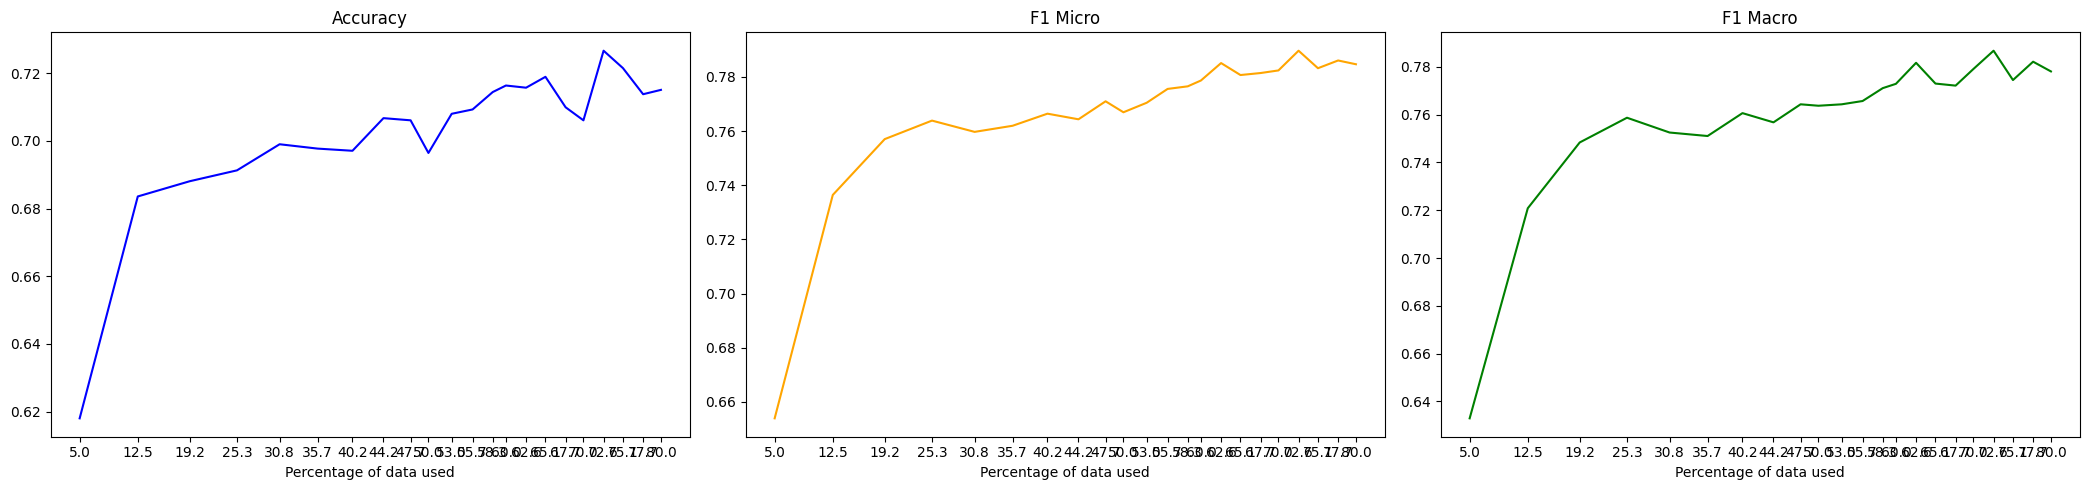

In [18]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.460827,0.440514,0.957447,0.033937,0.065550,0.044738
2,No log,0.398824,0.576849,0.872222,0.236802,0.372479,0.261927
3,No log,0.353225,0.591640,0.830054,0.349925,0.492308,0.420032
4,No log,0.330393,0.585852,0.775510,0.429864,0.553130,0.459224
5,No log,0.314286,0.593569,0.761511,0.486425,0.593649,0.525215
6,No log,0.306425,0.605145,0.788366,0.480392,0.597001,0.545943
7,No log,0.299625,0.612862,0.739634,0.578431,0.649175,0.610205
8,No log,0.297249,0.616720,0.771834,0.533183,0.630687,0.596109
9,No log,0.294833,0.624437,0.772004,0.549020,0.641692,0.603582
10,No log,0.295964,0.617363,0.774123,0.532428,0.630920,0.592582


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.79      0.84       362
                sara       0.74      0.23      0.35       237
         radikalisme       0.68      0.60      0.64       235
pencemaran_nama_baik       0.65      0.58      0.62       492

           micro avg       0.74      0.58      0.65      1326
           macro avg       0.74      0.55      0.61      1326
        weighted avg       0.74      0.58      0.63      1326
         samples avg       0.38      0.34      0.35      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 388: Accuracy: 0.6128617363344051, F1 Micro: 0.649174777824799, F1 Macro: 0.6102054118583491
                      precision    recall  f1-score   support

          pornografi       0.89      0.79      0.84       362
                sara       0.74      0.23      0.35       237
         radikalisme       0.68      0.60      0.64       235
pencemaran_nama_baik       0.65      0.58      0.62       492

           micro avg       0.74      0.58      0.65      1326
           macro avg       0.74      0.55      0.61      1326
        weighted avg       0.74      0.58      0.63      1326
         samples avg       0.38      0.34      0.35      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 583
Acquired samples: 583
Sampling duration: 23.490602731704712 seconds
New train size: 971


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.372372,0.548553,0.823821,0.250377,0.384037,0.263656
2,No log,0.308020,0.615434,0.770396,0.498492,0.605311,0.572273
3,No log,0.278782,0.637942,0.749117,0.639517,0.689992,0.667184
4,No log,0.281475,0.646945,0.685324,0.757164,0.719455,0.714298
5,No log,0.275558,0.661736,0.723356,0.721719,0.722537,0.714951
6,No log,0.280520,0.652733,0.753859,0.662896,0.705457,0.689547
7,No log,0.278667,0.643730,0.729199,0.700603,0.714615,0.701214
8,No log,0.288798,0.652733,0.716296,0.729261,0.722720,0.715209
9,0.248100,0.284464,0.652733,0.742143,0.694570,0.717569,0.703355
10,0.248100,0.288135,0.647588,0.718585,0.720211,0.719397,0.708108


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.86      0.89      0.87       362
                sara       0.61      0.59      0.60       237
         radikalisme       0.66      0.78      0.72       235
pencemaran_nama_baik       0.69      0.65      0.67       492

           micro avg       0.72      0.73      0.72      1326
           macro avg       0.70      0.73      0.72      1326
        weighted avg       0.72      0.73      0.72      1326
         samples avg       0.41      0.41      0.40      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 971: Accuracy: 0.6527331189710611, F1 Micro: 0.7227204783258595, F1 Macro: 0.7152086983082173
                      precision    recall  f1-score   support

          pornografi       0.86      0.89      0.87       362
                sara       0.61      0.59      0.60       237
         radikalisme       0.66      0.78      0.72       235
pencemaran_nama_baik       0.69      0.65      0.67       492

           micro avg       0.72      0.73      0.72      1326
           macro avg       0.70      0.73      0.72      1326
        weighted avg       0.72      0.73      0.72      1326
         samples avg       0.41      0.41      0.40      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 525
Acquired samples: 525
Sampling duration: 20.074289321899414 seconds
New train size: 1496


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.327914,0.589068,0.742009,0.490196,0.590372,0.569344
2,No log,0.277279,0.649518,0.762167,0.625943,0.687371,0.680372
3,No log,0.262214,0.664309,0.724872,0.745098,0.734846,0.732516
4,No log,0.255814,0.682315,0.763710,0.714178,0.738114,0.725774
5,No log,0.259208,0.675884,0.737972,0.751885,0.744864,0.736024
6,0.265200,0.274972,0.673955,0.706977,0.802413,0.751678,0.748223
7,0.265200,0.269288,0.678457,0.743783,0.744344,0.744063,0.731148
8,0.265200,0.279729,0.678457,0.747699,0.735294,0.741445,0.732726
9,0.265200,0.278267,0.681672,0.745673,0.747360,0.746516,0.738563
10,0.265200,0.279409,0.680386,0.743802,0.746606,0.745201,0.738353


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.86      0.90      0.88       362
                sara       0.60      0.71      0.65       237
         radikalisme       0.69      0.82      0.75       235
pencemaran_nama_baik       0.66      0.77      0.71       492

           micro avg       0.71      0.80      0.75      1326
           macro avg       0.70      0.80      0.75      1326
        weighted avg       0.71      0.80      0.75      1326
         samples avg       0.44      0.45      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1496: Accuracy: 0.6739549839228296, F1 Micro: 0.7516778523489934, F1 Macro: 0.7482227589419894
                      precision    recall  f1-score   support

          pornografi       0.86      0.90      0.88       362
                sara       0.60      0.71      0.65       237
         radikalisme       0.69      0.82      0.75       235
pencemaran_nama_baik       0.66      0.77      0.71       492

           micro avg       0.71      0.80      0.75      1326
           macro avg       0.70      0.80      0.75      1326
        weighted avg       0.71      0.80      0.75      1326
         samples avg       0.44      0.45      0.43      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 473
Acquired samples: 473
Sampling duration: 17.75398898124695 seconds
New train size: 1969


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.297038,0.629582,0.795328,0.539216,0.642697,0.595291
2,No log,0.264764,0.637942,0.756734,0.677979,0.715195,0.670036
3,No log,0.254485,0.689389,0.745297,0.776772,0.760709,0.751821
4,No log,0.254211,0.686174,0.741655,0.770739,0.755917,0.749079
5,0.273700,0.254462,0.685531,0.767516,0.726998,0.746708,0.738911
6,0.273700,0.258990,0.690032,0.773934,0.725490,0.748930,0.740317
7,0.273700,0.273658,0.682958,0.744822,0.759427,0.752054,0.743701
8,0.273700,0.280302,0.682958,0.745011,0.760181,0.752520,0.743848
9,0.124300,0.280441,0.681029,0.742524,0.767722,0.754913,0.746054
10,0.124300,0.283043,0.679100,0.744996,0.757919,0.751402,0.742872


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.88      0.90      0.89       362
                sara       0.65      0.60      0.63       237
         radikalisme       0.74      0.79      0.77       235
pencemaran_nama_baik       0.70      0.77      0.73       492

           micro avg       0.75      0.78      0.76      1326
           macro avg       0.74      0.76      0.75      1326
        weighted avg       0.75      0.78      0.76      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1969: Accuracy: 0.6893890675241158, F1 Micro: 0.7607090103397341, F1 Macro: 0.7518209357737502
                      precision    recall  f1-score   support

          pornografi       0.88      0.90      0.89       362
                sara       0.65      0.60      0.63       237
         radikalisme       0.74      0.79      0.77       235
pencemaran_nama_baik       0.70      0.77      0.73       492

           micro avg       0.75      0.78      0.76      1326
           macro avg       0.74      0.76      0.75      1326
        weighted avg       0.75      0.78      0.76      1326
         samples avg       0.44      0.44      0.43      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 425
Acquired samples: 425
Sampling duration: 15.879387140274048 seconds
New train size: 2394


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.281396,0.641801,0.780933,0.580694,0.666090,0.645294
2,No log,0.263672,0.662379,0.827772,0.579940,0.682040,0.637979
3,No log,0.252490,0.682315,0.762969,0.720965,0.741373,0.732934
4,0.280200,0.248245,0.684244,0.774430,0.717195,0.744714,0.728445
5,0.280200,0.264735,0.688746,0.735863,0.775264,0.755050,0.751031
6,0.280200,0.266291,0.688103,0.778974,0.709653,0.742699,0.730426
7,0.139400,0.278346,0.679100,0.736152,0.761689,0.748703,0.737678
8,0.139400,0.284320,0.683601,0.751335,0.742836,0.747061,0.735998
9,0.139400,0.287447,0.686174,0.754601,0.742081,0.748289,0.738782
10,0.084100,0.289636,0.681672,0.742560,0.752640,0.747566,0.737659


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.86      0.89       362
                sara       0.62      0.68      0.65       237
         radikalisme       0.70      0.80      0.75       235
pencemaran_nama_baik       0.69      0.75      0.72       492

           micro avg       0.74      0.78      0.76      1326
           macro avg       0.73      0.77      0.75      1326
        weighted avg       0.74      0.78      0.76      1326
         samples avg       0.42      0.43      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2394: Accuracy: 0.6887459807073955, F1 Micro: 0.7550495776716857, F1 Macro: 0.7510307061006944
                      precision    recall  f1-score   support

          pornografi       0.93      0.86      0.89       362
                sara       0.62      0.68      0.65       237
         radikalisme       0.70      0.80      0.75       235
pencemaran_nama_baik       0.69      0.75      0.72       492

           micro avg       0.74      0.78      0.76      1326
           macro avg       0.73      0.77      0.75      1326
        weighted avg       0.74      0.78      0.76      1326
         samples avg       0.42      0.43      0.42      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 383
Acquired samples: 383
Sampling duration: 13.424089908599854 seconds
New train size: 2777


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.277462,0.656592,0.763751,0.638763,0.695688,0.679706
2,No log,0.252050,0.681672,0.805061,0.647813,0.717927,0.707305
3,0.290300,0.254728,0.675241,0.716488,0.806184,0.758694,0.749757
4,0.290300,0.244533,0.693891,0.781301,0.724736,0.751956,0.739174
5,0.290300,0.265881,0.695177,0.737179,0.780543,0.758242,0.754077
6,0.154500,0.269392,0.694534,0.763566,0.742836,0.753058,0.740085
7,0.154500,0.276899,0.697106,0.757622,0.749623,0.753601,0.743227
8,0.154500,0.292438,0.693891,0.741354,0.776018,0.758290,0.747500
9,0.090500,0.291106,0.695177,0.755071,0.757919,0.756492,0.744955
10,0.090500,0.291739,0.693891,0.758568,0.751131,0.754831,0.743389


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.87      0.91      0.89       362
                sara       0.62      0.65      0.63       237
         radikalisme       0.74      0.75      0.75       235
pencemaran_nama_baik       0.66      0.83      0.73       492

           micro avg       0.72      0.81      0.76      1326
           macro avg       0.72      0.79      0.75      1326
        weighted avg       0.72      0.81      0.76      1326
         samples avg       0.45      0.46      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2777: Accuracy: 0.6752411575562701, F1 Micro: 0.758694109297374, F1 Macro: 0.7497572254520368
                      precision    recall  f1-score   support

          pornografi       0.87      0.91      0.89       362
                sara       0.62      0.65      0.63       237
         radikalisme       0.74      0.75      0.75       235
pencemaran_nama_baik       0.66      0.83      0.73       492

           micro avg       0.72      0.81      0.76      1326
           macro avg       0.72      0.79      0.75      1326
        weighted avg       0.72      0.81      0.76      1326
         samples avg       0.45      0.46      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 345
Acquired samples: 345
Sampling duration: 12.642253160476685 seconds
New train size: 3122


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.270209,0.673955,0.721898,0.745852,0.733680,0.728303
2,No log,0.238705,0.702894,0.790932,0.710407,0.748510,0.739894
3,0.285700,0.238066,0.697106,0.754996,0.769231,0.762047,0.752392
4,0.285700,0.245154,0.707395,0.773292,0.751131,0.762050,0.754174
5,0.285700,0.260214,0.691961,0.740113,0.790347,0.764406,0.757507
6,0.158100,0.263027,0.695820,0.751644,0.776018,0.763636,0.756696
7,0.158100,0.269085,0.704823,0.783719,0.740573,0.761535,0.750437
8,0.097600,0.286329,0.702894,0.752168,0.785068,0.768266,0.760510
9,0.097600,0.288052,0.700322,0.758595,0.765460,0.762012,0.754814
10,0.097600,0.290708,0.702251,0.762763,0.766214,0.764485,0.757340


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.88      0.91      0.90       362
                sara       0.66      0.63      0.64       237
         radikalisme       0.75      0.79      0.77       235
pencemaran_nama_baik       0.70      0.76      0.73       492

           micro avg       0.75      0.79      0.77      1326
           macro avg       0.75      0.77      0.76      1326
        weighted avg       0.75      0.79      0.77      1326
         samples avg       0.44      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3122: Accuracy: 0.7028938906752411, F1 Micro: 0.7682656826568266, F1 Macro: 0.7605095915258222
                      precision    recall  f1-score   support

          pornografi       0.88      0.91      0.90       362
                sara       0.66      0.63      0.64       237
         radikalisme       0.75      0.79      0.77       235
pencemaran_nama_baik       0.70      0.76      0.73       492

           micro avg       0.75      0.79      0.77      1326
           macro avg       0.75      0.77      0.76      1326
        weighted avg       0.75      0.79      0.77      1326
         samples avg       0.44      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 310
Acquired samples: 310
Sampling duration: 10.338341474533081 seconds
New train size: 3432


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.269061,0.671383,0.723389,0.753394,0.738086,0.732229
2,No log,0.247616,0.693891,0.828244,0.654600,0.731255,0.706122
3,0.292800,0.235669,0.699035,0.768934,0.750377,0.759542,0.751027
4,0.292800,0.255149,0.696463,0.726110,0.813725,0.767425,0.762906
5,0.168200,0.251932,0.699678,0.751076,0.789593,0.769853,0.762206
6,0.168200,0.262121,0.702894,0.760950,0.773002,0.766929,0.759460
7,0.109600,0.274069,0.709968,0.773628,0.765460,0.769522,0.759612
8,0.109600,0.283180,0.712540,0.772555,0.768477,0.770510,0.762620
9,0.109600,0.291051,0.708039,0.773967,0.748869,0.761211,0.750815
10,0.074500,0.292264,0.707395,0.768302,0.767722,0.768012,0.758340


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.90       362
                sara       0.67      0.63      0.65       237
         radikalisme       0.74      0.80      0.77       235
pencemaran_nama_baik       0.74      0.72      0.73       492

           micro avg       0.77      0.77      0.77      1326
           macro avg       0.76      0.76      0.76      1326
        weighted avg       0.77      0.77      0.77      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3432: Accuracy: 0.712540192926045, F1 Micro: 0.7705103969754254, F1 Macro: 0.7626196924518843
                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.90       362
                sara       0.67      0.63      0.65       237
         radikalisme       0.74      0.80      0.77       235
pencemaran_nama_baik       0.74      0.72      0.73       492

           micro avg       0.77      0.77      0.77      1326
           macro avg       0.76      0.76      0.76      1326
        weighted avg       0.77      0.77      0.77      1326
         samples avg       0.44      0.44      0.43      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 279
Acquired samples: 279
Sampling duration: 9.102922916412354 seconds
New train size: 3711


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.260769,0.669453,0.802899,0.626697,0.703939,0.697980
2,No log,0.238316,0.695177,0.754844,0.763952,0.759370,0.754234
3,0.295100,0.243037,0.692605,0.763707,0.745852,0.754674,0.739680
4,0.295100,0.237803,0.704823,0.798658,0.717949,0.756156,0.743174
5,0.171300,0.254957,0.711897,0.763930,0.785822,0.774721,0.768082
6,0.171300,0.275246,0.706752,0.760709,0.776772,0.768657,0.761120
7,0.112800,0.275567,0.710611,0.763292,0.790347,0.776584,0.771239
8,0.112800,0.295725,0.706109,0.751079,0.787330,0.768778,0.762905
9,0.079700,0.294249,0.704180,0.767020,0.764706,0.765861,0.754183
10,0.079700,0.297940,0.708039,0.760790,0.784314,0.772373,0.763719


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.91       362
                sara       0.65      0.66      0.66       237
         radikalisme       0.75      0.82      0.78       235
pencemaran_nama_baik       0.72      0.75      0.74       492

           micro avg       0.76      0.79      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3711: Accuracy: 0.7106109324758842, F1 Micro: 0.7765839199703594, F1 Macro: 0.7712393205295713
                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.91       362
                sara       0.65      0.66      0.66       237
         radikalisme       0.75      0.82      0.78       235
pencemaran_nama_baik       0.72      0.75      0.74       492

           micro avg       0.76      0.79      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 251
Acquired samples: 175
Sampling duration: 7.689352035522461 seconds
New train size: 3886


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.269259,0.666238,0.726070,0.703620,0.714669,0.716006
2,No log,0.236838,0.697106,0.770324,0.736048,0.752796,0.738700
3,0.295100,0.250176,0.682315,0.729412,0.794872,0.760736,0.754268
4,0.295100,0.246100,0.702251,0.774094,0.757164,0.765536,0.753299
5,0.180400,0.269602,0.691318,0.734906,0.798643,0.765450,0.759032
6,0.180400,0.266647,0.697106,0.763815,0.760935,0.762372,0.753867
7,0.119300,0.283004,0.702894,0.752688,0.791855,0.771775,0.766252
8,0.119300,0.291036,0.703537,0.759354,0.780543,0.769803,0.765897
9,0.083200,0.295188,0.700965,0.752547,0.779789,0.765926,0.760454
10,0.083200,0.297013,0.699678,0.760448,0.768477,0.764441,0.757525


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.92      0.90       362
                sara       0.67      0.63      0.65       237
         radikalisme       0.75      0.83      0.79       235
pencemaran_nama_baik       0.69      0.76      0.72       492

           micro avg       0.75      0.79      0.77      1326
           macro avg       0.75      0.78      0.77      1326
        weighted avg       0.75      0.79      0.77      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3886: Accuracy: 0.7028938906752411, F1 Micro: 0.7717750826901872, F1 Macro: 0.7662520275436775
                      precision    recall  f1-score   support

          pornografi       0.89      0.92      0.90       362
                sara       0.67      0.63      0.65       237
         radikalisme       0.75      0.83      0.79       235
pencemaran_nama_baik       0.69      0.76      0.72       492

           micro avg       0.75      0.79      0.77      1326
           macro avg       0.75      0.78      0.77      1326
        weighted avg       0.75      0.79      0.77      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 7.479095458984375 seconds
New train size: 4120


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.254912,0.678457,0.771667,0.698341,0.733175,0.723301
2,0.299900,0.240618,0.694534,0.784396,0.705128,0.742653,0.734959
3,0.299900,0.239434,0.703537,0.736044,0.805430,0.769175,0.762730
4,0.181600,0.238208,0.703537,0.775875,0.751885,0.763692,0.751674
5,0.181600,0.251496,0.709968,0.802179,0.721719,0.759825,0.748266
6,0.125100,0.266029,0.709968,0.792763,0.726998,0.758458,0.744193
7,0.125100,0.280982,0.706109,0.763079,0.769985,0.766517,0.757445
8,0.085500,0.295551,0.712540,0.757184,0.794872,0.775570,0.770372
9,0.085500,0.299468,0.716399,0.770677,0.773002,0.771837,0.764331
10,0.065700,0.300148,0.713183,0.766117,0.770739,0.768421,0.760172


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.92      0.91       362
                sara       0.64      0.67      0.65       237
         radikalisme       0.76      0.83      0.79       235
pencemaran_nama_baik       0.72      0.75      0.73       492

           micro avg       0.76      0.79      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4120: Accuracy: 0.712540192926045, F1 Micro: 0.775570272259014, F1 Macro: 0.7703721715350077
                      precision    recall  f1-score   support

          pornografi       0.89      0.92      0.91       362
                sara       0.64      0.67      0.65       237
         radikalisme       0.76      0.83      0.79       235
pencemaran_nama_baik       0.72      0.75      0.73       492

           micro avg       0.76      0.79      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 6.743224382400513 seconds
New train size: 4330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.255983,0.684887,0.774707,0.697587,0.734127,0.723419
2,0.300700,0.238336,0.693248,0.755894,0.749623,0.752745,0.739203
3,0.300700,0.233283,0.701608,0.750179,0.788084,0.768665,0.765118
4,0.184500,0.242587,0.709968,0.808696,0.701357,0.751212,0.731836
5,0.184500,0.257895,0.694534,0.745196,0.789593,0.766752,0.757095
6,0.128100,0.263825,0.707395,0.782504,0.735294,0.758165,0.748370
7,0.128100,0.294862,0.705466,0.752547,0.779789,0.765926,0.756555
8,0.090700,0.311956,0.703537,0.745416,0.797134,0.770408,0.765305
9,0.090700,0.305060,0.708682,0.771807,0.747360,0.759387,0.748805
10,0.066200,0.309703,0.702251,0.752967,0.765460,0.759162,0.750335


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.62      0.67      0.64       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.70      0.75      0.73       492

           micro avg       0.75      0.80      0.77      1326
           macro avg       0.74      0.79      0.77      1326
        weighted avg       0.75      0.80      0.77      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4330: Accuracy: 0.7035369774919614, F1 Micro: 0.7704081632653063, F1 Macro: 0.7653047872550273
                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.62      0.67      0.64       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.70      0.75      0.73       492

           micro avg       0.75      0.80      0.77      1326
           macro avg       0.74      0.79      0.77      1326
        weighted avg       0.75      0.80      0.77      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Samples above threshold: 189
Acquired samples: 200
Sampling duration: 6.011000156402588 seconds
New train size: 4530


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.261880,0.672026,0.742792,0.738311,0.740545,0.724244
2,0.304900,0.234551,0.690032,0.779136,0.720965,0.748923,0.733265
3,0.304900,0.239962,0.702894,0.730276,0.816742,0.771093,0.766753
4,0.191100,0.241151,0.706109,0.761406,0.767722,0.764551,0.755338
5,0.191100,0.247087,0.708039,0.783359,0.752640,0.767692,0.756404
6,0.136900,0.272373,0.709325,0.751061,0.800905,0.775182,0.771632
7,0.136900,0.277391,0.709325,0.771167,0.762443,0.766780,0.759472
8,0.096400,0.288116,0.714469,0.768084,0.776772,0.772403,0.767795
9,0.071400,0.298495,0.715113,0.762182,0.790347,0.776009,0.770309
10,0.071400,0.295984,0.719614,0.773543,0.780543,0.777027,0.770135


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.67      0.62      0.65       237
         radikalisme       0.74      0.84      0.79       235
pencemaran_nama_baik       0.73      0.73      0.73       492

           micro avg       0.77      0.78      0.78      1326
           macro avg       0.77      0.78      0.77      1326
        weighted avg       0.77      0.78      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4530: Accuracy: 0.7196141479099678, F1 Micro: 0.777027027027027, F1 Macro: 0.7701348794206843
                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.67      0.62      0.65       237
         radikalisme       0.74      0.84      0.79       235
pencemaran_nama_baik       0.73      0.73      0.73       492

           micro avg       0.77      0.78      0.78      1326
           macro avg       0.77      0.78      0.77      1326
        weighted avg       0.77      0.78      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Samples above threshold: 169
Acquired samples: 133
Sampling duration: 5.185138702392578 seconds
New train size: 4663


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.250277,0.682958,0.773978,0.699849,0.735050,0.718104
2,0.302200,0.230299,0.699678,0.770312,0.743590,0.756715,0.742908
3,0.302200,0.240525,0.695177,0.734597,0.818250,0.774171,0.765992
4,0.193000,0.234814,0.708682,0.776929,0.766968,0.771917,0.761055
5,0.193000,0.252358,0.706752,0.776471,0.746606,0.761246,0.753484
6,0.139800,0.271281,0.707395,0.752696,0.789593,0.770703,0.762882
7,0.099100,0.288483,0.709968,0.743945,0.810709,0.775893,0.771662
8,0.099100,0.295922,0.708039,0.762332,0.769231,0.765766,0.755399
9,0.073300,0.303890,0.709968,0.758266,0.778281,0.768143,0.759602
10,0.073300,0.308936,0.706752,0.754373,0.780543,0.767235,0.759687


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.91      0.90       362
                sara       0.63      0.69      0.66       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.70      0.77      0.74       492

           micro avg       0.74      0.81      0.78      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4663: Accuracy: 0.7099678456591639, F1 Micro: 0.7758931793576327, F1 Macro: 0.771661542563622
                      precision    recall  f1-score   support

          pornografi       0.89      0.91      0.90       362
                sara       0.63      0.69      0.66       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.70      0.77      0.74       492

           micro avg       0.74      0.81      0.78      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Samples above threshold: 156
Acquired samples: 200
Sampling duration: 5.126023530960083 seconds
New train size: 4863


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.246795,0.692605,0.760563,0.733032,0.746544,0.730175
2,0.302800,0.251582,0.679100,0.695971,0.859729,0.769231,0.766740
3,0.302800,0.225590,0.711897,0.790193,0.741327,0.764981,0.754381
4,0.197300,0.236636,0.704180,0.773039,0.765460,0.769231,0.761984
5,0.144000,0.254707,0.702251,0.770898,0.751131,0.760886,0.749912
6,0.144000,0.269662,0.711254,0.760234,0.784314,0.772086,0.764287
7,0.102600,0.277483,0.717042,0.779141,0.766214,0.772624,0.761297
8,0.102600,0.291599,0.713826,0.768429,0.778281,0.773323,0.767032
9,0.076200,0.299753,0.707395,0.761205,0.781297,0.771120,0.765276
10,0.063900,0.301875,0.706109,0.762082,0.773002,0.767503,0.760934


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.92      0.91       362
                sara       0.67      0.62      0.65       237
         radikalisme       0.75      0.83      0.79       235
pencemaran_nama_baik       0.72      0.73      0.72       492

           micro avg       0.77      0.78      0.77      1326
           macro avg       0.76      0.77      0.77      1326
        weighted avg       0.77      0.78      0.77      1326
         samples avg       0.45      0.44      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4863: Accuracy: 0.7138263665594855, F1 Micro: 0.7733233420756838, F1 Macro: 0.7670320850293446
                      precision    recall  f1-score   support

          pornografi       0.90      0.92      0.91       362
                sara       0.67      0.62      0.65       237
         radikalisme       0.75      0.83      0.79       235
pencemaran_nama_baik       0.72      0.73      0.72       492

           micro avg       0.77      0.78      0.77      1326
           macro avg       0.76      0.77      0.77      1326
        weighted avg       0.77      0.78      0.77      1326
         samples avg       0.45      0.44      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Samples above threshold: 136
Acquired samples: 200
Sampling duration: 4.353994369506836 seconds
New train size: 5063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.246566,0.689389,0.757088,0.745098,0.751045,0.744924
2,0.301600,0.236230,0.695177,0.826756,0.647813,0.726427,0.705105
3,0.301600,0.223359,0.718971,0.772829,0.785068,0.778900,0.774513
4,0.199500,0.229264,0.722830,0.788700,0.768477,0.778457,0.766826
5,0.147700,0.240818,0.717685,0.795161,0.743590,0.768511,0.759508
6,0.147700,0.260171,0.723473,0.811352,0.733032,0.770206,0.757091
7,0.108700,0.277045,0.707395,0.760901,0.789593,0.774981,0.768320
8,0.083300,0.295346,0.705466,0.750354,0.800151,0.774453,0.768500
9,0.083300,0.295046,0.708682,0.765706,0.781297,0.773423,0.767086
10,0.066500,0.298212,0.709325,0.763120,0.789593,0.776130,0.770431


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.88      0.91       362
                sara       0.65      0.67      0.66       237
         radikalisme       0.75      0.83      0.79       235
pencemaran_nama_baik       0.73      0.75      0.74       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.77      0.78      0.77      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.44      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5063: Accuracy: 0.7189710610932476, F1 Micro: 0.7789001122334456, F1 Macro: 0.7745128535123158
                      precision    recall  f1-score   support

          pornografi       0.94      0.88      0.91       362
                sara       0.65      0.67      0.66       237
         radikalisme       0.75      0.83      0.79       235
pencemaran_nama_baik       0.73      0.75      0.74       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.77      0.78      0.77      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.44      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 3.770887851715088 seconds
New train size: 5263


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.247570,0.684244,0.742754,0.773002,0.757576,0.751431
2,0.303500,0.233101,0.709325,0.758870,0.790347,0.774289,0.768707
3,0.303500,0.228325,0.702251,0.758521,0.788839,0.773383,0.763090
4,0.202600,0.234342,0.713183,0.758941,0.800151,0.779001,0.774066
5,0.146300,0.247241,0.715113,0.758645,0.810709,0.783813,0.778661
6,0.146300,0.267786,0.713183,0.761043,0.792609,0.776505,0.770858
7,0.110500,0.285502,0.706109,0.754636,0.797888,0.775660,0.769526
8,0.077100,0.290783,0.713183,0.768889,0.782805,0.775785,0.769459
9,0.077100,0.295598,0.712540,0.771174,0.782805,0.776946,0.769334
10,0.065900,0.300199,0.709325,0.763939,0.795626,0.779461,0.774845


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.64      0.69      0.66       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.72      0.77      0.75       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.76      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5263: Accuracy: 0.715112540192926, F1 Micro: 0.7838133430550491, F1 Macro: 0.7786605859263926
                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.64      0.69      0.66       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.72      0.77      0.75       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.76      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 3.2532336711883545 seconds
New train size: 5441


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.241730,0.702251,0.770833,0.725490,0.747475,0.741185
2,0.301000,0.221789,0.715756,0.775744,0.766968,0.771331,0.759053
3,0.208600,0.222662,0.715756,0.801141,0.741327,0.770074,0.759844
4,0.208600,0.244237,0.705466,0.736913,0.828054,0.779830,0.774339
5,0.153100,0.263720,0.706752,0.742507,0.822021,0.780243,0.772847
6,0.113500,0.277405,0.714469,0.753338,0.808446,0.779920,0.773225
7,0.113500,0.291943,0.708039,0.749472,0.803167,0.775391,0.768487
8,0.089400,0.297110,0.709968,0.749655,0.819759,0.783141,0.779728
9,0.066800,0.311121,0.704823,0.746853,0.805430,0.775036,0.769320
10,0.066800,0.302910,0.709968,0.765007,0.788084,0.776374,0.770803


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.63      0.72      0.67       237
         radikalisme       0.74      0.83      0.79       235
pencemaran_nama_baik       0.70      0.79      0.74       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.75      0.82      0.78      1326
        weighted avg       0.75      0.82      0.79      1326
         samples avg       0.46      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5441: Accuracy: 0.7099678456591639, F1 Micro: 0.7831412103746398, F1 Macro: 0.7797276052342316
                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.63      0.72      0.67       237
         radikalisme       0.74      0.83      0.79       235
pencemaran_nama_baik       0.70      0.79      0.74       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.75      0.82      0.78      1326
        weighted avg       0.75      0.82      0.79      1326
         samples avg       0.46      0.47      0.46      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Samples above threshold: 78
Acquired samples: 200
Sampling duration: 2.760442018508911 seconds
New train size: 5641


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.244240,0.693248,0.784497,0.694570,0.736800,0.725921
2,0.308100,0.226640,0.714469,0.780047,0.748869,0.764140,0.756011
3,0.203700,0.224718,0.706752,0.773684,0.776018,0.774849,0.759513
4,0.203700,0.228795,0.728617,0.782738,0.793363,0.788015,0.779602
5,0.162000,0.247420,0.716399,0.769511,0.795626,0.782351,0.776123
6,0.117500,0.258940,0.717685,0.779893,0.772247,0.776052,0.763873
7,0.117500,0.271824,0.713826,0.763402,0.805430,0.783853,0.777132
8,0.092900,0.281335,0.715113,0.767923,0.783560,0.775663,0.768813
9,0.068800,0.290687,0.717042,0.770540,0.785068,0.777736,0.771873
10,0.059700,0.292426,0.719614,0.779712,0.776772,0.778240,0.770499


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.75      0.84      0.79       235
pencemaran_nama_baik       0.75      0.76      0.76       492

           micro avg       0.78      0.79      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.79      1326
         samples avg       0.46      0.45      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5641: Accuracy: 0.7286173633440515, F1 Micro: 0.7880149812734083, F1 Macro: 0.7796018818041107
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.75      0.84      0.79       235
pencemaran_nama_baik       0.75      0.76      0.76       492

           micro avg       0.78      0.79      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.79      1326
         samples avg       0.46      0.45      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Samples above threshold: 58
Acquired samples: 200
Sampling duration: 2.169806480407715 seconds
New train size: 5841


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.239978,0.695820,0.770998,0.733786,0.751932,0.747682
2,0.305800,0.221767,0.711897,0.763971,0.783560,0.773641,0.760311
3,0.203800,0.220209,0.724116,0.780924,0.790347,0.785607,0.777862
4,0.203800,0.227305,0.732476,0.820132,0.749623,0.783294,0.769735
5,0.160000,0.242516,0.714469,0.768950,0.795626,0.782061,0.772336
6,0.117700,0.256250,0.725402,0.789433,0.777526,0.783435,0.774646
7,0.092400,0.276712,0.714469,0.766571,0.802413,0.784083,0.777484
8,0.092400,0.295172,0.712540,0.754584,0.806938,0.779883,0.772917
9,0.069900,0.300970,0.717042,0.759207,0.808446,0.783053,0.775503
10,0.060300,0.298432,0.718328,0.767896,0.800905,0.784053,0.777402


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.66      0.64      0.65       237
         radikalisme       0.75      0.85      0.80       235
pencemaran_nama_baik       0.75      0.76      0.75       492

           micro avg       0.78      0.79      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5841: Accuracy: 0.7241157556270097, F1 Micro: 0.7856071964017991, F1 Macro: 0.777862456705172
                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.66      0.64      0.65       237
         radikalisme       0.75      0.85      0.80       235
pencemaran_nama_baik       0.75      0.76      0.75       492

           micro avg       0.78      0.79      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 1.559753179550171 seconds
New train size: 6041


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.241562,0.702251,0.761171,0.745098,0.753049,0.747968
2,0.301300,0.247141,0.706109,0.721576,0.842383,0.777314,0.772562
3,0.203900,0.217819,0.726688,0.800158,0.763952,0.781636,0.768246
4,0.161900,0.235989,0.733119,0.779155,0.806184,0.792439,0.786503
5,0.161900,0.264961,0.714469,0.735139,0.839367,0.783803,0.779441
6,0.122400,0.267686,0.720900,0.771636,0.800151,0.785635,0.777802
7,0.091700,0.283032,0.719614,0.762931,0.800905,0.781457,0.774984
8,0.075700,0.286973,0.716399,0.771199,0.795626,0.783222,0.776394
9,0.075700,0.299031,0.720257,0.768064,0.801659,0.784502,0.777580
10,0.059200,0.306129,0.724116,0.763083,0.813725,0.787591,0.782012


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.63      0.72      0.67       237
         radikalisme       0.73      0.88      0.79       235
pencemaran_nama_baik       0.78      0.75      0.76       492

           micro avg       0.78      0.81      0.79      1326
           macro avg       0.77      0.81      0.79      1326
        weighted avg       0.79      0.81      0.79      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6041: Accuracy: 0.7331189710610932, F1 Micro: 0.792438843587843, F1 Macro: 0.7865025774475751
                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.63      0.72      0.67       237
         radikalisme       0.73      0.88      0.79       235
pencemaran_nama_baik       0.78      0.75      0.76       492

           micro avg       0.78      0.81      0.79      1326
           macro avg       0.77      0.81      0.79      1326
        weighted avg       0.79      0.81      0.79      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/tmp/ipykernel_23/2933288740.py:54: ConvergenceWarning: Number of distinct clusters (77) found smaller than n_clusters (177). Possibly due to duplicate points in X.
  kmeans.fit(embeddings)


Nearest checkpoint: 6218
Samples above threshold: 18
Acquired samples: 177
Sampling duration: 1.52840256690979 seconds
New train size: 6218


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.243942,0.700322,0.716634,0.822021,0.765718,0.762323
2,0.298500,0.225264,0.713183,0.765146,0.771493,0.768306,0.758875
3,0.205300,0.223437,0.720257,0.759062,0.805430,0.781559,0.775947
4,0.155900,0.237479,0.717685,0.782002,0.760181,0.770937,0.765970
5,0.155900,0.262386,0.711897,0.739772,0.831825,0.783103,0.776382
6,0.121600,0.257708,0.721543,0.784722,0.766968,0.775744,0.766426
7,0.094000,0.279469,0.724116,0.781983,0.779035,0.780506,0.772426
8,0.073700,0.295487,0.713826,0.768095,0.784314,0.776119,0.767301
9,0.058900,0.303426,0.723473,0.770132,0.793363,0.781575,0.773845
10,0.058900,0.309892,0.720900,0.765262,0.794118,0.779423,0.772096


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.93      0.91       362
                sara       0.66      0.65      0.66       237
         radikalisme       0.74      0.86      0.79       235
pencemaran_nama_baik       0.68      0.83      0.75       492

           micro avg       0.74      0.83      0.78      1326
           macro avg       0.74      0.82      0.78      1326
        weighted avg       0.74      0.83      0.78      1326
         samples avg       0.47      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6218: Accuracy: 0.7118971061093248, F1 Micro: 0.7831025914093007, F1 Macro: 0.7763824590685313
                      precision    recall  f1-score   support

          pornografi       0.89      0.93      0.91       362
                sara       0.66      0.65      0.66       237
         radikalisme       0.74      0.86      0.79       235
pencemaran_nama_baik       0.68      0.83      0.75       492

           micro avg       0.74      0.83      0.78      1326
           macro avg       0.74      0.82      0.78      1326
        weighted avg       0.74      0.83      0.78      1326
         samples avg       0.47      0.47      0.46      1326

Total sampling time: 180.34 seconds
Total runtime: 11331.59144449234 seconds


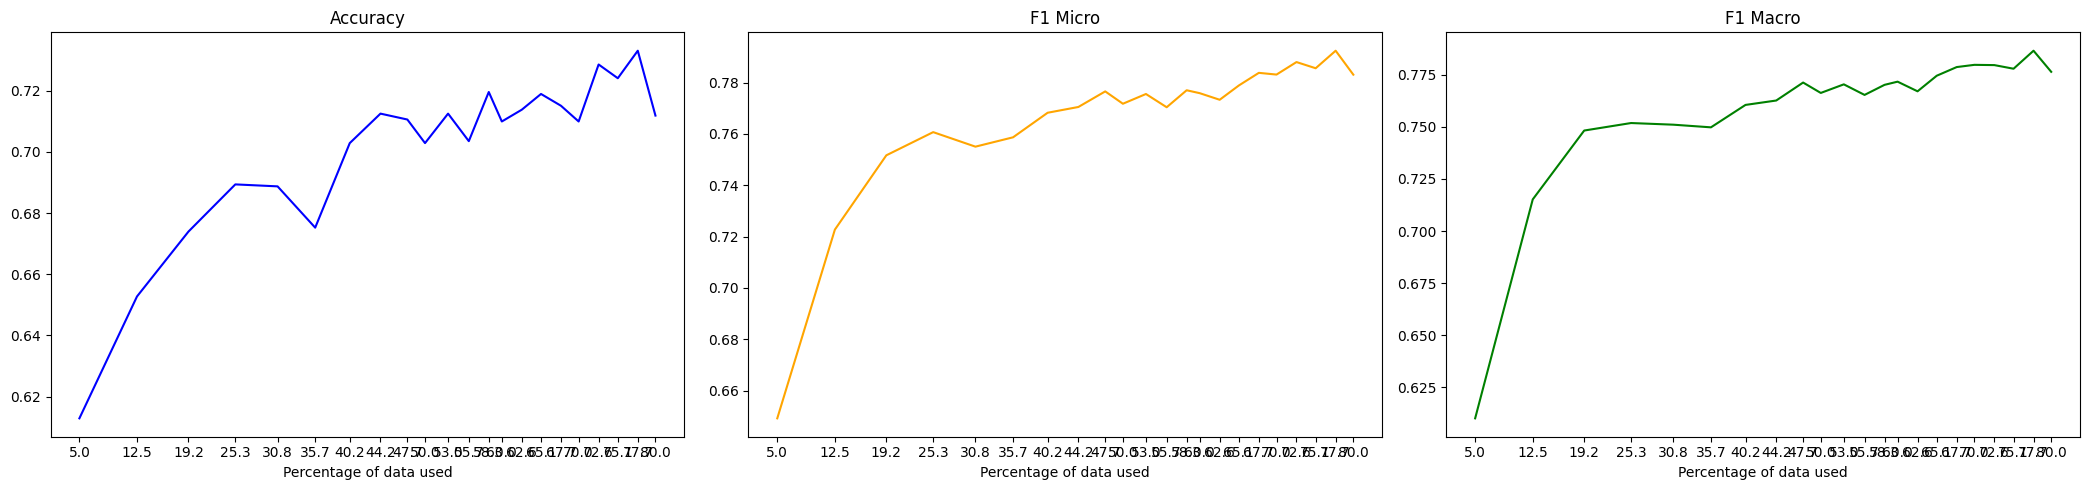

In [19]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.466312,0.447588,1.000000,0.012821,0.025316,0.022427
2,No log,0.392322,0.554984,0.920290,0.191554,0.317104,0.211713
3,No log,0.349551,0.584566,0.834646,0.319759,0.462377,0.381456
4,No log,0.331326,0.586495,0.799035,0.374811,0.510267,0.438305
5,No log,0.317812,0.590997,0.812303,0.388386,0.525510,0.465296
6,No log,0.312626,0.603859,0.802213,0.437406,0.566130,0.506563
7,No log,0.301693,0.610289,0.758030,0.533937,0.626549,0.600378
8,No log,0.300017,0.610932,0.759957,0.532428,0.626164,0.598342
9,No log,0.301048,0.610289,0.765419,0.524133,0.622202,0.587982
10,No log,0.300751,0.610289,0.768632,0.521116,0.621124,0.587391


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.81      0.86       362
                sara       0.64      0.25      0.36       237
         radikalisme       0.68      0.66      0.67       235
pencemaran_nama_baik       0.69      0.41      0.51       492

           micro avg       0.76      0.53      0.63      1326
           macro avg       0.73      0.53      0.60      1326
        weighted avg       0.74      0.53      0.61      1326
         samples avg       0.35      0.31      0.32      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 388: Accuracy: 0.6102893890675242, F1 Micro: 0.6265486725663717, F1 Macro: 0.6003779383425171
                      precision    recall  f1-score   support

          pornografi       0.91      0.81      0.86       362
                sara       0.64      0.25      0.36       237
         radikalisme       0.68      0.66      0.67       235
pencemaran_nama_baik       0.69      0.41      0.51       492

           micro avg       0.76      0.53      0.63      1326
           macro avg       0.73      0.53      0.60      1326
        weighted avg       0.74      0.53      0.61      1326
         samples avg       0.35      0.31      0.32      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 583
Acquired samples: 583
Sampling duration: 24.094300985336304 seconds
New train size: 971


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.367995,0.552412,0.811151,0.340121,0.479277,0.413277
2,No log,0.300600,0.631511,0.789644,0.552036,0.649800,0.616700
3,No log,0.276656,0.657878,0.742175,0.679487,0.709449,0.691819
4,No log,0.271861,0.653376,0.744681,0.686275,0.714286,0.692515
5,No log,0.272504,0.679100,0.763970,0.690799,0.725545,0.711017
6,No log,0.273279,0.667524,0.725291,0.752640,0.738712,0.729352
7,No log,0.273450,0.667524,0.753623,0.705882,0.728972,0.711928
8,No log,0.274310,0.676527,0.743884,0.733786,0.738800,0.726704
9,0.234800,0.275330,0.686174,0.761218,0.716440,0.738151,0.725207
10,0.234800,0.276002,0.680386,0.752561,0.720211,0.736031,0.723839


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.88      0.90      0.89       362
                sara       0.67      0.50      0.57       237
         radikalisme       0.74      0.77      0.76       235
pencemaran_nama_baik       0.67      0.71      0.69       492

           micro avg       0.74      0.73      0.74      1326
           macro avg       0.74      0.72      0.73      1326
        weighted avg       0.74      0.73      0.73      1326
         samples avg       0.41      0.41      0.40      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 971: Accuracy: 0.6765273311897106, F1 Micro: 0.738800303720577, F1 Macro: 0.726703798338853
                      precision    recall  f1-score   support

          pornografi       0.88      0.90      0.89       362
                sara       0.67      0.50      0.57       237
         radikalisme       0.74      0.77      0.76       235
pencemaran_nama_baik       0.67      0.71      0.69       492

           micro avg       0.74      0.73      0.74      1326
           macro avg       0.74      0.72      0.73      1326
        weighted avg       0.74      0.73      0.73      1326
         samples avg       0.41      0.41      0.40      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 525
Acquired samples: 525
Sampling duration: 20.48665165901184 seconds
New train size: 1496


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.319652,0.581350,0.740175,0.511312,0.604817,0.584831
2,No log,0.275322,0.650804,0.764212,0.618401,0.683618,0.671009
3,No log,0.261600,0.677170,0.786988,0.665913,0.721405,0.703355
4,No log,0.260989,0.679743,0.768852,0.707391,0.736842,0.721041
5,No log,0.263222,0.683601,0.810861,0.653092,0.723475,0.703338
6,0.261100,0.272116,0.686817,0.745738,0.758673,0.752150,0.743063
7,0.261100,0.267527,0.690675,0.777143,0.717949,0.746374,0.735481
8,0.261100,0.273701,0.692605,0.774659,0.728507,0.750874,0.741463
9,0.261100,0.279145,0.685531,0.755796,0.737557,0.746565,0.737303
10,0.261100,0.280913,0.684887,0.766161,0.723982,0.744475,0.732919


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.88      0.88       362
                sara       0.65      0.58      0.61       237
         radikalisme       0.74      0.77      0.75       235
pencemaran_nama_baik       0.69      0.75      0.72       492

           micro avg       0.75      0.76      0.75      1326
           macro avg       0.74      0.75      0.74      1326
        weighted avg       0.75      0.76      0.75      1326
         samples avg       0.43      0.43      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1496: Accuracy: 0.6868167202572347, F1 Micro: 0.7521495327102804, F1 Macro: 0.7430626719291655
                      precision    recall  f1-score   support

          pornografi       0.89      0.88      0.88       362
                sara       0.65      0.58      0.61       237
         radikalisme       0.74      0.77      0.75       235
pencemaran_nama_baik       0.69      0.75      0.72       492

           micro avg       0.75      0.76      0.75      1326
           macro avg       0.74      0.75      0.74      1326
        weighted avg       0.75      0.76      0.75      1326
         samples avg       0.43      0.43      0.42      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 473
Acquired samples: 473
Sampling duration: 18.438194274902344 seconds
New train size: 1969


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.305817,0.591640,0.802778,0.435897,0.565005,0.557861
2,No log,0.269286,0.667524,0.789374,0.627451,0.699160,0.685631
3,No log,0.259373,0.690675,0.737418,0.762443,0.749722,0.742622
4,No log,0.256705,0.683601,0.745902,0.754902,0.750375,0.738269
5,0.273900,0.259033,0.693891,0.756353,0.763198,0.759760,0.750294
6,0.273900,0.261640,0.695820,0.757807,0.750377,0.754074,0.746143
7,0.273900,0.269478,0.699035,0.764165,0.752640,0.758359,0.749517
8,0.273900,0.275213,0.701608,0.774347,0.737557,0.755504,0.746022
9,0.125200,0.286782,0.699678,0.761149,0.759427,0.760287,0.750758
10,0.125200,0.287022,0.695177,0.753698,0.768477,0.761016,0.753093


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.88      0.90      0.89       362
                sara       0.66      0.62      0.64       237
         radikalisme       0.72      0.80      0.76       235
pencemaran_nama_baik       0.72      0.73      0.72       492

           micro avg       0.75      0.77      0.76      1326
           macro avg       0.75      0.76      0.75      1326
        weighted avg       0.75      0.77      0.76      1326
         samples avg       0.43      0.43      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1969: Accuracy: 0.6951768488745981, F1 Micro: 0.7610156833457805, F1 Macro: 0.753093287969983
                      precision    recall  f1-score   support

          pornografi       0.88      0.90      0.89       362
                sara       0.66      0.62      0.64       237
         radikalisme       0.72      0.80      0.76       235
pencemaran_nama_baik       0.72      0.73      0.72       492

           micro avg       0.75      0.77      0.76      1326
           macro avg       0.75      0.76      0.75      1326
        weighted avg       0.75      0.77      0.76      1326
         samples avg       0.43      0.43      0.42      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 425
Acquired samples: 425
Sampling duration: 15.591101884841919 seconds
New train size: 2394


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.289629,0.634727,0.820789,0.518100,0.635229,0.612262
2,No log,0.253698,0.686174,0.744444,0.757919,0.751121,0.743195
3,No log,0.244899,0.686174,0.756818,0.753394,0.755102,0.745346
4,0.282500,0.250117,0.699678,0.760606,0.757164,0.758881,0.751010
5,0.282500,0.256677,0.698392,0.775753,0.738311,0.756569,0.742029
6,0.282500,0.268641,0.700965,0.812050,0.680995,0.740771,0.725108
7,0.138100,0.277516,0.690032,0.732962,0.794872,0.762663,0.755914
8,0.138100,0.276155,0.699035,0.748364,0.776018,0.761940,0.756824
9,0.138100,0.285873,0.698392,0.750550,0.771493,0.760878,0.753441
10,0.083900,0.286735,0.700965,0.749269,0.773002,0.760950,0.753742


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.90      0.89       362
                sara       0.62      0.65      0.63       237
         radikalisme       0.71      0.83      0.77       235
pencemaran_nama_baik       0.69      0.77      0.73       492

           micro avg       0.73      0.79      0.76      1326
           macro avg       0.73      0.79      0.76      1326
        weighted avg       0.74      0.79      0.76      1326
         samples avg       0.44      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2394: Accuracy: 0.690032154340836, F1 Micro: 0.7626628075253256, F1 Macro: 0.7559142476309886
                      precision    recall  f1-score   support

          pornografi       0.89      0.90      0.89       362
                sara       0.62      0.65      0.63       237
         radikalisme       0.71      0.83      0.77       235
pencemaran_nama_baik       0.69      0.77      0.73       492

           micro avg       0.73      0.79      0.76      1326
           macro avg       0.73      0.79      0.76      1326
        weighted avg       0.74      0.79      0.76      1326
         samples avg       0.44      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 383
Acquired samples: 383
Sampling duration: 13.779268026351929 seconds
New train size: 2777


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.276500,0.666881,0.746135,0.691554,0.717808,0.707862
2,No log,0.251180,0.677814,0.809432,0.634238,0.711205,0.699672
3,0.290300,0.240828,0.690675,0.776683,0.713424,0.743711,0.732127
4,0.290300,0.252804,0.692605,0.750000,0.771493,0.760595,0.752210
5,0.290300,0.257477,0.696463,0.773659,0.739819,0.756361,0.747853
6,0.150800,0.270083,0.692605,0.753915,0.762443,0.758155,0.751480
7,0.150800,0.280707,0.691961,0.760305,0.751131,0.755690,0.746799
8,0.150800,0.281806,0.705466,0.768589,0.763952,0.766263,0.759120
9,0.091000,0.292876,0.703537,0.757396,0.772247,0.764750,0.757313
10,0.091000,0.294560,0.704823,0.760208,0.772247,0.766180,0.757940


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.89      0.90       362
                sara       0.69      0.61      0.65       237
         radikalisme       0.73      0.80      0.76       235
pencemaran_nama_baik       0.72      0.73      0.72       492

           micro avg       0.77      0.76      0.77      1326
           macro avg       0.76      0.76      0.76      1326
        weighted avg       0.77      0.76      0.77      1326
         samples avg       0.43      0.43      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2777: Accuracy: 0.7054662379421222, F1 Micro: 0.7662632375189108, F1 Macro: 0.7591198488605666
                      precision    recall  f1-score   support

          pornografi       0.92      0.89      0.90       362
                sara       0.69      0.61      0.65       237
         radikalisme       0.73      0.80      0.76       235
pencemaran_nama_baik       0.72      0.73      0.72       492

           micro avg       0.77      0.76      0.77      1326
           macro avg       0.76      0.76      0.76      1326
        weighted avg       0.77      0.76      0.77      1326
         samples avg       0.43      0.43      0.42      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 345
Acquired samples: 345
Sampling duration: 12.02547812461853 seconds
New train size: 3122


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.273796,0.660450,0.715751,0.736802,0.726124,0.716310
2,No log,0.241035,0.690032,0.785896,0.697587,0.739113,0.717501
3,0.292400,0.240119,0.703537,0.780744,0.727753,0.753318,0.742883
4,0.292400,0.244942,0.702251,0.765329,0.762443,0.763884,0.756322
5,0.292400,0.263510,0.693891,0.736589,0.807692,0.770504,0.762148
6,0.159500,0.262945,0.700322,0.763910,0.766214,0.765060,0.756347
7,0.159500,0.281590,0.708039,0.765015,0.768477,0.766742,0.759779
8,0.097600,0.287005,0.707395,0.755636,0.783560,0.769345,0.762492
9,0.097600,0.292586,0.700965,0.761183,0.757164,0.759168,0.750785
10,0.097600,0.291769,0.706109,0.764087,0.766968,0.765525,0.757823


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.88      0.90       362
                sara       0.64      0.63      0.63       237
         radikalisme       0.73      0.82      0.77       235
pencemaran_nama_baik       0.68      0.83      0.75       492

           micro avg       0.74      0.81      0.77      1326
           macro avg       0.74      0.79      0.76      1326
        weighted avg       0.74      0.81      0.77      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3122: Accuracy: 0.6938906752411576, F1 Micro: 0.7705035971223021, F1 Macro: 0.762147720971465
                      precision    recall  f1-score   support

          pornografi       0.91      0.88      0.90       362
                sara       0.64      0.63      0.63       237
         radikalisme       0.73      0.82      0.77       235
pencemaran_nama_baik       0.68      0.83      0.75       492

           micro avg       0.74      0.81      0.77      1326
           macro avg       0.74      0.79      0.76      1326
        weighted avg       0.74      0.81      0.77      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 310
Acquired samples: 310
Sampling duration: 10.693589925765991 seconds
New train size: 3432


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.264580,0.670096,0.739164,0.720211,0.729565,0.715988
2,No log,0.244895,0.694534,0.795296,0.688537,0.738076,0.725167
3,0.291400,0.252811,0.691318,0.719124,0.816742,0.764831,0.762681
4,0.291400,0.245879,0.699678,0.795302,0.714932,0.752979,0.739996
5,0.168300,0.262187,0.704180,0.750179,0.790347,0.769739,0.765118
6,0.168300,0.267648,0.709325,0.774980,0.742836,0.758568,0.748804
7,0.106000,0.274478,0.706109,0.768879,0.760181,0.764505,0.757138
8,0.106000,0.291705,0.702894,0.747151,0.791101,0.768498,0.765976
9,0.106000,0.293711,0.704180,0.754500,0.790347,0.772007,0.768358
10,0.074200,0.296159,0.710611,0.765185,0.779035,0.772048,0.767539


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.73      0.83      0.78       235
pencemaran_nama_baik       0.72      0.73      0.72       492

           micro avg       0.77      0.78      0.77      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.78      0.77      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3432: Accuracy: 0.7106109324758842, F1 Micro: 0.7720478325859492, F1 Macro: 0.7675392441013297
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.73      0.83      0.78       235
pencemaran_nama_baik       0.72      0.73      0.72       492

           micro avg       0.77      0.78      0.77      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.78      0.77      1326
         samples avg       0.44      0.44      0.43      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 279
Acquired samples: 279
Sampling duration: 9.363749742507935 seconds
New train size: 3711


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.263238,0.672669,0.763959,0.680995,0.720096,0.712204
2,No log,0.245241,0.693891,0.765823,0.730015,0.747490,0.739194
3,0.298200,0.238439,0.704823,0.791254,0.723228,0.755713,0.746703
4,0.298200,0.247891,0.700322,0.754619,0.769985,0.762225,0.755633
5,0.171400,0.253370,0.711897,0.787879,0.725490,0.755399,0.745130
6,0.171400,0.270847,0.700322,0.741958,0.800151,0.769956,0.766379
7,0.114500,0.288727,0.705466,0.746279,0.794118,0.769456,0.763695
8,0.114500,0.287518,0.700322,0.766847,0.746606,0.756592,0.750731
9,0.079900,0.296505,0.695820,0.756574,0.759427,0.757998,0.751123
10,0.079900,0.297642,0.700322,0.756098,0.771493,0.763718,0.755888


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.89      0.89       362
                sara       0.63      0.70      0.66       237
         radikalisme       0.73      0.82      0.78       235
pencemaran_nama_baik       0.69      0.77      0.73       492

           micro avg       0.74      0.80      0.77      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.75      0.80      0.77      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3711: Accuracy: 0.7003215434083602, F1 Micro: 0.7699564586357038, F1 Macro: 0.7663793055234679
                      precision    recall  f1-score   support

          pornografi       0.90      0.89      0.89       362
                sara       0.63      0.70      0.66       237
         radikalisme       0.73      0.82      0.78       235
pencemaran_nama_baik       0.69      0.77      0.73       492

           micro avg       0.74      0.80      0.77      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.75      0.80      0.77      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 251
Acquired samples: 175
Sampling duration: 7.894220590591431 seconds
New train size: 3886


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.257901,0.676527,0.737237,0.740573,0.738901,0.732532
2,No log,0.240633,0.697749,0.747269,0.773756,0.760282,0.754602
3,0.300400,0.239167,0.687460,0.739411,0.776772,0.757631,0.748225
4,0.300400,0.239992,0.698392,0.780430,0.739819,0.759582,0.746639
5,0.179400,0.256497,0.699678,0.771833,0.739819,0.755487,0.741634
6,0.179400,0.275313,0.697749,0.758200,0.749623,0.753887,0.744326
7,0.116900,0.286923,0.702894,0.756737,0.762443,0.759579,0.748731
8,0.116900,0.298067,0.702251,0.754451,0.766968,0.760658,0.752156
9,0.082600,0.297694,0.703537,0.760787,0.757919,0.759350,0.749670
10,0.082600,0.300897,0.702251,0.754231,0.773002,0.763501,0.756486


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.91      0.91       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.71      0.80      0.75       235
pencemaran_nama_baik       0.72      0.72      0.72       492

           micro avg       0.75      0.77      0.76      1326
           macro avg       0.75      0.77      0.76      1326
        weighted avg       0.75      0.77      0.76      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3886: Accuracy: 0.7022508038585209, F1 Micro: 0.7635009310986964, F1 Macro: 0.7564859047252067
                      precision    recall  f1-score   support

          pornografi       0.90      0.91      0.91       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.71      0.80      0.75       235
pencemaran_nama_baik       0.72      0.72      0.72       492

           micro avg       0.75      0.77      0.76      1326
           macro avg       0.75      0.77      0.76      1326
        weighted avg       0.75      0.77      0.76      1326
         samples avg       0.44      0.44      0.43      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 7.636289834976196 seconds
New train size: 4120


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.264761,0.668810,0.710223,0.791101,0.748484,0.746037
2,0.300900,0.242942,0.697749,0.778862,0.722474,0.749609,0.741324
3,0.300900,0.232253,0.700322,0.775351,0.749623,0.762270,0.751374
4,0.183700,0.243565,0.700322,0.801920,0.693062,0.743528,0.729307
5,0.183700,0.251481,0.711254,0.806701,0.708145,0.754217,0.736121
6,0.125400,0.269864,0.713826,0.767319,0.768477,0.767898,0.760079
7,0.125400,0.281088,0.706109,0.755831,0.782051,0.768718,0.764358
8,0.087200,0.294079,0.712540,0.763061,0.782051,0.772439,0.765199
9,0.087200,0.295221,0.713826,0.765056,0.776018,0.770498,0.764663
10,0.068200,0.296505,0.711254,0.766917,0.769231,0.768072,0.760809


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.69      0.62      0.66       237
         radikalisme       0.72      0.83      0.77       235
pencemaran_nama_baik       0.72      0.75      0.73       492

           micro avg       0.76      0.78      0.77      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.76      0.78      0.77      1326
         samples avg       0.44      0.44      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4120: Accuracy: 0.712540192926045, F1 Micro: 0.77243947858473, F1 Macro: 0.765199133806509
                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.69      0.62      0.66       237
         radikalisme       0.72      0.83      0.77       235
pencemaran_nama_baik       0.72      0.75      0.73       492

           micro avg       0.76      0.78      0.77      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.76      0.78      0.77      1326
         samples avg       0.44      0.44      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 6.899127244949341 seconds
New train size: 4330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.252061,0.675241,0.764321,0.704374,0.733124,0.718952
2,0.298100,0.231880,0.711897,0.801695,0.713424,0.754988,0.743280
3,0.298100,0.236754,0.712540,0.757050,0.789593,0.772979,0.768089
4,0.188400,0.239843,0.707395,0.768999,0.770739,0.769868,0.765299
5,0.188400,0.256311,0.708039,0.752155,0.789593,0.770419,0.764114
6,0.125700,0.265819,0.702894,0.763609,0.772247,0.767904,0.759470
7,0.125700,0.296717,0.706752,0.740868,0.810709,0.774217,0.770279
8,0.091800,0.296484,0.705466,0.754758,0.777526,0.765973,0.760441
9,0.091800,0.307076,0.709325,0.752161,0.787330,0.769344,0.766168
10,0.070700,0.305014,0.707395,0.758468,0.776772,0.767511,0.760496


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.89      0.90       362
                sara       0.64      0.71      0.67       237
         radikalisme       0.69      0.87      0.77       235
pencemaran_nama_baik       0.71      0.77      0.74       492

           micro avg       0.74      0.81      0.77      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.45      0.46      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4330: Accuracy: 0.7067524115755627, F1 Micro: 0.7742167806985956, F1 Macro: 0.7702792796497815
                      precision    recall  f1-score   support

          pornografi       0.91      0.89      0.90       362
                sara       0.64      0.71      0.67       237
         radikalisme       0.69      0.87      0.77       235
pencemaran_nama_baik       0.71      0.77      0.74       492

           micro avg       0.74      0.81      0.77      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.45      0.46      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Samples above threshold: 189
Acquired samples: 200
Sampling duration: 6.809209585189819 seconds
New train size: 4530


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.258504,0.668167,0.778957,0.664404,0.717135,0.705838
2,0.304800,0.233382,0.702894,0.771833,0.739819,0.755487,0.746390
3,0.304800,0.234528,0.706109,0.783480,0.736802,0.759425,0.749210
4,0.190300,0.257447,0.689389,0.719287,0.821267,0.766901,0.765300
5,0.190300,0.250946,0.710611,0.782710,0.757919,0.770115,0.759665
6,0.139400,0.266064,0.712540,0.773039,0.765460,0.769231,0.762359
7,0.139400,0.272810,0.709968,0.772624,0.766214,0.769406,0.763176
8,0.100200,0.295109,0.706109,0.757091,0.785068,0.770826,0.762803
9,0.075500,0.295792,0.712540,0.764533,0.783560,0.773929,0.767120
10,0.075500,0.297469,0.714469,0.775076,0.769231,0.772142,0.765611


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.89      0.90       362
                sara       0.64      0.66      0.65       237
         radikalisme       0.75      0.80      0.77       235
pencemaran_nama_baik       0.73      0.76      0.74       492

           micro avg       0.76      0.78      0.77      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.78      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4530: Accuracy: 0.712540192926045, F1 Micro: 0.7739292364990689, F1 Macro: 0.7671202390737238
                      precision    recall  f1-score   support

          pornografi       0.92      0.89      0.90       362
                sara       0.64      0.66      0.65       237
         radikalisme       0.75      0.80      0.77       235
pencemaran_nama_baik       0.73      0.76      0.74       492

           micro avg       0.76      0.78      0.77      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.78      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Samples above threshold: 169
Acquired samples: 133
Sampling duration: 5.276361703872681 seconds
New train size: 4663


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.251189,0.678457,0.769038,0.693062,0.729076,0.723875
2,0.305100,0.234038,0.705466,0.760393,0.758673,0.759532,0.755848
3,0.305100,0.242375,0.697106,0.736589,0.807692,0.770504,0.766608
4,0.193200,0.250213,0.702251,0.778391,0.744344,0.760987,0.749029
5,0.193200,0.264502,0.697106,0.736510,0.792609,0.763531,0.756470
6,0.139200,0.273397,0.709968,0.778997,0.749623,0.764028,0.754803
7,0.099200,0.287977,0.712540,0.764837,0.777526,0.771129,0.765244
8,0.099200,0.294499,0.705466,0.766390,0.766968,0.766679,0.759437
9,0.075400,0.303166,0.706752,0.760584,0.785822,0.772997,0.767247
10,0.075400,0.306632,0.706109,0.759001,0.779035,0.768887,0.762036


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.64      0.67      0.65       237
         radikalisme       0.73      0.82      0.77       235
pencemaran_nama_baik       0.72      0.74      0.73       492

           micro avg       0.76      0.79      0.77      1326
           macro avg       0.75      0.78      0.77      1326
        weighted avg       0.76      0.79      0.77      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4663: Accuracy: 0.7067524115755627, F1 Micro: 0.7729970326409495, F1 Macro: 0.7672468627510594
                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.64      0.67      0.65       237
         radikalisme       0.73      0.82      0.77       235
pencemaran_nama_baik       0.72      0.74      0.73       492

           micro avg       0.76      0.79      0.77      1326
           macro avg       0.75      0.78      0.77      1326
        weighted avg       0.76      0.79      0.77      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Samples above threshold: 156
Acquired samples: 200
Sampling duration: 5.151273965835571 seconds
New train size: 4863


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.251830,0.686817,0.762821,0.717949,0.739705,0.734497
2,0.305700,0.236316,0.697749,0.767228,0.755656,0.761398,0.742088
3,0.305700,0.230872,0.706752,0.767844,0.770739,0.769289,0.763380
4,0.200600,0.251427,0.693891,0.728734,0.820513,0.771905,0.767185
5,0.142800,0.251231,0.700322,0.753980,0.785822,0.769572,0.764092
6,0.142800,0.270221,0.701608,0.747368,0.803167,0.774264,0.769854
7,0.103300,0.280891,0.709968,0.773313,0.769231,0.771267,0.761545
8,0.103300,0.292454,0.708682,0.764619,0.779035,0.771759,0.765580
9,0.079100,0.305123,0.704823,0.751425,0.795626,0.772894,0.770240
10,0.063500,0.304081,0.706752,0.761730,0.783560,0.772491,0.766409


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.90      0.90       362
                sara       0.66      0.67      0.67       237
         radikalisme       0.72      0.85      0.78       235
pencemaran_nama_baik       0.70      0.77      0.73       492

           micro avg       0.75      0.80      0.77      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.75      0.80      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4863: Accuracy: 0.7016077170418007, F1 Micro: 0.7742639040348965, F1 Macro: 0.7698536283014218
                      precision    recall  f1-score   support

          pornografi       0.90      0.90      0.90       362
                sara       0.66      0.67      0.67       237
         radikalisme       0.72      0.85      0.78       235
pencemaran_nama_baik       0.70      0.77      0.73       492

           micro avg       0.75      0.80      0.77      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.75      0.80      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Samples above threshold: 136
Acquired samples: 200
Sampling duration: 4.543551445007324 seconds
New train size: 5063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.247322,0.691318,0.743646,0.772247,0.757677,0.754447
2,0.307400,0.236011,0.693248,0.766462,0.754902,0.760638,0.751336
3,0.307400,0.229535,0.704823,0.774942,0.755656,0.765178,0.754887
4,0.202000,0.242028,0.705466,0.764222,0.769985,0.767092,0.760408
5,0.147800,0.255077,0.710611,0.780757,0.746606,0.763300,0.755349
6,0.147800,0.269115,0.700965,0.745416,0.797134,0.770408,0.766956
7,0.109800,0.286238,0.706109,0.745787,0.800905,0.772364,0.768595
8,0.080200,0.306777,0.702251,0.731903,0.823529,0.775018,0.771304
9,0.080200,0.297971,0.711897,0.764619,0.779035,0.771759,0.765327
10,0.067500,0.303800,0.711254,0.762925,0.779035,0.770896,0.765583


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.63      0.70      0.67       237
         radikalisme       0.71      0.86      0.77       235
pencemaran_nama_baik       0.68      0.80      0.73       492

           micro avg       0.73      0.82      0.78      1326
           macro avg       0.73      0.82      0.77      1326
        weighted avg       0.74      0.82      0.78      1326
         samples avg       0.46      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5063: Accuracy: 0.7022508038585209, F1 Micro: 0.7750177430801987, F1 Macro: 0.7713042013718372
                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.63      0.70      0.67       237
         radikalisme       0.71      0.86      0.77       235
pencemaran_nama_baik       0.68      0.80      0.73       492

           micro avg       0.73      0.82      0.78      1326
           macro avg       0.73      0.82      0.77      1326
        weighted avg       0.74      0.82      0.78      1326
         samples avg       0.46      0.47      0.46      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 3.878607749938965 seconds
New train size: 5263


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.246079,0.693891,0.772764,0.723228,0.747176,0.731616
2,0.306200,0.232453,0.702894,0.736806,0.810709,0.771993,0.763771
3,0.306200,0.231497,0.712540,0.765973,0.777526,0.771707,0.760212
4,0.207400,0.238505,0.710611,0.764923,0.782805,0.773761,0.763826
5,0.149600,0.261060,0.708039,0.748584,0.797134,0.772096,0.763755
6,0.149600,0.262872,0.710611,0.783956,0.744344,0.763636,0.753294
7,0.113400,0.274796,0.717685,0.776677,0.768477,0.772555,0.763573
8,0.088000,0.288577,0.714469,0.773414,0.772247,0.772830,0.766713
9,0.088000,0.300105,0.712540,0.764576,0.781297,0.772846,0.763639
10,0.066500,0.302725,0.715756,0.766396,0.784314,0.775252,0.766390


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.65      0.63      0.64       237
         radikalisme       0.72      0.83      0.77       235
pencemaran_nama_baik       0.73      0.75      0.74       492

           micro avg       0.77      0.78      0.78      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.78      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5263: Accuracy: 0.7157556270096463, F1 Micro: 0.7752515840477078, F1 Macro: 0.7663899804311303
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.65      0.63      0.64       237
         radikalisme       0.72      0.83      0.77       235
pencemaran_nama_baik       0.73      0.75      0.74       492

           micro avg       0.77      0.78      0.78      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.78      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 3.334106206893921 seconds
New train size: 5441


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.243292,0.702894,0.757100,0.763952,0.760511,0.752653
2,0.307200,0.230561,0.699035,0.782251,0.717949,0.748722,0.732672
3,0.208800,0.226236,0.712540,0.753347,0.806184,0.778871,0.771378
4,0.208800,0.232244,0.712540,0.785039,0.751885,0.768105,0.760194
5,0.153000,0.242838,0.722186,0.785061,0.776772,0.780895,0.774282
6,0.118300,0.270288,0.712540,0.750344,0.822775,0.784892,0.781330
7,0.118300,0.279865,0.715113,0.759062,0.805430,0.781559,0.776579
8,0.084000,0.289047,0.718328,0.774146,0.785822,0.779940,0.773484
9,0.070900,0.304587,0.713183,0.761871,0.798643,0.779823,0.776526
10,0.070900,0.303762,0.713826,0.766035,0.792609,0.779096,0.774415


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.64      0.73      0.68       237
         radikalisme       0.71      0.87      0.78       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.75      0.82      0.78      1326
        weighted avg       0.76      0.82      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5441: Accuracy: 0.712540192926045, F1 Micro: 0.7848920863309352, F1 Macro: 0.7813303986022406
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.64      0.73      0.68       237
         radikalisme       0.71      0.87      0.78       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.75      0.82      0.78      1326
        weighted avg       0.76      0.82      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Samples above threshold: 78
Acquired samples: 200
Sampling duration: 2.6857051849365234 seconds
New train size: 5641


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.242964,0.693248,0.761686,0.749623,0.755606,0.746812
2,0.307200,0.230384,0.709968,0.753705,0.805430,0.778709,0.766061
3,0.208000,0.228047,0.710611,0.765135,0.791101,0.777901,0.769948
4,0.208000,0.234696,0.721543,0.774099,0.793363,0.783613,0.777243
5,0.157000,0.259422,0.711897,0.756219,0.802413,0.778632,0.775455
6,0.116800,0.261522,0.722186,0.816102,0.726244,0.768555,0.755072
7,0.116800,0.279127,0.717685,0.766667,0.797888,0.781966,0.773544
8,0.088600,0.282087,0.717042,0.780286,0.782051,0.781168,0.774875
9,0.067000,0.296261,0.711897,0.765004,0.797888,0.781100,0.775834
10,0.059100,0.299867,0.713826,0.765173,0.798643,0.781550,0.775609


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.88      0.91       362
                sara       0.66      0.65      0.65       237
         radikalisme       0.74      0.86      0.80       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5641: Accuracy: 0.7215434083601286, F1 Micro: 0.7836126629422717, F1 Macro: 0.7772431695862133
                      precision    recall  f1-score   support

          pornografi       0.94      0.88      0.91       362
                sara       0.66      0.65      0.65       237
         radikalisme       0.74      0.86      0.80       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Samples above threshold: 58
Acquired samples: 200
Sampling duration: 2.1359217166900635 seconds
New train size: 5841


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.252323,0.655305,0.772528,0.665913,0.715269,0.684042
2,0.303800,0.228325,0.699678,0.804518,0.698341,0.747679,0.729277
3,0.210700,0.249286,0.695177,0.711649,0.843137,0.771833,0.768378
4,0.210700,0.240745,0.725402,0.778768,0.791101,0.784886,0.778528
5,0.163500,0.248416,0.713183,0.768158,0.789593,0.778728,0.772839
6,0.118800,0.260984,0.722186,0.788253,0.769231,0.778626,0.771302
7,0.095800,0.286773,0.712540,0.750173,0.817496,0.782389,0.779744
8,0.095800,0.296296,0.711897,0.756320,0.812217,0.783273,0.779491
9,0.075200,0.297729,0.711897,0.769287,0.789593,0.779308,0.773550
10,0.059300,0.300226,0.717042,0.766019,0.802413,0.783794,0.777885


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.69      0.63      0.66       237
         radikalisme       0.73      0.87      0.79       235
pencemaran_nama_baik       0.74      0.74      0.74       492

           micro avg       0.78      0.79      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5841: Accuracy: 0.7254019292604501, F1 Micro: 0.784885895997007, F1 Macro: 0.778527990215423
                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.69      0.63      0.66       237
         radikalisme       0.73      0.87      0.79       235
pencemaran_nama_baik       0.74      0.74      0.74       492

           micro avg       0.78      0.79      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 1.5643410682678223 seconds
New train size: 6041


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.243701,0.698392,0.778783,0.714178,0.745083,0.729195
2,0.307500,0.222917,0.715113,0.807432,0.720965,0.761753,0.750089
3,0.209100,0.236235,0.715113,0.802326,0.728507,0.763636,0.752265
4,0.160400,0.246152,0.726045,0.805441,0.736802,0.769594,0.759498
5,0.160400,0.261968,0.718971,0.765988,0.794872,0.780163,0.771369
6,0.118700,0.272620,0.721543,0.759520,0.812217,0.784985,0.780238
7,0.092700,0.282792,0.719614,0.780728,0.776018,0.778366,0.769322
8,0.074500,0.306655,0.708039,0.748786,0.813725,0.779906,0.773797
9,0.074500,0.306863,0.718971,0.771891,0.791101,0.781378,0.774382
10,0.059600,0.310352,0.718971,0.770191,0.791101,0.780506,0.773729


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.65      0.70      0.67       237
         radikalisme       0.72      0.85      0.78       235
pencemaran_nama_baik       0.71      0.78      0.75       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.76      0.81      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6041: Accuracy: 0.7215434083601286, F1 Micro: 0.7849854227405249, F1 Macro: 0.7802382942978269
                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.65      0.70      0.67       237
         radikalisme       0.72      0.85      0.78       235
pencemaran_nama_baik       0.71      0.78      0.75       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.76      0.81      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/tmp/ipykernel_23/2933288740.py:54: ConvergenceWarning: Number of distinct clusters (77) found smaller than n_clusters (177). Possibly due to duplicate points in X.
  kmeans.fit(embeddings)


Nearest checkpoint: 6218
Samples above threshold: 18
Acquired samples: 177
Sampling duration: 1.5571625232696533 seconds
New train size: 6218


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.249032,0.691961,0.751678,0.760181,0.755906,0.744262
2,0.296700,0.223454,0.709968,0.838889,0.683258,0.753117,0.739142
3,0.202100,0.225372,0.717042,0.775223,0.788084,0.781601,0.775001
4,0.156700,0.228108,0.723473,0.776635,0.797134,0.786751,0.777352
5,0.156700,0.243432,0.723473,0.783169,0.779035,0.781096,0.773957
6,0.121100,0.261229,0.722830,0.787023,0.777526,0.782246,0.776060
7,0.091300,0.272734,0.728617,0.803331,0.763952,0.783147,0.771806
8,0.075000,0.295411,0.722830,0.760475,0.821267,0.789703,0.785904
9,0.059100,0.295092,0.726688,0.778187,0.796380,0.787179,0.781021
10,0.059100,0.301223,0.724116,0.773723,0.799397,0.786350,0.779310


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.92      0.93       362
                sara       0.65      0.70      0.68       237
         radikalisme       0.73      0.87      0.79       235
pencemaran_nama_baik       0.71      0.78      0.75       492

           micro avg       0.76      0.82      0.79      1326
           macro avg       0.76      0.82      0.79      1326
        weighted avg       0.77      0.82      0.79      1326
         samples avg       0.47      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6218: Accuracy: 0.7228295819935692, F1 Micro: 0.7897026831036983, F1 Macro: 0.7859039042505956
                      precision    recall  f1-score   support

          pornografi       0.94      0.92      0.93       362
                sara       0.65      0.70      0.68       237
         radikalisme       0.73      0.87      0.79       235
pencemaran_nama_baik       0.71      0.78      0.75       492

           micro avg       0.76      0.82      0.79      1326
           macro avg       0.76      0.82      0.79      1326
        weighted avg       0.77      0.82      0.79      1326
         samples avg       0.47      0.47      0.46      1326

Total sampling time: 183.84 seconds
Total runtime: 11419.727169513702 seconds


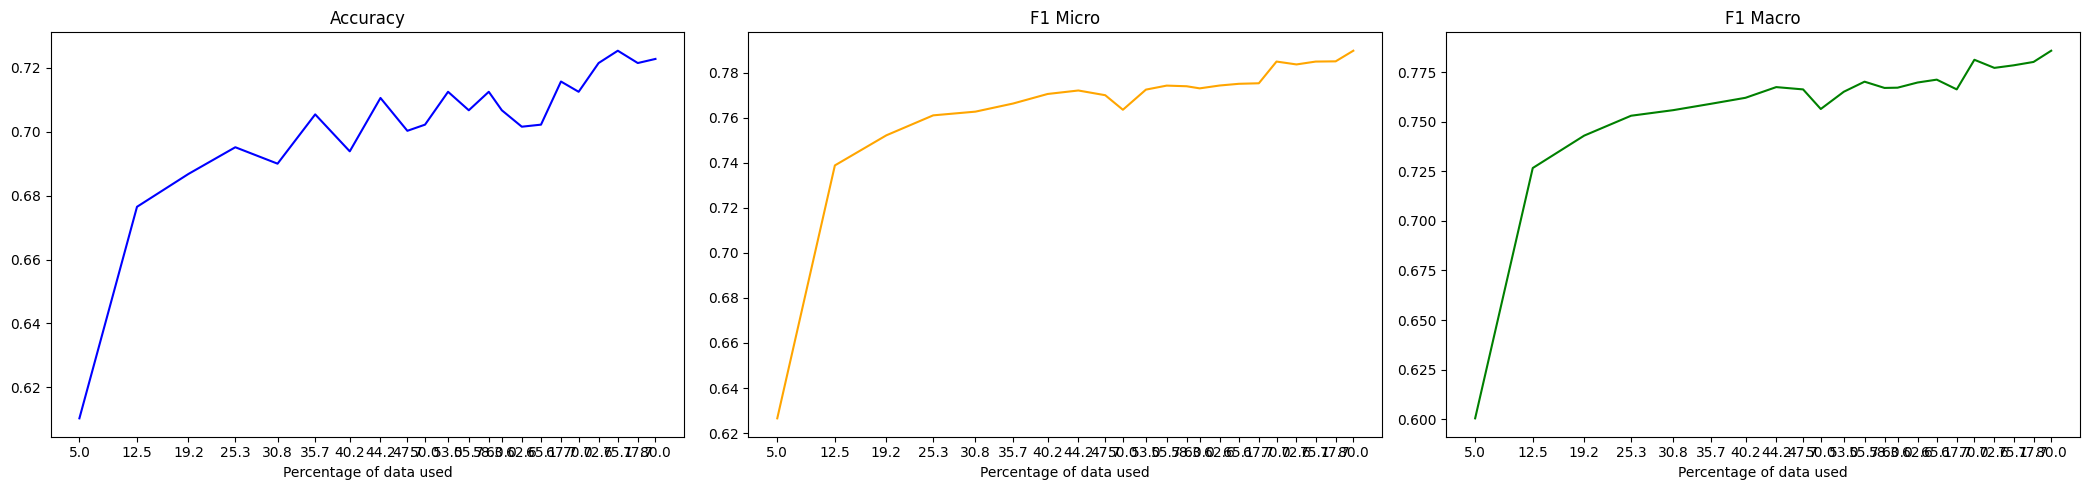

In [20]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241221_102943-c6pk9551
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./results/netifier-kmeans-4
wandb: ⭐️ View project at https://wandb.ai/nicost918-petra-christian-university/huggingface
wandb: 🚀 View run at https://wandb.ai/nicost918-petra-christian-university/huggingface/runs/c6pk9551


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.463594,0.462379,0.975610,0.030166,0.058522,0.049751
2,No log,0.391793,0.568489,0.831081,0.278281,0.416949,0.340929
3,No log,0.357158,0.562701,0.873684,0.250377,0.389215,0.305181
4,No log,0.331397,0.590354,0.783858,0.432127,0.557122,0.487882
5,No log,0.317543,0.603215,0.790637,0.458522,0.580430,0.516101
6,No log,0.307228,0.619293,0.780571,0.515083,0.620627,0.590389
7,No log,0.304412,0.622508,0.775442,0.528658,0.628700,0.586116
8,No log,0.301726,0.622508,0.763407,0.547511,0.637681,0.605725
9,No log,0.302151,0.625723,0.764644,0.551282,0.640666,0.610989
10,No log,0.300772,0.628939,0.751984,0.571644,0.649529,0.626356


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.76      0.84       362
                sara       0.70      0.31      0.43       237
         radikalisme       0.65      0.62      0.63       235
pencemaran_nama_baik       0.68      0.53      0.60       492

           micro avg       0.75      0.57      0.65      1326
           macro avg       0.74      0.56      0.63      1326
        weighted avg       0.75      0.57      0.64      1326
         samples avg       0.35      0.33      0.33      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 388: Accuracy: 0.6289389067524116, F1 Micro: 0.6495287060839761, F1 Macro: 0.626355645176144
                      precision    recall  f1-score   support

          pornografi       0.93      0.76      0.84       362
                sara       0.70      0.31      0.43       237
         radikalisme       0.65      0.62      0.63       235
pencemaran_nama_baik       0.68      0.53      0.60       492

           micro avg       0.75      0.57      0.65      1326
           macro avg       0.74      0.56      0.63      1326
        weighted avg       0.75      0.57      0.64      1326
         samples avg       0.35      0.33      0.33      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 583
Acquired samples: 583
Sampling duration: 25.981227159500122 seconds
New train size: 971


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.362293,0.562058,0.847222,0.276018,0.416382,0.361363
2,No log,0.296033,0.638585,0.773176,0.591252,0.670085,0.651382
3,No log,0.272725,0.663666,0.762195,0.659879,0.707357,0.690260
4,No log,0.264643,0.676527,0.761106,0.684766,0.720921,0.713978
5,No log,0.265605,0.677814,0.737519,0.735294,0.736405,0.726195
6,No log,0.263756,0.672026,0.760166,0.690799,0.723825,0.707606
7,No log,0.266434,0.682958,0.750195,0.724736,0.737246,0.727980
8,No log,0.272542,0.686817,0.736377,0.754148,0.745156,0.735887
9,0.233800,0.272809,0.681029,0.758704,0.706637,0.731745,0.721245
10,0.233800,0.275731,0.675241,0.736006,0.733786,0.734894,0.723752


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.87      0.88       362
                sara       0.60      0.60      0.60       237
         radikalisme       0.70      0.79      0.74       235
pencemaran_nama_baik       0.71      0.73      0.72       492

           micro avg       0.74      0.75      0.75      1326
           macro avg       0.73      0.75      0.74      1326
        weighted avg       0.74      0.75      0.75      1326
         samples avg       0.42      0.43      0.41      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 971: Accuracy: 0.6868167202572347, F1 Micro: 0.7451564828614009, F1 Macro: 0.735886765259139
                      precision    recall  f1-score   support

          pornografi       0.90      0.87      0.88       362
                sara       0.60      0.60      0.60       237
         radikalisme       0.70      0.79      0.74       235
pencemaran_nama_baik       0.71      0.73      0.72       492

           micro avg       0.74      0.75      0.75      1326
           macro avg       0.73      0.75      0.74      1326
        weighted avg       0.74      0.75      0.75      1326
         samples avg       0.42      0.43      0.41      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 525
Acquired samples: 525
Sampling duration: 23.07135558128357 seconds
New train size: 1496


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.320396,0.589711,0.742553,0.526395,0.616064,0.602041
2,No log,0.270779,0.668810,0.784834,0.624434,0.695506,0.691054
3,No log,0.260071,0.685531,0.730853,0.755656,0.743048,0.734603
4,No log,0.252780,0.681672,0.793103,0.659125,0.719934,0.703299
5,No log,0.260501,0.684244,0.750190,0.742836,0.746495,0.731344
6,0.257400,0.263621,0.685531,0.735442,0.771493,0.753036,0.745630
7,0.257400,0.273574,0.686817,0.723803,0.786576,0.753885,0.747363
8,0.257400,0.270737,0.690675,0.746816,0.751885,0.749342,0.740310
9,0.257400,0.269330,0.691961,0.767331,0.726244,0.746222,0.734648
10,0.257400,0.271857,0.693891,0.757274,0.745852,0.751520,0.742768


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.88      0.89      0.89       362
                sara       0.60      0.68      0.64       237
         radikalisme       0.70      0.79      0.74       235
pencemaran_nama_baik       0.69      0.76      0.72       492

           micro avg       0.72      0.79      0.75      1326
           macro avg       0.72      0.78      0.75      1326
        weighted avg       0.73      0.79      0.76      1326
         samples avg       0.43      0.44      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1496: Accuracy: 0.6868167202572347, F1 Micro: 0.7538850740874593, F1 Macro: 0.7473627160402005
                      precision    recall  f1-score   support

          pornografi       0.88      0.89      0.89       362
                sara       0.60      0.68      0.64       237
         radikalisme       0.70      0.79      0.74       235
pencemaran_nama_baik       0.69      0.76      0.72       492

           micro avg       0.72      0.79      0.75      1326
           macro avg       0.72      0.78      0.75      1326
        weighted avg       0.73      0.79      0.76      1326
         samples avg       0.43      0.44      0.42      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 473
Acquired samples: 473
Sampling duration: 19.194788694381714 seconds
New train size: 1969


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.298026,0.646302,0.758242,0.624434,0.684864,0.674015
2,No log,0.255509,0.681029,0.773698,0.683258,0.725671,0.717108
3,No log,0.250650,0.691961,0.755573,0.741327,0.748382,0.739506
4,No log,0.251341,0.693891,0.754615,0.739819,0.747144,0.739625
5,0.267300,0.286037,0.677814,0.691250,0.834087,0.755981,0.753645
6,0.267300,0.262899,0.691961,0.769354,0.726998,0.747577,0.738994
7,0.267300,0.268758,0.695177,0.764660,0.737557,0.750864,0.741599
8,0.267300,0.273493,0.697106,0.782895,0.717949,0.749017,0.738397
9,0.121700,0.279497,0.696463,0.754123,0.758673,0.756391,0.748171
10,0.121700,0.280614,0.693248,0.762607,0.741327,0.751816,0.742995


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.86      0.89       362
                sara       0.63      0.63      0.63       237
         radikalisme       0.70      0.79      0.74       235
pencemaran_nama_baik       0.73      0.73      0.73       492

           micro avg       0.75      0.76      0.76      1326
           macro avg       0.75      0.75      0.75      1326
        weighted avg       0.76      0.76      0.76      1326
         samples avg       0.43      0.43      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1969: Accuracy: 0.6964630225080386, F1 Micro: 0.7563909774436091, F1 Macro: 0.7481713027237963
                      precision    recall  f1-score   support

          pornografi       0.92      0.86      0.89       362
                sara       0.63      0.63      0.63       237
         radikalisme       0.70      0.79      0.74       235
pencemaran_nama_baik       0.73      0.73      0.73       492

           micro avg       0.75      0.76      0.76      1326
           macro avg       0.75      0.75      0.75      1326
        weighted avg       0.76      0.76      0.76      1326
         samples avg       0.43      0.43      0.42      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 425
Acquired samples: 425
Sampling duration: 16.56714415550232 seconds
New train size: 2394


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.289025,0.641158,0.812725,0.510558,0.627142,0.591124
2,No log,0.248460,0.699678,0.776955,0.711916,0.743015,0.734089
3,No log,0.243603,0.686174,0.765737,0.724736,0.744673,0.730886
4,0.278700,0.240210,0.697106,0.777778,0.733786,0.755142,0.743954
5,0.278700,0.251963,0.704823,0.782468,0.726998,0.753714,0.744941
6,0.278700,0.265312,0.694534,0.796655,0.682504,0.735175,0.721691
7,0.136000,0.279912,0.699035,0.748525,0.765460,0.756898,0.751690
8,0.136000,0.278886,0.691961,0.757274,0.745852,0.751520,0.744486
9,0.136000,0.285944,0.691961,0.759690,0.739065,0.749235,0.739195
10,0.082200,0.287869,0.693248,0.753754,0.757164,0.755455,0.749394


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.88      0.89       362
                sara       0.64      0.65      0.64       237
         radikalisme       0.71      0.82      0.76       235
pencemaran_nama_baik       0.71      0.72      0.71       492

           micro avg       0.75      0.77      0.76      1326
           macro avg       0.74      0.76      0.75      1326
        weighted avg       0.75      0.77      0.76      1326
         samples avg       0.43      0.43      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2394: Accuracy: 0.6990353697749196, F1 Micro: 0.7568978374347501, F1 Macro: 0.7516899037941153
                      precision    recall  f1-score   support

          pornografi       0.90      0.88      0.89       362
                sara       0.64      0.65      0.64       237
         radikalisme       0.71      0.82      0.76       235
pencemaran_nama_baik       0.71      0.72      0.71       492

           micro avg       0.75      0.77      0.76      1326
           macro avg       0.74      0.76      0.75      1326
        weighted avg       0.75      0.77      0.76      1326
         samples avg       0.43      0.43      0.42      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 383
Acquired samples: 383
Sampling duration: 14.73254942893982 seconds
New train size: 2777


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.269713,0.671383,0.749792,0.680241,0.713325,0.706403
2,No log,0.246328,0.697106,0.748886,0.760181,0.754491,0.747996
3,0.286900,0.254785,0.693248,0.733859,0.771493,0.752206,0.741013
4,0.286900,0.260658,0.691961,0.746657,0.757919,0.752246,0.747440
5,0.286900,0.252902,0.706109,0.774902,0.745098,0.759708,0.753626
6,0.149100,0.276117,0.690675,0.727460,0.797134,0.760705,0.755143
7,0.149100,0.274192,0.699678,0.758308,0.757164,0.757736,0.748461
8,0.149100,0.284535,0.703537,0.755754,0.767722,0.761691,0.755333
9,0.093100,0.287994,0.704823,0.765019,0.758673,0.761833,0.754916
10,0.093100,0.290621,0.702894,0.752784,0.764706,0.758698,0.751891


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.90      0.90       362
                sara       0.68      0.63      0.65       237
         radikalisme       0.73      0.77      0.75       235
pencemaran_nama_baik       0.72      0.71      0.71       492

           micro avg       0.77      0.76      0.76      1326
           macro avg       0.76      0.75      0.75      1326
        weighted avg       0.76      0.76      0.76      1326
         samples avg       0.43      0.43      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2777: Accuracy: 0.704823151125402, F1 Micro: 0.7618326391518365, F1 Macro: 0.7549159417298088
                      precision    recall  f1-score   support

          pornografi       0.90      0.90      0.90       362
                sara       0.68      0.63      0.65       237
         radikalisme       0.73      0.77      0.75       235
pencemaran_nama_baik       0.72      0.71      0.71       492

           micro avg       0.77      0.76      0.76      1326
           macro avg       0.76      0.75      0.75      1326
        weighted avg       0.76      0.76      0.76      1326
         samples avg       0.43      0.43      0.42      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 345
Acquired samples: 345
Sampling duration: 14.178729057312012 seconds
New train size: 3122


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.262183,0.681029,0.751412,0.702112,0.725926,0.716331
2,No log,0.244117,0.691961,0.744942,0.777526,0.760886,0.755060
3,0.291100,0.241081,0.696463,0.791421,0.709653,0.748310,0.744171
4,0.291100,0.256247,0.696463,0.732278,0.802413,0.765743,0.762153
5,0.291100,0.252149,0.702251,0.776978,0.733032,0.754366,0.747537
6,0.159900,0.264006,0.708039,0.773717,0.750377,0.761868,0.756891
7,0.159900,0.288440,0.701608,0.738636,0.784314,0.760790,0.754833
8,0.102800,0.293729,0.700322,0.736179,0.793363,0.763702,0.757534
9,0.102800,0.297908,0.701608,0.740899,0.782805,0.761276,0.754456
10,0.102800,0.297713,0.702251,0.751846,0.767722,0.759701,0.754206


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.88      0.89       362
                sara       0.61      0.73      0.66       237
         radikalisme       0.71      0.82      0.76       235
pencemaran_nama_baik       0.70      0.77      0.73       492

           micro avg       0.73      0.80      0.77      1326
           macro avg       0.73      0.80      0.76      1326
        weighted avg       0.74      0.80      0.77      1326
         samples avg       0.44      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3122: Accuracy: 0.6964630225080386, F1 Micro: 0.7657430730478589, F1 Macro: 0.7621528953254711
                      precision    recall  f1-score   support

          pornografi       0.90      0.88      0.89       362
                sara       0.61      0.73      0.66       237
         radikalisme       0.71      0.82      0.76       235
pencemaran_nama_baik       0.70      0.77      0.73       492

           micro avg       0.73      0.80      0.77      1326
           macro avg       0.73      0.80      0.76      1326
        weighted avg       0.74      0.80      0.77      1326
         samples avg       0.44      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 310
Acquired samples: 310
Sampling duration: 11.347160816192627 seconds
New train size: 3432


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.263518,0.677170,0.736364,0.733032,0.734694,0.730345
2,No log,0.242364,0.692605,0.791342,0.689291,0.736800,0.729376
3,0.293500,0.235563,0.704823,0.778396,0.739065,0.758221,0.751847
4,0.293500,0.242613,0.704180,0.759108,0.769985,0.764508,0.758207
5,0.171500,0.254789,0.702894,0.761544,0.758673,0.760106,0.755202
6,0.171500,0.277154,0.694534,0.728837,0.798643,0.762145,0.756629
7,0.111100,0.290310,0.704180,0.731313,0.819005,0.772679,0.766580
8,0.111100,0.298103,0.708682,0.739525,0.798643,0.767948,0.762610
9,0.111100,0.290348,0.709968,0.758595,0.765460,0.762012,0.754286
10,0.078400,0.292124,0.709325,0.760150,0.762443,0.761295,0.752618


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.87      0.92      0.90       362
                sara       0.64      0.70      0.67       237
         radikalisme       0.72      0.81      0.76       235
pencemaran_nama_baik       0.69      0.80      0.74       492

           micro avg       0.73      0.82      0.77      1326
           macro avg       0.73      0.81      0.77      1326
        weighted avg       0.73      0.82      0.77      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3432: Accuracy: 0.7041800643086816, F1 Micro: 0.7726787620064034, F1 Macro: 0.7665797711077083
                      precision    recall  f1-score   support

          pornografi       0.87      0.92      0.90       362
                sara       0.64      0.70      0.67       237
         radikalisme       0.72      0.81      0.76       235
pencemaran_nama_baik       0.69      0.80      0.74       492

           micro avg       0.73      0.82      0.77      1326
           macro avg       0.73      0.81      0.77      1326
        weighted avg       0.73      0.82      0.77      1326
         samples avg       0.45      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 279
Acquired samples: 279
Sampling duration: 10.105342149734497 seconds
New train size: 3711


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.260051,0.676527,0.754967,0.687783,0.719811,0.711473
2,No log,0.237469,0.704180,0.770518,0.729261,0.749322,0.744364
3,0.297100,0.234493,0.710611,0.770945,0.756410,0.763609,0.757249
4,0.297100,0.249086,0.695177,0.733379,0.806938,0.768402,0.760767
5,0.175800,0.253766,0.706109,0.769290,0.751885,0.760488,0.748178
6,0.175800,0.270944,0.705466,0.755178,0.769985,0.762509,0.754546
7,0.114500,0.274184,0.713183,0.761589,0.780543,0.770950,0.763251
8,0.114500,0.286193,0.714469,0.784000,0.739065,0.760870,0.749834
9,0.082200,0.295431,0.707395,0.751269,0.781297,0.765989,0.757988
10,0.082200,0.297739,0.706752,0.760238,0.769985,0.765081,0.754051


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.91      0.90       362
                sara       0.67      0.64      0.65       237
         radikalisme       0.71      0.83      0.76       235
pencemaran_nama_baik       0.73      0.73      0.73       492

           micro avg       0.76      0.78      0.77      1326
           macro avg       0.75      0.78      0.76      1326
        weighted avg       0.76      0.78      0.77      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3711: Accuracy: 0.7131832797427653, F1 Micro: 0.770949720670391, F1 Macro: 0.7632514449898306
                      precision    recall  f1-score   support

          pornografi       0.90      0.91      0.90       362
                sara       0.67      0.64      0.65       237
         radikalisme       0.71      0.83      0.76       235
pencemaran_nama_baik       0.73      0.73      0.73       492

           micro avg       0.76      0.78      0.77      1326
           macro avg       0.75      0.78      0.76      1326
        weighted avg       0.76      0.78      0.77      1326
         samples avg       0.44      0.44      0.43      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 251
Acquired samples: 175
Sampling duration: 8.21538496017456 seconds
New train size: 3886


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.261452,0.675884,0.740319,0.735294,0.737798,0.724563
2,No log,0.238526,0.692605,0.759036,0.760181,0.759608,0.748607
3,0.299900,0.232191,0.696463,0.773585,0.742081,0.757506,0.744682
4,0.299900,0.238130,0.693891,0.754373,0.780543,0.767235,0.760836
5,0.183000,0.250991,0.707395,0.754298,0.794118,0.773696,0.767806
6,0.183000,0.257734,0.708682,0.772657,0.758673,0.765601,0.758847
7,0.124100,0.270659,0.713826,0.754597,0.804676,0.778832,0.774647
8,0.124100,0.285093,0.717685,0.769004,0.785822,0.777322,0.767581
9,0.087300,0.281932,0.717042,0.769459,0.782805,0.776075,0.771183
10,0.087300,0.289125,0.714469,0.763331,0.788084,0.775510,0.768830


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.64      0.71      0.67       237
         radikalisme       0.74      0.82      0.78       235
pencemaran_nama_baik       0.71      0.78      0.74       492

           micro avg       0.75      0.80      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3886: Accuracy: 0.7138263665594855, F1 Micro: 0.7788321167883211, F1 Macro: 0.7746474084392304
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.64      0.71      0.67       237
         radikalisme       0.74      0.82      0.78       235
pencemaran_nama_baik       0.71      0.78      0.74       492

           micro avg       0.75      0.80      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 8.201268672943115 seconds
New train size: 4120


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.256394,0.679743,0.742435,0.758673,0.750466,0.746954
2,0.299400,0.240718,0.693891,0.740014,0.796380,0.767163,0.762710
3,0.299400,0.234591,0.710611,0.760886,0.777526,0.769116,0.763457
4,0.184400,0.240052,0.708039,0.761727,0.771493,0.766579,0.756071
5,0.184400,0.252705,0.713183,0.806507,0.710407,0.755413,0.746609
6,0.125000,0.274413,0.712540,0.753980,0.785822,0.769572,0.766545
7,0.125000,0.282972,0.708039,0.750887,0.797888,0.773675,0.771252
8,0.087200,0.297723,0.706752,0.756637,0.773756,0.765101,0.758034
9,0.087200,0.301412,0.709325,0.761658,0.776018,0.768771,0.764288
10,0.067600,0.305110,0.705466,0.756044,0.778281,0.767001,0.763036


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.92      0.91       362
                sara       0.66      0.69      0.67       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.69      0.75      0.72       492

           micro avg       0.75      0.80      0.77      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.75      0.80      0.77      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4120: Accuracy: 0.7080385852090032, F1 Micro: 0.7736745886654479, F1 Macro: 0.7712517259166565
                      precision    recall  f1-score   support

          pornografi       0.90      0.92      0.91       362
                sara       0.66      0.69      0.67       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.69      0.75      0.72       492

           micro avg       0.75      0.80      0.77      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.75      0.80      0.77      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 7.2051472663879395 seconds
New train size: 4330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.250667,0.691318,0.764090,0.715686,0.739097,0.729407
2,0.302900,0.232829,0.708039,0.784490,0.724736,0.753430,0.748115
3,0.302900,0.232901,0.708682,0.769578,0.770739,0.770158,0.765981
4,0.186000,0.234405,0.714469,0.774071,0.769985,0.772023,0.763141
5,0.186000,0.246783,0.713826,0.785884,0.747360,0.766138,0.756798
6,0.133100,0.270289,0.713183,0.783740,0.726998,0.754304,0.742218
7,0.133100,0.288294,0.712540,0.743607,0.811463,0.776055,0.771540
8,0.091900,0.291897,0.713826,0.770817,0.760935,0.765844,0.758855
9,0.091900,0.302778,0.711254,0.757379,0.793363,0.774954,0.770396
10,0.069600,0.303182,0.711897,0.759797,0.789593,0.774408,0.770889


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.93      0.92       362
                sara       0.63      0.70      0.66       237
         radikalisme       0.72      0.84      0.78       235
pencemaran_nama_baik       0.70      0.76      0.73       492

           micro avg       0.74      0.81      0.78      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4330: Accuracy: 0.712540192926045, F1 Micro: 0.7760548142805626, F1 Macro: 0.7715395072759872
                      precision    recall  f1-score   support

          pornografi       0.90      0.93      0.92       362
                sara       0.63      0.70      0.66       237
         radikalisme       0.72      0.84      0.78       235
pencemaran_nama_baik       0.70      0.76      0.73       492

           micro avg       0.74      0.81      0.78      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Samples above threshold: 189
Acquired samples: 200
Sampling duration: 6.364313840866089 seconds
New train size: 4530


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.252603,0.673955,0.746627,0.751131,0.748872,0.735031
2,0.303800,0.229766,0.704823,0.771714,0.757164,0.764370,0.757838
3,0.303800,0.238135,0.711254,0.754487,0.792609,0.773078,0.766669
4,0.191300,0.240990,0.713183,0.769697,0.766214,0.767952,0.760190
5,0.191300,0.260472,0.699035,0.750355,0.797888,0.773392,0.764735
6,0.133000,0.269095,0.710611,0.760790,0.784314,0.772373,0.765648
7,0.133000,0.292613,0.708682,0.752307,0.799397,0.775137,0.767014
8,0.095200,0.296783,0.718328,0.759602,0.805430,0.781845,0.776533
9,0.071600,0.303598,0.715113,0.759420,0.790347,0.774575,0.769179
10,0.071600,0.305034,0.719614,0.760948,0.799397,0.779698,0.773041


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.65      0.67      0.66       237
         radikalisme       0.74      0.84      0.79       235
pencemaran_nama_baik       0.71      0.77      0.74       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4530: Accuracy: 0.7183279742765273, F1 Micro: 0.7818448023426062, F1 Macro: 0.7765328579452679
                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.65      0.67      0.66       237
         radikalisme       0.74      0.84      0.79       235
pencemaran_nama_baik       0.71      0.77      0.74       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Samples above threshold: 169
Acquired samples: 133
Sampling duration: 5.600373029708862 seconds
New train size: 4663


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.253878,0.681029,0.768526,0.696078,0.730510,0.703701
2,0.301000,0.233563,0.705466,0.764574,0.771493,0.768018,0.754092
3,0.301000,0.231030,0.704180,0.778555,0.755656,0.766935,0.752550
4,0.194000,0.249143,0.696463,0.745739,0.791855,0.768105,0.757655
5,0.194000,0.257890,0.700965,0.747159,0.793363,0.769568,0.765866
6,0.135300,0.265375,0.709968,0.774548,0.743590,0.758753,0.750502
7,0.097700,0.287776,0.706752,0.752673,0.796380,0.773910,0.769165
8,0.097700,0.296974,0.701608,0.748924,0.787330,0.767647,0.763004
9,0.074000,0.305832,0.704823,0.750897,0.788839,0.769401,0.764412
10,0.074000,0.308216,0.704180,0.750360,0.786576,0.768041,0.762363


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.92      0.91       362
                sara       0.65      0.67      0.66       237
         radikalisme       0.73      0.83      0.78       235
pencemaran_nama_baik       0.70      0.75      0.73       492

           micro avg       0.75      0.80      0.77      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.75      0.80      0.77      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4663: Accuracy: 0.7067524115755627, F1 Micro: 0.7739098570905094, F1 Macro: 0.7691652997394693
                      precision    recall  f1-score   support

          pornografi       0.90      0.92      0.91       362
                sara       0.65      0.67      0.66       237
         radikalisme       0.73      0.83      0.78       235
pencemaran_nama_baik       0.70      0.75      0.73       492

           micro avg       0.75      0.80      0.77      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.75      0.80      0.77      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Samples above threshold: 156
Acquired samples: 200
Sampling duration: 5.402950763702393 seconds
New train size: 4863


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.254939,0.679743,0.730193,0.771493,0.750275,0.742171
2,0.307600,0.236974,0.695177,0.767478,0.736802,0.751828,0.731967
3,0.307600,0.235992,0.706109,0.743113,0.813725,0.776818,0.769682
4,0.196800,0.239100,0.709325,0.770865,0.766214,0.768533,0.763231
5,0.142300,0.259833,0.711254,0.759797,0.789593,0.774408,0.767662
6,0.142300,0.277708,0.719614,0.757662,0.801659,0.779040,0.771892
7,0.102100,0.293091,0.718328,0.752778,0.817496,0.783803,0.778015
8,0.102100,0.299383,0.718328,0.761119,0.800151,0.780147,0.775802
9,0.079200,0.313119,0.719614,0.752281,0.808446,0.779353,0.773630
10,0.062100,0.310779,0.723473,0.761290,0.800905,0.780595,0.775919


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.91       362
                sara       0.64      0.70      0.67       237
         radikalisme       0.72      0.86      0.78       235
pencemaran_nama_baik       0.72      0.77      0.75       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.75      0.82      0.78      1326
        weighted avg       0.76      0.82      0.78      1326
         samples avg       0.46      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4863: Accuracy: 0.7183279742765273, F1 Micro: 0.7838033261026753, F1 Macro: 0.7780147732029825
                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.91       362
                sara       0.64      0.70      0.67       237
         radikalisme       0.72      0.86      0.78       235
pencemaran_nama_baik       0.72      0.77      0.75       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.75      0.82      0.78      1326
        weighted avg       0.76      0.82      0.78      1326
         samples avg       0.46      0.47      0.46      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Samples above threshold: 136
Acquired samples: 200
Sampling duration: 4.654093027114868 seconds
New train size: 5063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.250197,0.697106,0.728709,0.800151,0.762761,0.755772
2,0.302900,0.228058,0.702251,0.765565,0.751131,0.758279,0.744508
3,0.302900,0.224886,0.711254,0.768084,0.776772,0.772403,0.764101
4,0.203200,0.251808,0.708682,0.731204,0.828808,0.776953,0.773568
5,0.147500,0.248944,0.717042,0.769175,0.794118,0.781447,0.771651
6,0.147500,0.275537,0.708682,0.756955,0.779789,0.768202,0.757617
7,0.109400,0.288116,0.713826,0.762009,0.789593,0.775556,0.769922
8,0.085100,0.290062,0.711254,0.758896,0.788084,0.773215,0.764977
9,0.085100,0.300476,0.708682,0.762500,0.782051,0.772152,0.764319
10,0.067300,0.304602,0.709968,0.760029,0.785822,0.772710,0.766128


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.92       362
                sara       0.66      0.61      0.64       237
         radikalisme       0.76      0.81      0.79       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5063: Accuracy: 0.7170418006430869, F1 Micro: 0.7814471243042672, F1 Macro: 0.7716511723762342
                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.92       362
                sara       0.66      0.61      0.64       237
         radikalisme       0.76      0.81      0.79       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 4.071511268615723 seconds
New train size: 5263


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.243833,0.696463,0.753150,0.766214,0.759626,0.752437
2,0.304900,0.231983,0.707395,0.758850,0.776018,0.767338,0.760318
3,0.304900,0.224152,0.714469,0.808960,0.721719,0.762854,0.752121
4,0.204000,0.263761,0.693891,0.706064,0.860483,0.775663,0.774435
5,0.150700,0.245403,0.717042,0.765772,0.796380,0.780776,0.774570
6,0.150700,0.263251,0.706109,0.782853,0.736802,0.759130,0.741611
7,0.114600,0.272455,0.709325,0.761095,0.776018,0.768484,0.767156
8,0.085400,0.292910,0.716399,0.749650,0.808446,0.777939,0.772833
9,0.085400,0.289194,0.718971,0.780620,0.759427,0.769878,0.764469
10,0.072000,0.297765,0.719614,0.760145,0.791101,0.775314,0.770898


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.75      0.84      0.80       235
pencemaran_nama_baik       0.72      0.76      0.74       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.46      0.45      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5263: Accuracy: 0.7170418006430869, F1 Micro: 0.7807763401109058, F1 Macro: 0.7745700237527571
                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.75      0.84      0.80       235
pencemaran_nama_baik       0.72      0.76      0.74       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.46      0.45      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 3.481360912322998 seconds
New train size: 5441


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.241799,0.693248,0.777778,0.728507,0.752336,0.736812
2,0.305600,0.228002,0.706109,0.785024,0.735294,0.759346,0.747342
3,0.206900,0.231066,0.704823,0.738388,0.815234,0.774910,0.768999
4,0.206900,0.232298,0.709968,0.770958,0.776772,0.773854,0.768724
5,0.156300,0.246157,0.708039,0.760174,0.788839,0.774241,0.764434
6,0.118900,0.256340,0.722186,0.775940,0.778281,0.777108,0.770496
7,0.118900,0.282377,0.719614,0.763023,0.784314,0.773522,0.764282
8,0.087300,0.297463,0.718328,0.754610,0.802413,0.777778,0.770264
9,0.071400,0.297585,0.713183,0.757267,0.785822,0.771281,0.764463
10,0.071400,0.299187,0.716399,0.763971,0.783560,0.773641,0.766730


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.88      0.93      0.91       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.75      0.83      0.78       235
pencemaran_nama_baik       0.72      0.77      0.74       492

           micro avg       0.75      0.80      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.75      0.80      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5441: Accuracy: 0.7183279742765273, F1 Micro: 0.7777777777777778, F1 Macro: 0.7702643077787216
                      precision    recall  f1-score   support

          pornografi       0.88      0.93      0.91       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.75      0.83      0.78       235
pencemaran_nama_baik       0.72      0.77      0.74       492

           micro avg       0.75      0.80      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.75      0.80      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Samples above threshold: 78
Acquired samples: 200
Sampling duration: 2.8957359790802 seconds
New train size: 5641


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.248455,0.691961,0.749808,0.736802,0.743248,0.740381
2,0.303200,0.228609,0.709968,0.750706,0.801659,0.775346,0.768664
3,0.215300,0.226857,0.715113,0.753338,0.808446,0.779920,0.771290
4,0.215300,0.224418,0.726688,0.784580,0.782805,0.783692,0.775020
5,0.159200,0.256172,0.716399,0.748789,0.815988,0.780946,0.772524
6,0.119500,0.253828,0.726045,0.780689,0.786576,0.783621,0.773992
7,0.119500,0.276862,0.720900,0.759207,0.808446,0.783053,0.775777
8,0.094100,0.284346,0.722186,0.780562,0.775264,0.777904,0.769130
9,0.073500,0.294171,0.728617,0.773529,0.793363,0.783321,0.775841
10,0.061800,0.297640,0.727331,0.774099,0.793363,0.783613,0.777535


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.67      0.62      0.64       237
         radikalisme       0.77      0.82      0.79       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.78      0.78      0.78      1326
           macro avg       0.78      0.77      0.78      1326
        weighted avg       0.79      0.78      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5641: Accuracy: 0.7266881028938906, F1 Micro: 0.7836919592298981, F1 Macro: 0.7750201595242521
                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.67      0.62      0.64       237
         radikalisme       0.77      0.82      0.79       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.78      0.78      0.78      1326
           macro avg       0.78      0.77      0.78      1326
        weighted avg       0.79      0.78      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Samples above threshold: 58
Acquired samples: 200
Sampling duration: 2.2592365741729736 seconds
New train size: 5841


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.250392,0.686174,0.781579,0.671946,0.722628,0.701177
2,0.303600,0.224095,0.720257,0.781370,0.765460,0.773333,0.766135
3,0.211900,0.221909,0.722830,0.787102,0.763952,0.775354,0.762980
4,0.211900,0.231248,0.722830,0.811973,0.726244,0.766720,0.754464
5,0.158900,0.247769,0.724759,0.779837,0.793363,0.786542,0.780627
6,0.120200,0.260501,0.716399,0.778614,0.779789,0.779201,0.771453
7,0.095600,0.281430,0.714469,0.752974,0.811463,0.781125,0.775855
8,0.095600,0.291015,0.720900,0.769175,0.801659,0.785081,0.777905
9,0.071500,0.302550,0.717685,0.767662,0.794872,0.781030,0.773246
10,0.059000,0.300048,0.716399,0.773264,0.789593,0.781343,0.774709


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.91      0.92       362
                sara       0.68      0.65      0.67       237
         radikalisme       0.73      0.88      0.79       235
pencemaran_nama_baik       0.74      0.74      0.74       492

           micro avg       0.78      0.79      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5841: Accuracy: 0.7247588424437299, F1 Micro: 0.7865420560747663, F1 Macro: 0.7806273228129661
                      precision    recall  f1-score   support

          pornografi       0.94      0.91      0.92       362
                sara       0.68      0.65      0.67       237
         radikalisme       0.73      0.88      0.79       235
pencemaran_nama_baik       0.74      0.74      0.74       492

           micro avg       0.78      0.79      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 1.6191508769989014 seconds
New train size: 6041


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.249223,0.697749,0.747937,0.751885,0.749906,0.741790
2,0.305100,0.220109,0.721543,0.783346,0.766214,0.774685,0.767757
3,0.208200,0.223012,0.720900,0.770300,0.794118,0.782027,0.772701
4,0.163400,0.231096,0.718328,0.774170,0.791101,0.782544,0.772389
5,0.163400,0.245839,0.720900,0.758547,0.803167,0.780220,0.772390
6,0.122300,0.257560,0.722830,0.777778,0.786576,0.782152,0.774341
7,0.098900,0.283872,0.729904,0.775480,0.791855,0.783582,0.777590
8,0.073400,0.287384,0.731190,0.781927,0.789593,0.785741,0.780670
9,0.073400,0.296544,0.727331,0.779699,0.782051,0.780873,0.774934
10,0.062600,0.302623,0.725402,0.770987,0.789593,0.780179,0.773333


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.66      0.66      0.66       237
         radikalisme       0.77      0.83      0.80       235
pencemaran_nama_baik       0.73      0.75      0.74       492

           micro avg       0.78      0.79      0.79      1326
           macro avg       0.78      0.78      0.78      1326
        weighted avg       0.78      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6041: Accuracy: 0.7311897106109325, F1 Micro: 0.7857410881801126, F1 Macro: 0.780669948853556
                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.66      0.66      0.66       237
         radikalisme       0.77      0.83      0.80       235
pencemaran_nama_baik       0.73      0.75      0.74       492

           micro avg       0.78      0.79      0.79      1326
           macro avg       0.78      0.78      0.78      1326
        weighted avg       0.78      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-13-46a36a0f91da>:54: ConvergenceWarning: Number of distinct clusters (72) found smaller than n_clusters (177). Possibly due to duplicate points in X.
  kmeans.fit(embeddings)


Nearest checkpoint: 6218
Samples above threshold: 18
Acquired samples: 177
Sampling duration: 1.7077858448028564 seconds
New train size: 6218


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.245364,0.699035,0.805957,0.673454,0.733772,0.721036
2,0.294500,0.225389,0.709325,0.783239,0.733032,0.757304,0.749167
3,0.206300,0.222889,0.724759,0.774742,0.791101,0.782836,0.773282
4,0.161100,0.241086,0.723473,0.762411,0.810709,0.785819,0.779184
5,0.161100,0.245132,0.721543,0.792587,0.757919,0.774865,0.761858
6,0.123300,0.269409,0.716399,0.753165,0.807692,0.779476,0.773041
7,0.096000,0.271753,0.723473,0.794488,0.760935,0.777350,0.766770
8,0.075700,0.285577,0.723473,0.786159,0.762443,0.774119,0.763532
9,0.062000,0.300479,0.727974,0.772059,0.791855,0.781832,0.774773
10,0.062000,0.304473,0.721543,0.772761,0.787330,0.779978,0.772131


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.91       362
                sara       0.64      0.66      0.65       237
         radikalisme       0.75      0.86      0.80       235
pencemaran_nama_baik       0.73      0.79      0.76       492

           micro avg       0.76      0.81      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6218: Accuracy: 0.7234726688102894, F1 Micro: 0.7858187134502924, F1 Macro: 0.779184064067949
                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.91       362
                sara       0.64      0.66      0.65       237
         radikalisme       0.75      0.86      0.80       235
pencemaran_nama_baik       0.73      0.79      0.76       492

           micro avg       0.76      0.81      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326

Total sampling time: 196.86 seconds
Total runtime: 11777.62056517601 seconds


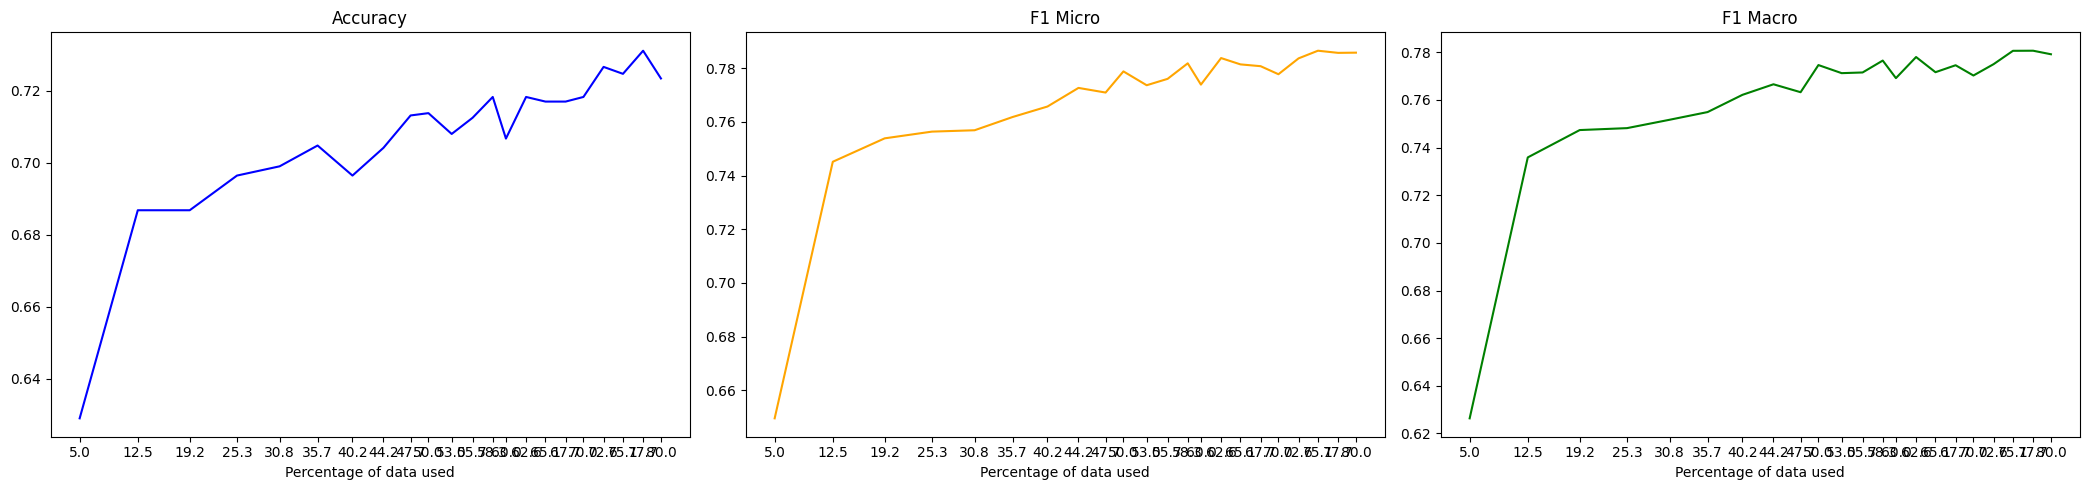

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.458386,0.505466,1.000000,0.080694,0.149337,0.114072
2,No log,0.384749,0.584566,0.914454,0.233786,0.372372,0.251831
3,No log,0.356113,0.571704,0.750000,0.348416,0.475798,0.347973
4,No log,0.330139,0.593569,0.773109,0.416290,0.541176,0.453938
5,No log,0.312512,0.608360,0.758850,0.517345,0.615247,0.548237
6,No log,0.303364,0.628296,0.745247,0.591252,0.659378,0.634356
7,No log,0.297518,0.625080,0.737660,0.608597,0.666942,0.633439
8,No log,0.296958,0.624437,0.752000,0.567119,0.646604,0.609105
9,No log,0.293293,0.627653,0.743662,0.597285,0.662484,0.635006
10,No log,0.293404,0.627653,0.747126,0.588235,0.658228,0.629208


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.83      0.85      0.84       362
                sara       0.72      0.29      0.41       237
         radikalisme       0.72      0.61      0.66       235
pencemaran_nama_baik       0.67      0.59      0.63       492

           micro avg       0.74      0.61      0.67      1326
           macro avg       0.73      0.58      0.63      1326
        weighted avg       0.73      0.61      0.65      1326
         samples avg       0.38      0.35      0.35      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 388: Accuracy: 0.62508038585209, F1 Micro: 0.6669421487603305, F1 Macro: 0.6334393870554681
                      precision    recall  f1-score   support

          pornografi       0.83      0.85      0.84       362
                sara       0.72      0.29      0.41       237
         radikalisme       0.72      0.61      0.66       235
pencemaran_nama_baik       0.67      0.59      0.63       492

           micro avg       0.74      0.61      0.67      1326
           macro avg       0.73      0.58      0.63      1326
        weighted avg       0.73      0.61      0.65      1326
         samples avg       0.38      0.35      0.35      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 583
Acquired samples: 583
Sampling duration: 25.675012588500977 seconds
New train size: 971


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.360801,0.567203,0.809619,0.304676,0.442740,0.369517
2,No log,0.295153,0.648232,0.775348,0.588235,0.668954,0.650684
3,No log,0.274262,0.666238,0.739201,0.684012,0.710537,0.704771
4,No log,0.276720,0.655949,0.705182,0.759427,0.731300,0.718378
5,No log,0.266745,0.670740,0.719886,0.761689,0.740198,0.732761
6,No log,0.263153,0.684244,0.756235,0.708899,0.731802,0.717286
7,No log,0.267500,0.684887,0.768771,0.679487,0.721377,0.704649
8,No log,0.272779,0.684887,0.748638,0.725490,0.736882,0.724182
9,0.232100,0.273202,0.686817,0.751567,0.723228,0.737125,0.725867
10,0.232100,0.273765,0.690675,0.757382,0.715686,0.735944,0.724560


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.88      0.86      0.87       362
                sara       0.62      0.61      0.61       237
         radikalisme       0.71      0.77      0.74       235
pencemaran_nama_baik       0.66      0.76      0.71       492

           micro avg       0.72      0.76      0.74      1326
           macro avg       0.72      0.75      0.73      1326
        weighted avg       0.72      0.76      0.74      1326
         samples avg       0.42      0.43      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 971: Accuracy: 0.6707395498392283, F1 Micro: 0.7401978746793698, F1 Macro: 0.7327609596477187
                      precision    recall  f1-score   support

          pornografi       0.88      0.86      0.87       362
                sara       0.62      0.61      0.61       237
         radikalisme       0.71      0.77      0.74       235
pencemaran_nama_baik       0.66      0.76      0.71       492

           micro avg       0.72      0.76      0.74      1326
           macro avg       0.72      0.75      0.73      1326
        weighted avg       0.72      0.76      0.74      1326
         samples avg       0.42      0.43      0.42      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 525
Acquired samples: 525
Sampling duration: 22.667783975601196 seconds
New train size: 1496


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.315933,0.623794,0.772926,0.533937,0.631579,0.597521
2,No log,0.269527,0.671383,0.735776,0.711916,0.723649,0.717663
3,No log,0.258379,0.682958,0.726027,0.759427,0.742352,0.732272
4,No log,0.253814,0.674598,0.787004,0.657617,0.716516,0.691250
5,No log,0.255013,0.692605,0.748855,0.739819,0.744310,0.732909
6,0.260100,0.264439,0.691318,0.740045,0.742836,0.741438,0.730394
7,0.260100,0.266079,0.692605,0.764801,0.711161,0.737007,0.720370
8,0.260100,0.275998,0.691961,0.750961,0.736802,0.743814,0.730025
9,0.260100,0.281896,0.690032,0.739294,0.742081,0.740685,0.729198
10,0.260100,0.283200,0.695177,0.745441,0.739819,0.742619,0.730396


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.86      0.90       362
                sara       0.61      0.60      0.61       237
         radikalisme       0.71      0.71      0.71       235
pencemaran_nama_baik       0.71      0.73      0.72       492

           micro avg       0.75      0.74      0.74      1326
           macro avg       0.74      0.73      0.73      1326
        weighted avg       0.75      0.74      0.75      1326
         samples avg       0.42      0.42      0.41      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1496: Accuracy: 0.692604501607717, F1 Micro: 0.744309559939302, F1 Macro: 0.7329094024673628
                      precision    recall  f1-score   support

          pornografi       0.93      0.86      0.90       362
                sara       0.61      0.60      0.61       237
         radikalisme       0.71      0.71      0.71       235
pencemaran_nama_baik       0.71      0.73      0.72       492

           micro avg       0.75      0.74      0.74      1326
           macro avg       0.74      0.73      0.73      1326
        weighted avg       0.75      0.74      0.75      1326
         samples avg       0.42      0.42      0.41      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 473
Acquired samples: 473
Sampling duration: 20.224249362945557 seconds
New train size: 1969


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.296253,0.632154,0.812201,0.512066,0.628122,0.593043
2,No log,0.266373,0.664952,0.792527,0.607843,0.688007,0.665116
3,No log,0.247477,0.684887,0.760000,0.730769,0.745098,0.732045
4,No log,0.250876,0.686817,0.737072,0.763198,0.749907,0.742902
5,0.271200,0.259343,0.700322,0.770270,0.730769,0.750000,0.737697
6,0.271200,0.266964,0.698392,0.750742,0.763198,0.756918,0.749890
7,0.271200,0.280763,0.698392,0.743478,0.773756,0.758315,0.750115
8,0.271200,0.281375,0.700322,0.754689,0.758673,0.756675,0.747446
9,0.117100,0.285242,0.701608,0.753903,0.764706,0.759266,0.752330
10,0.117100,0.289513,0.699035,0.749072,0.760935,0.754957,0.747060


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.88      0.90       362
                sara       0.66      0.66      0.66       237
         radikalisme       0.70      0.77      0.73       235
pencemaran_nama_baik       0.72      0.73      0.72       492

           micro avg       0.75      0.76      0.76      1326
           macro avg       0.75      0.76      0.75      1326
        weighted avg       0.76      0.76      0.76      1326
         samples avg       0.43      0.43      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1969: Accuracy: 0.7016077170418007, F1 Micro: 0.7592661924372893, F1 Macro: 0.7523303171724456
                      precision    recall  f1-score   support

          pornografi       0.91      0.88      0.90       362
                sara       0.66      0.66      0.66       237
         radikalisme       0.70      0.77      0.73       235
pencemaran_nama_baik       0.72      0.73      0.72       492

           micro avg       0.75      0.76      0.76      1326
           macro avg       0.75      0.76      0.75      1326
        weighted avg       0.76      0.76      0.76      1326
         samples avg       0.43      0.43      0.42      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 425
Acquired samples: 425
Sampling duration: 17.01549983024597 seconds
New train size: 2394


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.288345,0.609646,0.813625,0.477376,0.601711,0.562884
2,No log,0.251967,0.690032,0.752722,0.730015,0.741194,0.733942
3,No log,0.241954,0.688746,0.787700,0.705128,0.744131,0.731948
4,0.282400,0.255016,0.683601,0.710979,0.810709,0.757576,0.753942
5,0.282400,0.254951,0.690032,0.740203,0.769231,0.754438,0.745609
6,0.282400,0.259308,0.701608,0.739888,0.800151,0.768841,0.762521
7,0.142000,0.275597,0.689389,0.724915,0.800905,0.761018,0.754004
8,0.142000,0.271332,0.704180,0.771474,0.738311,0.754528,0.746951
9,0.142000,0.277104,0.702894,0.755178,0.769985,0.762509,0.755563
10,0.085300,0.278325,0.704180,0.757058,0.768477,0.762725,0.756533


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.89      0.89       362
                sara       0.65      0.69      0.67       237
         radikalisme       0.69      0.82      0.75       235
pencemaran_nama_baik       0.70      0.78      0.74       492

           micro avg       0.74      0.80      0.77      1326
           macro avg       0.74      0.79      0.76      1326
        weighted avg       0.74      0.80      0.77      1326
         samples avg       0.44      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2394: Accuracy: 0.7016077170418007, F1 Micro: 0.7688405797101449, F1 Macro: 0.7625210172341319
                      precision    recall  f1-score   support

          pornografi       0.90      0.89      0.89       362
                sara       0.65      0.69      0.67       237
         radikalisme       0.69      0.82      0.75       235
pencemaran_nama_baik       0.70      0.78      0.74       492

           micro avg       0.74      0.80      0.77      1326
           macro avg       0.74      0.79      0.76      1326
        weighted avg       0.74      0.80      0.77      1326
         samples avg       0.44      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 383
Acquired samples: 383
Sampling duration: 14.796391010284424 seconds
New train size: 2777


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.269757,0.677814,0.751403,0.706637,0.728333,0.723495
2,No log,0.244762,0.689389,0.754775,0.745098,0.749905,0.747570
3,0.291400,0.239112,0.697106,0.766041,0.738311,0.751920,0.739738
4,0.291400,0.244523,0.701608,0.746988,0.794872,0.770186,0.763332
5,0.291400,0.261401,0.685531,0.720884,0.812217,0.763830,0.759686
6,0.155700,0.257680,0.704180,0.757331,0.779035,0.768030,0.761719
7,0.155700,0.260334,0.704823,0.775078,0.745852,0.760184,0.750110
8,0.155700,0.272696,0.710611,0.774885,0.763198,0.768997,0.760630
9,0.098100,0.280254,0.704180,0.759465,0.771493,0.765432,0.757331
10,0.098100,0.277224,0.706109,0.767830,0.763198,0.765507,0.758032


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.89      0.89       362
                sara       0.67      0.64      0.65       237
         radikalisme       0.71      0.86      0.78       235
pencemaran_nama_baik       0.71      0.77      0.74       492

           micro avg       0.75      0.79      0.77      1326
           macro avg       0.74      0.79      0.76      1326
        weighted avg       0.75      0.79      0.77      1326
         samples avg       0.44      0.45      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2777: Accuracy: 0.7016077170418007, F1 Micro: 0.7701863354037267, F1 Macro: 0.7633324070127037
                      precision    recall  f1-score   support

          pornografi       0.89      0.89      0.89       362
                sara       0.67      0.64      0.65       237
         radikalisme       0.71      0.86      0.78       235
pencemaran_nama_baik       0.71      0.77      0.74       492

           micro avg       0.75      0.79      0.77      1326
           macro avg       0.74      0.79      0.76      1326
        weighted avg       0.75      0.79      0.77      1326
         samples avg       0.44      0.45      0.43      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 345
Acquired samples: 345
Sampling duration: 12.874341011047363 seconds
New train size: 3122


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.264612,0.652090,0.776636,0.626697,0.693656,0.658516
2,No log,0.236098,0.702251,0.774448,0.740573,0.757132,0.745952
3,0.293300,0.249535,0.686817,0.734035,0.788839,0.760451,0.752691
4,0.293300,0.236984,0.709968,0.791496,0.730015,0.759514,0.751951
5,0.293300,0.250193,0.713826,0.769058,0.776018,0.772523,0.770190
6,0.166700,0.254312,0.715756,0.786223,0.748869,0.767092,0.758321
7,0.166700,0.266152,0.706109,0.763920,0.776018,0.769921,0.764500
8,0.106600,0.274893,0.709968,0.773700,0.763198,0.768413,0.763813
9,0.106600,0.284715,0.709325,0.753219,0.794118,0.773128,0.769406
10,0.106600,0.285482,0.704180,0.762509,0.769985,0.766229,0.759574


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.65      0.68      0.66       237
         radikalisme       0.74      0.81      0.77       235
pencemaran_nama_baik       0.70      0.76      0.73       492

           micro avg       0.75      0.79      0.77      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.79      0.77      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3122: Accuracy: 0.7093247588424437, F1 Micro: 0.7731277533039648, F1 Macro: 0.7694063825377553
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.65      0.68      0.66       237
         radikalisme       0.74      0.81      0.77       235
pencemaran_nama_baik       0.70      0.76      0.73       492

           micro avg       0.75      0.79      0.77      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.79      0.77      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 310
Acquired samples: 310
Sampling duration: 11.320905447006226 seconds
New train size: 3432


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.262848,0.683601,0.751825,0.699095,0.724502,0.718718
2,No log,0.241768,0.699678,0.798611,0.693816,0.742534,0.732560
3,0.298000,0.237129,0.705466,0.752000,0.779789,0.765642,0.759168
4,0.298000,0.242105,0.704180,0.755220,0.791101,0.772744,0.768206
5,0.173000,0.246066,0.709968,0.766566,0.767722,0.767144,0.759799
6,0.173000,0.274427,0.693248,0.732830,0.804676,0.767074,0.762224
7,0.112200,0.275566,0.704823,0.787705,0.724736,0.754910,0.745367
8,0.112200,0.280983,0.705466,0.764973,0.760935,0.762949,0.756463
9,0.112200,0.291616,0.700322,0.749269,0.773002,0.760950,0.752784
10,0.077400,0.292438,0.703537,0.752941,0.772247,0.762472,0.753703


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.91       362
                sara       0.66      0.67      0.66       237
         radikalisme       0.71      0.85      0.78       235
pencemaran_nama_baik       0.71      0.74      0.73       492

           micro avg       0.76      0.79      0.77      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.79      0.77      1326
         samples avg       0.45      0.44      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3432: Accuracy: 0.7041800643086816, F1 Micro: 0.7727440147329651, F1 Macro: 0.7682058779348347
                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.91       362
                sara       0.66      0.67      0.66       237
         radikalisme       0.71      0.85      0.78       235
pencemaran_nama_baik       0.71      0.74      0.73       492

           micro avg       0.76      0.79      0.77      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.79      0.77      1326
         samples avg       0.45      0.44      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 279
Acquired samples: 279
Sampling duration: 9.930403709411621 seconds
New train size: 3711


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.258382,0.693248,0.761944,0.697587,0.728346,0.721444
2,No log,0.233171,0.703537,0.783034,0.723982,0.752351,0.743453
3,0.297900,0.234776,0.700965,0.755117,0.779035,0.766889,0.753997
4,0.297900,0.231199,0.709968,0.772345,0.762443,0.767362,0.758248
5,0.180700,0.246002,0.710611,0.778740,0.745852,0.761941,0.754204
6,0.180700,0.250003,0.713826,0.778549,0.760935,0.769641,0.758488
7,0.119700,0.269077,0.714469,0.761835,0.788839,0.775102,0.765584
8,0.119700,0.270028,0.719614,0.776840,0.763952,0.770342,0.763514
9,0.082300,0.284755,0.709325,0.749471,0.800905,0.774335,0.769033
10,0.082300,0.282312,0.712540,0.765405,0.777526,0.771418,0.765710


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.91      0.90       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.74      0.77      0.75       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.76      0.79      0.78      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.76      0.79      0.77      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3711: Accuracy: 0.7144694533762058, F1 Micro: 0.7751018895887365, F1 Macro: 0.7655840903679467
                      precision    recall  f1-score   support

          pornografi       0.89      0.91      0.90       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.74      0.77      0.75       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.76      0.79      0.78      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.76      0.79      0.77      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Samples above threshold: 251
Acquired samples: 175
Sampling duration: 8.107091426849365 seconds
New train size: 3886


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.262089,0.666881,0.803960,0.612368,0.695205,0.678920
2,No log,0.234067,0.700322,0.760755,0.760181,0.760468,0.755563
3,0.300500,0.226209,0.717042,0.767020,0.764706,0.765861,0.756704
4,0.300500,0.230936,0.714469,0.782541,0.757164,0.769644,0.756702
5,0.182600,0.243399,0.713826,0.765487,0.782805,0.774049,0.767212
6,0.182600,0.251848,0.703537,0.755848,0.779789,0.767632,0.759203
7,0.122000,0.277664,0.706752,0.748212,0.788839,0.767988,0.761556
8,0.122000,0.283680,0.710611,0.752168,0.785068,0.768266,0.763103
9,0.083800,0.285809,0.709968,0.768519,0.751131,0.759725,0.750480
10,0.083800,0.293652,0.708039,0.751825,0.776772,0.764095,0.759044


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.73      0.80      0.77       235
pencemaran_nama_baik       0.72      0.76      0.74       492

           micro avg       0.77      0.78      0.77      1326
           macro avg       0.76      0.77      0.77      1326
        weighted avg       0.77      0.78      0.77      1326
         samples avg       0.45      0.44      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3886: Accuracy: 0.7138263665594855, F1 Micro: 0.774049217002237, F1 Macro: 0.7672123069659951
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.73      0.80      0.77       235
pencemaran_nama_baik       0.72      0.76      0.74       492

           micro avg       0.77      0.78      0.77      1326
           macro avg       0.76      0.77      0.77      1326
        weighted avg       0.77      0.78      0.77      1326
         samples avg       0.45      0.44      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 8.185130834579468 seconds
New train size: 4120


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.259823,0.670740,0.822863,0.602564,0.695690,0.677441
2,0.301200,0.235741,0.695177,0.746753,0.780543,0.763274,0.758249
3,0.301200,0.230778,0.705466,0.754436,0.801659,0.777331,0.772989
4,0.186400,0.237747,0.710611,0.784921,0.745852,0.764888,0.757951
5,0.186400,0.248500,0.707395,0.784019,0.747360,0.765251,0.756540
6,0.124500,0.268656,0.705466,0.769641,0.760935,0.765264,0.755043
7,0.124500,0.281728,0.705466,0.760118,0.779035,0.769460,0.765153
8,0.088000,0.289295,0.704823,0.760690,0.764706,0.762693,0.755727
9,0.088000,0.291525,0.708682,0.779540,0.741327,0.759954,0.751309
10,0.068700,0.296500,0.705466,0.761372,0.769985,0.765654,0.760795


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.62      0.73      0.67       237
         radikalisme       0.74      0.81      0.77       235
pencemaran_nama_baik       0.72      0.76      0.74       492

           micro avg       0.75      0.80      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4120: Accuracy: 0.7054662379421222, F1 Micro: 0.7773308957952468, F1 Macro: 0.7729889079001656
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.62      0.73      0.67       237
         radikalisme       0.74      0.81      0.77       235
pencemaran_nama_baik       0.72      0.76      0.74       492

           micro avg       0.75      0.80      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 7.438388824462891 seconds
New train size: 4330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.254185,0.673312,0.811395,0.622926,0.704778,0.676079
2,0.300700,0.232956,0.706109,0.757864,0.781297,0.769402,0.762691
3,0.300700,0.227716,0.712540,0.774046,0.764706,0.769347,0.758667
4,0.187800,0.233329,0.720900,0.771619,0.787330,0.779395,0.772513
5,0.187800,0.244485,0.724116,0.795200,0.749623,0.771739,0.762320
6,0.133700,0.261776,0.714469,0.774981,0.766214,0.770573,0.761803
7,0.133700,0.281494,0.708039,0.751977,0.788839,0.769967,0.759412
8,0.092700,0.289335,0.712540,0.747729,0.806938,0.776206,0.770536
9,0.092700,0.296262,0.712540,0.754867,0.789593,0.771839,0.763829
10,0.072900,0.299363,0.715756,0.761281,0.788839,0.774815,0.766381


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.67      0.64      0.66       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.73      0.76      0.75       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.77      0.78      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.44      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4330: Accuracy: 0.7209003215434083, F1 Micro: 0.7793952967525196, F1 Macro: 0.7725125367318748
                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.67      0.64      0.66       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.73      0.76      0.75       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.77      0.78      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.44      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Samples above threshold: 189
Acquired samples: 200
Sampling duration: 6.562496662139893 seconds
New train size: 4530


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.247102,0.696463,0.789429,0.698341,0.741096,0.722571
2,0.302100,0.229088,0.704823,0.749822,0.793363,0.770978,0.762475
3,0.302100,0.223942,0.717685,0.779648,0.768477,0.774022,0.765313
4,0.192100,0.248143,0.703537,0.729358,0.839367,0.780505,0.778899
5,0.192100,0.250633,0.700965,0.764438,0.758673,0.761544,0.751494
6,0.139300,0.269736,0.711897,0.744027,0.822021,0.781082,0.776216
7,0.139300,0.275016,0.705466,0.753780,0.789593,0.771271,0.765314
8,0.097600,0.287630,0.704180,0.757050,0.789593,0.772979,0.764822
9,0.073600,0.297645,0.706752,0.749824,0.802413,0.775228,0.771031
10,0.073600,0.296462,0.710611,0.759366,0.794872,0.776713,0.771493


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.92      0.90       362
                sara       0.62      0.73      0.67       237
         radikalisme       0.72      0.86      0.78       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.74      0.82      0.78      1326
           macro avg       0.74      0.82      0.78      1326
        weighted avg       0.75      0.82      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4530: Accuracy: 0.7118971061093248, F1 Micro: 0.7810820494446435, F1 Macro: 0.7762157287382617
                      precision    recall  f1-score   support

          pornografi       0.89      0.92      0.90       362
                sara       0.62      0.73      0.67       237
         radikalisme       0.72      0.86      0.78       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.74      0.82      0.78      1326
           macro avg       0.74      0.82      0.78      1326
        weighted avg       0.75      0.82      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Samples above threshold: 169
Acquired samples: 133
Sampling duration: 5.503233432769775 seconds
New train size: 4663


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.253603,0.673955,0.784297,0.685520,0.731590,0.704733
2,0.302000,0.227898,0.700965,0.767584,0.757164,0.762339,0.751878
3,0.302000,0.230109,0.717042,0.774754,0.773002,0.773877,0.763048
4,0.195100,0.238989,0.713826,0.755116,0.806938,0.780168,0.776508
5,0.195100,0.244114,0.718971,0.768613,0.794118,0.781157,0.776568
6,0.140500,0.253856,0.720257,0.782642,0.768477,0.775495,0.768779
7,0.098600,0.267364,0.709968,0.767669,0.769985,0.768825,0.761777
8,0.098600,0.286218,0.706109,0.746648,0.797888,0.771418,0.766752
9,0.074000,0.290673,0.706109,0.750000,0.798643,0.773557,0.769189
10,0.074000,0.290964,0.709968,0.758521,0.788839,0.773383,0.767998


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.64      0.70      0.67       237
         radikalisme       0.71      0.85      0.78       235
pencemaran_nama_baik       0.75      0.74      0.74       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4663: Accuracy: 0.7189710610932476, F1 Micro: 0.7811572700296735, F1 Macro: 0.7765681994570391
                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.64      0.70      0.67       237
         radikalisme       0.71      0.85      0.78       235
pencemaran_nama_baik       0.75      0.74      0.74       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Samples above threshold: 156
Acquired samples: 200
Sampling duration: 5.402440547943115 seconds
New train size: 4863


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.243829,0.711897,0.788079,0.717949,0.751381,0.742157
2,0.303700,0.226029,0.714469,0.762675,0.782805,0.772609,0.761122
3,0.303700,0.231899,0.717042,0.745740,0.825038,0.783387,0.779707
4,0.198600,0.237411,0.715756,0.735467,0.849170,0.788239,0.786021
5,0.149600,0.244219,0.715113,0.762248,0.797888,0.779661,0.774836
6,0.149600,0.251923,0.715756,0.782743,0.766214,0.774390,0.763953
7,0.102700,0.278014,0.719614,0.748611,0.812971,0.779465,0.775775
8,0.102700,0.280551,0.720257,0.762248,0.797888,0.779661,0.775193
9,0.078300,0.294353,0.710611,0.748059,0.799397,0.772876,0.767264
10,0.064700,0.294048,0.720257,0.762111,0.794872,0.778147,0.773291


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.92       362
                sara       0.60      0.78      0.68       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.69      0.85      0.76       492

           micro avg       0.74      0.85      0.79      1326
           macro avg       0.74      0.84      0.79      1326
        weighted avg       0.75      0.85      0.79      1326
         samples avg       0.47      0.48      0.47      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4863: Accuracy: 0.7157556270096463, F1 Micro: 0.7882394119705985, F1 Macro: 0.7860208369273232
                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.92       362
                sara       0.60      0.78      0.68       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.69      0.85      0.76       492

           micro avg       0.74      0.85      0.79      1326
           macro avg       0.74      0.84      0.79      1326
        weighted avg       0.75      0.85      0.79      1326
         samples avg       0.47      0.48      0.47      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Samples above threshold: 136
Acquired samples: 200
Sampling duration: 4.7427732944488525 seconds
New train size: 5063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.252727,0.697106,0.755876,0.751885,0.753875,0.748834
2,0.305100,0.244021,0.702251,0.715909,0.855204,0.779381,0.779247
3,0.305100,0.226800,0.712540,0.762182,0.790347,0.776009,0.770489
4,0.205000,0.251236,0.709968,0.729589,0.842383,0.781939,0.776992
5,0.148000,0.260901,0.709325,0.735609,0.828808,0.779433,0.774153
6,0.148000,0.268773,0.711897,0.753347,0.806184,0.778871,0.772037
7,0.109600,0.269272,0.722830,0.780303,0.776772,0.778534,0.771543
8,0.083400,0.283837,0.715756,0.763331,0.788084,0.775510,0.768030
9,0.083400,0.295197,0.715113,0.755131,0.804676,0.779116,0.772846
10,0.068000,0.298187,0.724116,0.765432,0.794872,0.779874,0.773780


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.65      0.70      0.67       237
         radikalisme       0.69      0.89      0.78       235
pencemaran_nama_baik       0.68      0.84      0.75       492

           micro avg       0.73      0.84      0.78      1326
           macro avg       0.73      0.83      0.78      1326
        weighted avg       0.74      0.84      0.78      1326
         samples avg       0.47      0.48      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5063: Accuracy: 0.7099678456591639, F1 Micro: 0.7819390969548478, F1 Macro: 0.7769919738323875
                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.65      0.70      0.67       237
         radikalisme       0.69      0.89      0.78       235
pencemaran_nama_baik       0.68      0.84      0.75       492

           micro avg       0.73      0.84      0.78      1326
           macro avg       0.73      0.83      0.78      1326
        weighted avg       0.74      0.84      0.78      1326
         samples avg       0.47      0.48      0.46      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 4.497631072998047 seconds
New train size: 5263


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.245819,0.699035,0.785476,0.709653,0.745642,0.732928
2,0.307700,0.230099,0.714469,0.760933,0.787330,0.773907,0.767813
3,0.307700,0.228521,0.720257,0.776847,0.769231,0.773020,0.767497
4,0.207100,0.235580,0.718971,0.799519,0.751885,0.774971,0.757433
5,0.151100,0.247285,0.712540,0.761488,0.787330,0.774194,0.766250
6,0.151100,0.265684,0.707395,0.761347,0.784314,0.772660,0.762942
7,0.115900,0.280644,0.715756,0.760634,0.795626,0.777737,0.774823
8,0.086100,0.295106,0.718971,0.756546,0.806184,0.780577,0.776285
9,0.086100,0.290944,0.724116,0.773165,0.786576,0.779813,0.774782
10,0.066500,0.296663,0.719614,0.766082,0.790347,0.778025,0.773540


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.65      0.70      0.68       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.72      0.76      0.74       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.75      0.80      0.78      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5263: Accuracy: 0.7189710610932476, F1 Micro: 0.7805768528660094, F1 Macro: 0.7762849448434221
                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.65      0.70      0.68       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.72      0.76      0.74       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.75      0.80      0.78      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 3.488745927810669 seconds
New train size: 5441


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.245474,0.691961,0.738451,0.783560,0.760337,0.754684
2,0.302300,0.231442,0.711254,0.810811,0.701357,0.752123,0.746593
3,0.204800,0.222966,0.715113,0.769737,0.794118,0.781737,0.776992
4,0.204800,0.236024,0.727331,0.778682,0.793363,0.785954,0.776795
5,0.153700,0.244960,0.718971,0.764832,0.806938,0.785321,0.777625
6,0.115500,0.264349,0.712540,0.758250,0.797134,0.777206,0.774135
7,0.115500,0.283821,0.715756,0.753156,0.809955,0.780523,0.773806
8,0.090700,0.292672,0.718971,0.771021,0.774510,0.772761,0.765711
9,0.071400,0.305261,0.713183,0.752628,0.809955,0.780240,0.777518
10,0.071400,0.299262,0.717685,0.765568,0.788084,0.776663,0.771058


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.66      0.63      0.65       237
         radikalisme       0.72      0.87      0.79       235
pencemaran_nama_baik       0.76      0.76      0.76       492

           micro avg       0.78      0.79      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5441: Accuracy: 0.727331189710611, F1 Micro: 0.7859544265969369, F1 Macro: 0.7767947285494681
                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.66      0.63      0.65       237
         radikalisme       0.72      0.87      0.79       235
pencemaran_nama_baik       0.76      0.76      0.76       492

           micro avg       0.78      0.79      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Samples above threshold: 78
Acquired samples: 200
Sampling duration: 2.905487298965454 seconds
New train size: 5641


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.242423,0.693248,0.791171,0.702866,0.744409,0.723832
2,0.302300,0.226717,0.711897,0.744376,0.823529,0.781955,0.777249
3,0.207900,0.220532,0.720257,0.800485,0.747360,0.773011,0.764185
4,0.207900,0.225880,0.720900,0.802920,0.746606,0.773740,0.764974
5,0.156200,0.248070,0.724116,0.764331,0.814480,0.788609,0.785226
6,0.118600,0.265672,0.716399,0.760085,0.809955,0.784228,0.778300
7,0.118600,0.278138,0.718971,0.766934,0.794118,0.780289,0.772740
8,0.088200,0.287355,0.718328,0.769847,0.797134,0.783253,0.777996
9,0.070300,0.294770,0.717685,0.776198,0.782051,0.779113,0.772888
10,0.059500,0.300550,0.720257,0.770300,0.794118,0.782027,0.776670


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.66      0.70      0.68       237
         radikalisme       0.77      0.85      0.81       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.76      0.81      0.79      1326
           macro avg       0.76      0.81      0.79      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5641: Accuracy: 0.7241157556270097, F1 Micro: 0.7886089813800657, F1 Macro: 0.7852256738186856
                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.66      0.70      0.68       237
         radikalisme       0.77      0.85      0.81       235
pencemaran_nama_baik       0.72      0.78      0.75       492

           micro avg       0.76      0.81      0.79      1326
           macro avg       0.76      0.81      0.79      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Samples above threshold: 58
Acquired samples: 200
Sampling duration: 2.3922812938690186 seconds
New train size: 5841


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.241780,0.702251,0.768868,0.737557,0.752887,0.740987
2,0.300700,0.222182,0.715756,0.792363,0.751131,0.771196,0.758853
3,0.206700,0.222830,0.725402,0.808667,0.745852,0.775991,0.767931
4,0.206700,0.234362,0.719614,0.810359,0.731523,0.768926,0.758797
5,0.161000,0.252004,0.708039,0.781129,0.761689,0.771287,0.755517
6,0.118700,0.265021,0.724116,0.785879,0.772247,0.779003,0.770362
7,0.091300,0.277940,0.717685,0.776684,0.773756,0.775217,0.766784
8,0.091300,0.293970,0.717042,0.784830,0.764706,0.774637,0.766436
9,0.072800,0.301846,0.721543,0.771917,0.783560,0.777695,0.769618
10,0.061800,0.305445,0.714469,0.767407,0.781297,0.774290,0.765655


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.66      0.62      0.64       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.77      0.70      0.73       492

           micro avg       0.79      0.77      0.78      1326
           macro avg       0.77      0.77      0.77      1326
        weighted avg       0.79      0.77      0.78      1326
         samples avg       0.45      0.44      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5841: Accuracy: 0.7241157556270097, F1 Micro: 0.7790034233548877, F1 Macro: 0.7703624495047866
                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.66      0.62      0.64       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.77      0.70      0.73       492

           micro avg       0.79      0.77      0.78      1326
           macro avg       0.77      0.77      0.77      1326
        weighted avg       0.79      0.77      0.78      1326
         samples avg       0.45      0.44      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 1.9935762882232666 seconds
New train size: 6041


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.241931,0.694534,0.815864,0.651584,0.724528,0.706148
2,0.296800,0.222882,0.710611,0.773728,0.768477,0.771093,0.762075
3,0.208300,0.222702,0.720257,0.772424,0.785822,0.779065,0.770025
4,0.160600,0.235743,0.721543,0.753793,0.824284,0.787464,0.781896
5,0.160600,0.241908,0.726688,0.770788,0.803922,0.787006,0.779311
6,0.122300,0.267241,0.726688,0.765168,0.808446,0.786212,0.778261
7,0.093000,0.269747,0.724116,0.788226,0.777526,0.782840,0.774332
8,0.073900,0.280627,0.724116,0.783825,0.782051,0.782937,0.774017
9,0.073900,0.289241,0.728617,0.778839,0.799397,0.788984,0.781176
10,0.061400,0.295279,0.724116,0.770397,0.804676,0.787163,0.780123


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.93      0.93       362
                sara       0.65      0.66      0.65       237
         radikalisme       0.75      0.83      0.79       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.78      0.80      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6041: Accuracy: 0.7286173633440515, F1 Micro: 0.788983997022702, F1 Macro: 0.7811757319462316
                      precision    recall  f1-score   support

          pornografi       0.94      0.93      0.93       362
                sara       0.65      0.66      0.65       237
         radikalisme       0.75      0.83      0.79       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.78      0.80      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-13-46a36a0f91da>:54: ConvergenceWarning: Number of distinct clusters (75) found smaller than n_clusters (177). Possibly due to duplicate points in X.
  kmeans.fit(embeddings)


Nearest checkpoint: 6218
Samples above threshold: 18
Acquired samples: 177
Sampling duration: 1.6952800750732422 seconds
New train size: 6218


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.242168,0.700322,0.828050,0.650075,0.728348,0.715684
2,0.294700,0.223362,0.716399,0.783085,0.754148,0.768344,0.765859
3,0.203200,0.232894,0.709968,0.751401,0.809201,0.779230,0.773432
4,0.157300,0.234521,0.717042,0.796987,0.757919,0.776962,0.759456
5,0.157300,0.246937,0.727974,0.772793,0.805430,0.788774,0.782475
6,0.121100,0.263831,0.725402,0.778271,0.794118,0.786114,0.780044
7,0.092300,0.291688,0.722186,0.753643,0.819005,0.784966,0.780565
8,0.071500,0.300586,0.715756,0.763597,0.794118,0.778558,0.770400
9,0.059000,0.308097,0.722830,0.770456,0.802413,0.786110,0.781137
10,0.059000,0.311979,0.722830,0.763251,0.814480,0.788034,0.781524


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.90      0.93       362
                sara       0.64      0.68      0.66       237
         radikalisme       0.77      0.81      0.79       235
pencemaran_nama_baik       0.73      0.79      0.76       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.77      0.80      0.78      1326
        weighted avg       0.78      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6218: Accuracy: 0.7279742765273312, F1 Micro: 0.7887740029542099, F1 Macro: 0.7824753287808983
                      precision    recall  f1-score   support

          pornografi       0.95      0.90      0.93       362
                sara       0.64      0.68      0.66       237
         radikalisme       0.77      0.81      0.79       235
pencemaran_nama_baik       0.73      0.79      0.76       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.77      0.80      0.78      1326
        weighted avg       0.78      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326

Total sampling time: 197.42 seconds
Total runtime: 11781.180734872818 seconds


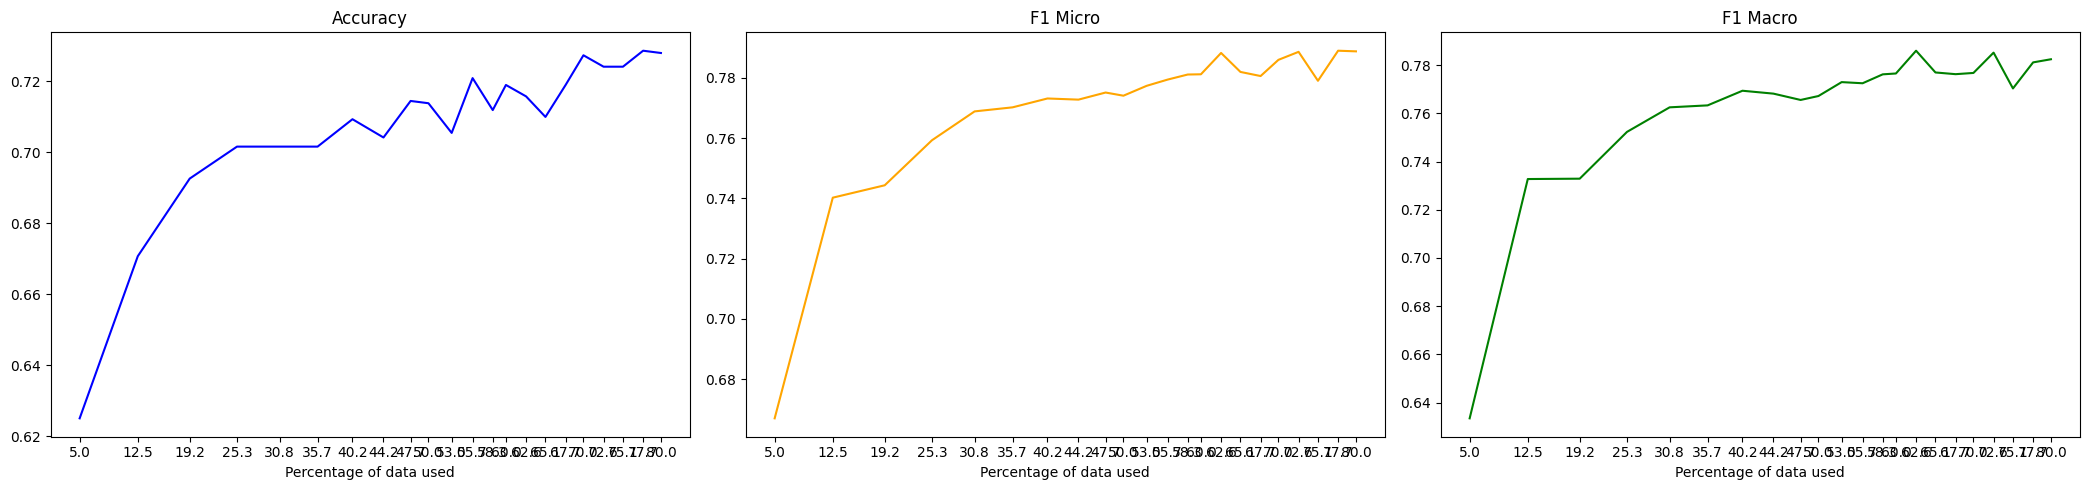

In [ ]:
active_learning(seeds[4], 4)